# Team Based Model

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, LogisticRegression, ElasticNet
from sklearn.linear_model import Ridge, Lasso, SGDClassifier
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf

import pickle

In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-

In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [3]:
def load_team_1H_data():
    """Loads basic, advanced, and scoring boxscores from
    seasons 2000-2019 and merges them into one dataframe
    """
    seasons = ['200{}-0{}'.format(x, x+1) if x != 9 else '200{}-{}'.format(x, x+1) for x in range(6,10)]
    seasons2 = ['20{}-{}'.format(x, x+1) for x in range(10, 20)]
    seasons.extend(seasons2)

    basic_gls_all, adv_gls_all, scoring_gls_all = [], [], []
    for season in seasons:
        basic_gls = pd.read_csv('../data/basic_team_boxscores_1H/team_boxscores_1H_{}.csv'.format(season))
        basic_gls_all.append(basic_gls)

        adv_gls = pd.read_csv('../data/advanced_team_boxscores_1H/team_advanced_1H_{}.csv'.format(season))
        adv_gls_all.append(adv_gls)

        scoring_gls = pd.read_csv('../data/scoring_team_boxscores_1H/team_scoring_1H_{}.csv'.format(season))
        scoring_gls_all.append(scoring_gls)

    basic_gls_all_df = pd.concat(basic_gls_all)
    adv_gls_all_df = pd.concat(adv_gls_all)
    scoring_gls_all_df = pd.concat(scoring_gls_all)

    temp = pd.merge(basic_gls_all_df, adv_gls_all_df, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls_all_df, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
       'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK',
       'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK',
       'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK',
       'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'TEAM_ID_y', 'TEAM_NAME_y',
                                       'TEAM_CITY_y', 'MIN_y', 'PIE_y', 'TEAM_CITY',
                                     'OREB_PCT', 'DREB_PCT', 'REB_PCT'])
    return full_df


df = load_team_1H_data()
df

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0         2006-07  1610612750               MIN  Minnesota Timberwolves   
1         2006-07  1610612742               DAL        Dallas Mavericks   
2         2006-07  1610612743               DEN          Denver Nuggets   
3         2006-07  1610612754               IND          Indiana Pacers   
4         2006-07  1610612745               HOU         Houston Rockets   
...           ...         ...               ...                     ...   
35939     2019-20  1610612762               UTA               Utah Jazz   
35940     2019-20  1610612751               BKN           Brooklyn Nets   
35941     2019-20  1610612755               PHI      Philadelphia 76ers   
35942     2019-20  1610612761               TOR         Toronto Raptors   
35943     2019-20  1610612746               LAC             LA Clippers   

        GAME_ID            GAME_DATE      MATCHUP WL   MIN  FGM  FGA  FG_PCT  \
0      20601225  2007-04-18T00:00:00  MIN vs. MEM  L  24.0   21   48   0.438   
1      20601229  2007-04-18T00:00:00    DAL @ SEA  W  24.0   25   43   0.581   
2      20601224  2007-04-18T00:00:00    DEN @ SAS  W  24.0   20   41   0.488   
3      20601223  2007-04-18T00:00:00  IND vs. WAS  L  24.0   21   46   0.457   
4      20601226  2007-04-18T00:00:00    HOU @ UTA  L  24.0   19   39   0.487   
...         ...                  ...          ... ..   ...  ...  ...     ...   
35939  41900161  2020-08-17T00:00:00    UTA @ DEN  L  24.0   19   46   0.413   
35940  41900111  2020-08-17T00:00:00    BKN @ TOR  L  24.0   19   42   0.452   
35941  41900121  2020-08-17T00:00:00    PHI @ BOS  L  24.0   20   36   0.556   
35942  41900111  2020-08-17T00:00:00  TOR vs. BKN  W  24.0   24   49   0.490   
35943  41900151  2020-08-17T00:00:00  LAC vs. DAL  W  24.0   25   46   0.543   

       FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST   TOV  STL  \
0         3     5    0.600    6    8   0.750    10    13   23   10   9.0    5   
1         3     8    0.375    8   10   0.800     7    16   23   15   3.0    3   
2         6    13    0.462    0    6   0.000     4    20   24   13   8.0    4   
3         6     9    0.667    5    5   1.000     5    14   19    8   5.0    2   
4         5    12    0.417    4    5   0.800     2    11   13   10   8.0    3   
...     ...   ...      ...  ...  ...     ...   ...   ...  ...  ...   ...  ...   
35939     8    22    0.364    6    8   0.750     6    18   24    9   7.0    4   
35940     7    24    0.292    6    9   0.667     1    20   21   17  10.0    2   
35941     5    13    0.385    4    7   0.571     6    17   23   14  13.0    3   
35942    11    23    0.478   14   15   0.933     5    20   25   17   5.0    2   
35943     8    17    0.471    8   11   0.727     3    12   15   11   7.0    8   

       BLK  BLKA  PF  PFD  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        3     3  12    8   51        -3.0         101.0       104.1   
1        3     2  10    7   61        24.0         140.6       141.9   
2        1     1  13    8   46         6.0          96.6       100.0   
3        1     4  10    6   53        -5.0         110.0       115.2   
4        1     0  16    8   47        -3.0          99.6       102.2   
...    ...   ...  ..  ...  ...         ...           ...         ...   
35939    1     2  10   10   52        -7.0         102.9       106.1   
35940    1     2  17   13   51       -22.0          92.8        94.4   
35941    3     1  10   10   49        -6.0         106.3       106.5   
35942    2     1  13   17   73        22.0         131.3       137.7   
35943    2     1  14   10   66        -3.0         120.4       122.2   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  \
0             106.7       110.2          -5.8        -6.1    0.476     1.11   
1              82.5        84.1          58.0        57.8    0.600     5.00   
2              87.5        88.9           9.1        11.1    0.650   

In [4]:
df.to_csv("merged_data_1H.csv", index=False)

In [5]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)
    
    abbr_mapping = {'NJN':'BKN',
                   'CHH':'CHA',
                   'VAN':'MEM',
                   'NOH':'NOP',
                   'NOK':'NOP',
                   'SEA':'OKC'}
    
    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')


    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    
    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)
    df = df.dropna(subset = ['E_OFF_RATING'])
    
    return df

clean_df = clean_team_data(df)
clean_df

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0         2006-07  1610612750               MIN  Minnesota Timberwolves   
1         2006-07  1610612742               DAL        Dallas Mavericks   
2         2006-07  1610612743               DEN          Denver Nuggets   
3         2006-07  1610612754               IND          Indiana Pacers   
4         2006-07  1610612745               HOU         Houston Rockets   
...           ...         ...               ...                     ...   
35939     2019-20  1610612762               UTA               Utah Jazz   
35940     2019-20  1610612751               BKN           Brooklyn Nets   
35941     2019-20  1610612755               PHI      Philadelphia 76ers   
35942     2019-20  1610612761               TOR         Toronto Raptors   
35943     2019-20  1610612746               LAC             LA Clippers   

        GAME_ID  GAME_DATE      MATCHUP  WL   MIN  FGM  FGA  FG_PCT  FG3M  \
0      20601225 2007-04-18  MIN vs. MEM   0  24.0   21   48   0.438     3   
1      20601229 2007-04-18    DAL @ OKC   1  24.0   25   43   0.581     3   
2      20601224 2007-04-18    DEN @ SAS   1  24.0   20   41   0.488     6   
3      20601223 2007-04-18  IND vs. WAS   0  24.0   21   46   0.457     6   
4      20601226 2007-04-18    HOU @ UTA   0  24.0   19   39   0.487     5   
...         ...        ...          ...  ..   ...  ...  ...     ...   ...   
35939  41900161 2020-08-17    UTA @ DEN   0  24.0   19   46   0.413     8   
35940  41900111 2020-08-17    BKN @ TOR   0  24.0   19   42   0.452     7   
35941  41900121 2020-08-17    PHI @ BOS   0  24.0   20   36   0.556     5   
35942  41900111 2020-08-17  TOR vs. BKN   1  24.0   24   49   0.490    11   
35943  41900151 2020-08-17  LAC vs. DAL   1  24.0   25   46   0.543     8   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST   TOV  STL  BLK  \
0         5    0.600    6    8   0.750    10    13   23   10   9.0    5    3   
1         8    0.375    8   10   0.800     7    16   23   15   3.0    3    3   
2        13    0.462    0    6   0.000     4    20   24   13   8.0    4    1   
3         9    0.667    5    5   1.000     5    14   19    8   5.0    2    1   
4        12    0.417    4    5   0.800     2    11   13   10   8.0    3    1   
...     ...      ...  ...  ...     ...   ...   ...  ...  ...   ...  ...  ...   
35939    22    0.364    6    8   0.750     6    18   24    9   7.0    4    1   
35940    24    0.292    6    9   0.667     1    20   21   17  10.0    2    1   
35941    13    0.385    4    7   0.571     6    17   23   14  13.0    3    3   
35942    23    0.478   14   15   0.933     5    20   25   17   5.0    2    2   
35943    17    0.471    8   11   0.727     3    12   15   11   7.0    8    2   

       BLKA  PF  PFD  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
0         3  12    8   51        -3.0         101.0       104.1         106.7   
1         2  10    7   61        24.0         140.6       141.9          82.5   
2         1  13    8   46         6.0          96.6       100.0          87.5   
3         4  10    6   53        -5.0         110.0       115.2         128.8   
4         0  16    8   47        -3.0          99.6       102.2         103.4   
...     ...  ..  ...  ...         ...           ...         ...           ...   
35939     2  10   10   52        -7.0         102.9       106.1         120.2   
35940     2  17   13   51       -22.0          92.8        94.4         131.3   
35941     1  10   10   49        -6.0         106.3       106.5         118.2   
35942     1  13   17   73        22.0         131.3       137.7          92.8   
35943     1  14   10   66        -3.0         120.4       122.2         123.1   

       DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  \
0           110.2          -5.8        -6.1    0.476     1.11       14.2   
1            84.1          58.0        57.8    0.600     5.00       22.9   
2            88.9 

In [6]:
def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()
    
    df = df.drop(columns=['FT_PCT', 'FG_PCT', 'FG3_PCT', 'AST_PCT', 'AST_TOV',
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
                          'PACE', 'PACE_PER40'])
    
    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['PTS_FB'] = (df['PTS'] * df['PCT_PTS_FB']).astype('int8')
    df['PTS_OFF_TOV'] = (df['PTS'] * df['PCT_PTS_OFF_TOV']).astype('int8')
    df['PTS_PAINT'] = (df['PTS'] * df['PCT_PTS_PAINT']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')    

    df = df.drop(columns = ['PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 
                            'PCT_PTS_3PT', 'PCT_PTS_FB',
                            'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
                            'PCT_AST_2PM', 'PCT_UAST_2PM', 
                            'PCT_AST_3PM', 'PCT_UAST_3PM', 
                            'PCT_AST_FGM', 'PCT_UAST_FGM', 
                            'FGM', 'FGA'])

    df['point_diff'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']
    
    df = df[['SEASON_YEAR', 'TEAM_ID',
      'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE',
      'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'point_diff', 'WL', 'MIN', 'RECORD',
      'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA',
      'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'BLKA', 'TOV', 'PF', 'PFD',
      'PTS', 'PLUS_MINUS', 'E_OFF_RATING', 'OFF_RATING', 
      'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 
      'POSS', 'PIE', 'PTS_2PT_MR', 'PTS_FB', 'PTS_OFF_TOV',
      'PTS_PAINT', 'AST_2PM', 'UAST_2PM', 'AST_3PM', 'UAST_3PM']]

    
    return df



clean_df2 = prep_for_aggregation(clean_df)

In [7]:
clean_df2

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0         2006-07  1610612750               MIN  Minnesota Timberwolves   
1         2006-07  1610612742               DAL        Dallas Mavericks   
2         2006-07  1610612743               DEN          Denver Nuggets   
3         2006-07  1610612754               IND          Indiana Pacers   
4         2006-07  1610612745               HOU         Houston Rockets   
...           ...         ...               ...                     ...   
35939     2019-20  1610612762               UTA               Utah Jazz   
35940     2019-20  1610612751               BKN           Brooklyn Nets   
35941     2019-20  1610612755               PHI      Philadelphia 76ers   
35942     2019-20  1610612761               TOR         Toronto Raptors   
35943     2019-20  1610612746               LAC             LA Clippers   

        GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  point_diff  \
0      20601225 2007-04-18  MIN vs. MEM          1          51        -3.0   
1      20601229 2007-04-18    DAL @ OKC          0          61        24.0   
2      20601224 2007-04-18    DEN @ SAS          0          46         6.0   
3      20601223 2007-04-18  IND vs. WAS          1          53        -5.0   
4      20601226 2007-04-18    HOU @ UTA          0          47        -3.0   
...         ...        ...          ...        ...         ...         ...   
35939  41900161 2020-08-17    UTA @ DEN          0          52        -7.0   
35940  41900111 2020-08-17    BKN @ TOR          0          51       -22.0   
35941  41900121 2020-08-17    PHI @ BOS          0          49        -6.0   
35942  41900111 2020-08-17  TOR vs. BKN          1          73        22.0   
35943  41900151 2020-08-17  LAC vs. DAL          1          66        -3.0   

       WL   MIN  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  \
0       0  24.0       0    18    43     3     5    6    8    10    13   23   
1       1  24.0       1    22    35     3     8    8   10     7    16   23   
2       1  24.0       1    14    28     6    13    0    6     4    20   24   
3       0  24.0       0    15    37     6     9    5    5     5    14   19   
4       0  24.0       0    14    27     5    12    4    5     2    11   13   
...    ..   ...     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...   
35939   0  24.0       0    11    24     8    22    6    8     6    18   24   
35940   0  24.0       0    12    18     7    24    6    9     1    20   21   
35941   0  24.0       0    15    23     5    13    4    7     6    17   23   
35942   1  24.0       1    13    26    11    23   14   15     5    20   25   
35943   1  24.0       1    17    29     8    17    8   11     3    12   15   

       AST  STL  BLK  BLKA   TOV  PF  PFD  PTS  PLUS_MINUS  E_OFF_RATING  \
0       10    5    3     3   9.0  12    8   51        -3.0         101.0   
1       15    3    3     2   3.0  10    7   61        24.0         140.6   
2       13    4    1     1   8.0  13    8   46         6.0          96.6   
3        8    2    1     4   5.0  10    6   53        -5.0         110.0   
4       10    3    1     0   8.0  16    8   47        -3.0          99.6   
...    ...  ...  ...   ...   ...  ..  ...  ...         ...           ...   
35939    9    4    1     2   7.0  10   10   52        -7.0         102.9   
35940   17    2    1     2  10.0  17   13   51       -22.0          92.8   
35941   14    3    3     1  13.0  10   10   49        -6.0         106.3   
35942   17    2    2     1   5.0  13   17   73        22.0         131.3   
35943   11    8    2     1   7.0  14   10   66        -3.0         120.4   

       OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  POSS  \
0           104.1         106.7       110.2          -5.8        -6.1  49.0   
1           141.9          82.5        84.1          58.0        57.8  43.0   
2           100.0          87.5        88.9           9.1        11.1  46.0   
3 

## Add Betting Data 

In [8]:
spread_df = pd.read_csv('../data/spreads_1H.csv', parse_dates=['game_date'])
spread_df.head()

away_team     home_team  game_date            away_1H_spread  \
0   Chicago         Miami 2006-10-31  '-', '-', '+2½-110', '-'   
1   Phoenix   L.A. Lakers 2006-10-31  '-', '-', '-4½-115', '-'   
2   Indiana     Charlotte 2006-11-01   '-', '-', 'PK-110', '-'   
3   Chicago       Orlando 2006-11-01   '-', '-', 'PK-120', '-'   
4   Atlanta  Philadelphia 2006-11-01  '-', '-', '+2½-105', '-'   

             home_1H_spread  
0  '-', '-', '-2½-110', '-'  
1  '-', '-', '+4½-105', '-'  
2   '-', '-', 'PK-110', '-'  
3   '-', '-', 'PK+100', '-'  
4  '-', '-', '-2½-115', '-'

In [9]:
spread_df.to_csv("spread_data_1H.csv", index=False)

In [10]:
missing_dates = set([])
# spread_df.loc[spread_df['away_1H_spread'] == "-, -, -, -"]
# spread_df.loc[spread_df['home_1H_spread'] == "-, -, -, -"]
dates = spread_df.loc[spread_df['home_1H_spread'].isnull(), 'game_date'].astype(str)
missing_dates.update(dates)
# spread_df.loc[274:274]

In [11]:
def clean_spread_data(df):

    abbr_mapping = {'Boston':'BOS', 'Portland':'POR', 
                'L.A. Lakers':'LAL', 'Brooklyn':'BKN', 
                'Cleveland':'CLE', 'Toronto':'TOR',
                'Philadelphia':'PHI', 'Memphis':'MEM',
                'Minnesota':'MIN', 'New Orleans':'NOP',
               'Oklahoma City':'OKC', 'Dallas':'DAL', 
                'San Antonio':'SAS', 'Denver':'DEN', 
                'Golden State':'GSW', 'L.A. Clippers':'LAC', 
                'Orlando':'ORL', 'Utah':'UTA', 
                'Charlotte':'CHA', 'Detroit':'DET',
               'Miami':'MIA', 'Phoenix':'PHX',
                'Atlanta':'ATL', 'New York':'NYK', 
                'Indiana':'IND', 'Chicago':'CHI',
               'Houston':'HOU', 'Milwaukee':'MIL',
                'Sacramento':'SAC', 'Washington':'WAS'}

    df['home_team'] = df['home_team'].replace(abbr_mapping)
    df['away_team'] = df['away_team'].replace(abbr_mapping)
    
    df['away_1H_spread'] = df['away_1H_spread'].str.replace("'", "")
    df['away_1H_spread'] = df['away_1H_spread'].str.replace("½", ".5")
    df['away_1H_spread'] = df['away_1H_spread'].str.replace("PK", "0")
    df['away_1H_spread'] = df['away_1H_spread'].str.replace("+", "")

    
    df['home_1H_spread'] = df['home_1H_spread'].str.replace("'", "")
    df['home_1H_spread'] = df['home_1H_spread'].str.replace("½", ".5")
    df['home_1H_spread'] = df['home_1H_spread'].str.replace("PK", "0")
    df['home_1H_spread'] = df['home_1H_spread'].str.replace("+", "")


    away_spreads = df['away_1H_spread'].str.split(',', expand=True)
    home_spreads = df['home_1H_spread'].str.split(',', expand=True)
    away_spreads.columns = ['away_spread_1H_1', 'away_spread_1H_2', 'away_spread_1H_3', 'away_spread_1H_4']
    home_spreads.columns = ['home_spread_1H_1', 'home_spread_1H_2', 'home_spread_1H_3', 'home_spread_1H_4']
    
    full_df = pd.concat([df, away_spreads, home_spreads], axis=1)
    full_df = full_df.drop(columns=['away_1H_spread', 'home_1H_spread'])

    for col in full_df.columns[3:]:
        full_df[col] = full_df[col].str.strip()
        full_df[col] = full_df[col].str[:-3]
        full_df.loc[full_df[col] == '', col] = np.nan
#         full_df.loc[full_df[col] == '-', col] = np.nan
#         full_df.loc[full_df[col] == '-.', col] = 0
        
#     for col in full_df.columns[3:]:
#         full_df[col] = full_df[col].str.replace('[', '')
#         full_df[col] = full_df[col].str.replace(']', '')
#         full_df[col] = full_df[col].str.replace("'", '')
#         full_df[col] = full_df[col].str.strip()

        
    for col in full_df.columns[3:]:
        full_df[col] = full_df[col].apply(lambda x: str(x)[:-1] if str(x)[-1] == '-' else x)
        full_df[col] = full_df[col].astype(float)
        
    full_df['away_spread_1H'] = full_df[['away_spread_1H_1', 'away_spread_1H_2', 
                                           'away_spread_1H_3', 'away_spread_1H_4']].mode(axis=1)[0]
    full_df['home_spread_1H'] = full_df[['home_spread_1H_1', 'home_spread_1H_2',
                                           'home_spread_1H_3', 'home_spread_1H_4']].mode(axis=1)[0]

    return full_df

clean_spread_df = clean_spread_data(spread_df)
clean_spread_df

away_team home_team  game_date  away_spread_1H_1  away_spread_1H_2  \
0           CHI       MIA 2006-10-31               NaN               NaN   
1           PHX       LAL 2006-10-31               NaN               NaN   
2           IND       CHA 2006-11-01               NaN               NaN   
3           CHI       ORL 2006-11-01               NaN               NaN   
4           ATL       PHI 2006-11-01               NaN               NaN   
...         ...       ...        ...               ...               ...   
18665       MIA       CHA 2021-05-02              -2.5              -2.5   
18666       PHI       SAS 2021-05-02              -6.0              -5.5   
18667       POR       BOS 2021-05-02              -0.5              -0.5   
18668       BKN       MIL 2021-05-02               1.0               1.0   
18669       NYK       HOU 2021-05-02              -6.5              -6.5   

       away_spread_1H_3  away_spread_1H_4  home_spread_1H_1  home_spread_1H_2  \
0                   2.5               NaN               NaN               NaN   
1                  -4.5               NaN               NaN               NaN   
2                   0.0               NaN               NaN               NaN   
3                   0.0               NaN               NaN               NaN   
4                   2.5               NaN               NaN               NaN   
...                 ...               ...               ...               ...   
18665              -3.0              -2.5               2.5               2.5   
18666              -5.5              -5.5               6.0               5.5   
18667              -0.5               0.0               0.5               0.5   
18668               1.0               1.0              -1.0              -1.0   
18669              -6.5              -6.5               6.5               6.5   

       home_spread_1H_3  home_spread_1H_4  away_spread_1H  home_spread_1H  
0                  -2.5               NaN             2.5            -2.5  
1                   4.5               NaN            -4.5             4.5  
2                   0.0               NaN             0.0             0.0  
3                   0.0               NaN             0.0             0.0  
4                  -2.5               NaN             2.5            -2.5  
...                 ...               ...             ...             ...  
18665               3.0               2.5            -2.5             2.5  
18666               5.5               5.5            -5.5             5.5  
18667               0.5               0.0            -0.5             0.5  
18668              -1.0              -1.0             1.0            -1.0  
18669               6.5               6.5            -6.5             6.5  

[18670 rows x 13 columns]

In [13]:
def add_spread_data(df, clean_spread_df):
    df = df.copy()
    df['home_team'] = df['MATCHUP'].apply(lambda x: x[:3] if 'vs' in x else x[-3:])
    df['away_team'] = df['MATCHUP'].apply(lambda x: x[:3] if '@' in x else x[-3:])
    df[['home_team', 'away_team', 'MATCHUP']]
    
    df = pd.merge(df, clean_spread_df[['away_team', 'home_team', 'game_date', 'away_spread_1H', 'home_spread_1H']], 
                      how='left', left_on=['home_team', 'away_team', 'GAME_DATE'], 
                      right_on=['home_team', 'away_team', 'game_date'])    
    
    df['team_covered'] = df.apply(lambda row: int(row['point_diff'] + row['home_spread_1H'] > 0) 
                                          if row['HOME_GAME'] == 1 else int(row['point_diff'] 
                                                                            + row['away_spread_1H'] > 0), axis=1)

    return df


clean_df_spread = add_spread_data(clean_df2, clean_spread_df)
clean_df_spread

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0         2006-07  1610612750               MIN  Minnesota Timberwolves   
1         2006-07  1610612742               DAL        Dallas Mavericks   
2         2006-07  1610612743               DEN          Denver Nuggets   
3         2006-07  1610612754               IND          Indiana Pacers   
4         2006-07  1610612745               HOU         Houston Rockets   
...           ...         ...               ...                     ...   
35939     2019-20  1610612762               UTA               Utah Jazz   
35940     2019-20  1610612751               BKN           Brooklyn Nets   
35941     2019-20  1610612755               PHI      Philadelphia 76ers   
35942     2019-20  1610612761               TOR         Toronto Raptors   
35943     2019-20  1610612746               LAC             LA Clippers   

        GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  point_diff  \
0      20601225 2007-04-18  MIN vs. MEM          1          51        -3.0   
1      20601229 2007-04-18    DAL @ OKC          0          61        24.0   
2      20601224 2007-04-18    DEN @ SAS          0          46         6.0   
3      20601223 2007-04-18  IND vs. WAS          1          53        -5.0   
4      20601226 2007-04-18    HOU @ UTA          0          47        -3.0   
...         ...        ...          ...        ...         ...         ...   
35939  41900161 2020-08-17    UTA @ DEN          0          52        -7.0   
35940  41900111 2020-08-17    BKN @ TOR          0          51       -22.0   
35941  41900121 2020-08-17    PHI @ BOS          0          49        -6.0   
35942  41900111 2020-08-17  TOR vs. BKN          1          73        22.0   
35943  41900151 2020-08-17  LAC vs. DAL          1          66        -3.0   

       WL   MIN  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  \
0       0  24.0       0    18    43     3     5    6    8    10    13   23   
1       1  24.0       1    22    35     3     8    8   10     7    16   23   
2       1  24.0       1    14    28     6    13    0    6     4    20   24   
3       0  24.0       0    15    37     6     9    5    5     5    14   19   
4       0  24.0       0    14    27     5    12    4    5     2    11   13   
...    ..   ...     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...   
35939   0  24.0       0    11    24     8    22    6    8     6    18   24   
35940   0  24.0       0    12    18     7    24    6    9     1    20   21   
35941   0  24.0       0    15    23     5    13    4    7     6    17   23   
35942   1  24.0       1    13    26    11    23   14   15     5    20   25   
35943   1  24.0       1    17    29     8    17    8   11     3    12   15   

       AST  STL  BLK  BLKA   TOV  PF  PFD  PTS  PLUS_MINUS  E_OFF_RATING  \
0       10    5    3     3   9.0  12    8   51        -3.0         101.0   
1       15    3    3     2   3.0  10    7   61        24.0         140.6   
2       13    4    1     1   8.0  13    8   46         6.0          96.6   
3        8    2    1     4   5.0  10    6   53        -5.0         110.0   
4       10    3    1     0   8.0  16    8   47        -3.0          99.6   
...    ...  ...  ...   ...   ...  ..  ...  ...         ...           ...   
35939    9    4    1     2   7.0  10   10   52        -7.0         102.9   
35940   17    2    1     2  10.0  17   13   51       -22.0          92.8   
35941   14    3    3     1  13.0  10   10   49        -6.0         106.3   
35942   17    2    2     1   5.0  13   17   73        22.0         131.3   
35943   11    8    2     1   7.0  14   10   66        -3.0         120.4   

       OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  POSS  \
0           104.1         106.7       110.2          -5.8        -6.1  49.0   
1           141.9          82.5        84.1          58.0        57.8  43.0   
2           100.0          87.5        88.9           9.1        11.1  46.0   
3 

In [15]:
from src.data.make_team_dataset import create_matchups

def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    
    df['spread'] = df.apply(lambda row: row['home_spread_1H'] if row['HOME_GAME'] == 1 else -row['home_spread_1H'], axis=1)

    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['_team', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION_team'] != matchups['TEAM_ABBREVIATION_opp']]
    
    matchups = matchups.drop(columns = ['home_team_team', 'away_team_team', 'game_date_team',
                                        'away_spread_1H_team', 'home_spread_1H_team',
                                        'SEASON_YEAR_opp', 'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp', 
                                        'TEAM_NAME_opp', 'GAME_DATE_opp', 'MATCHUP_opp', 'HOME_GAME_opp',
                                        'WL_opp', 'MIN_opp', 'home_team_opp', 'away_team_opp', 
                                        'game_date_opp', 'away_spread_1H_opp', 'home_spread_1H_opp',
                                        'spread_opp', 'OFF_RATING_opp', 'DEF_RATING_opp',
                                        'NET_RATING_opp', 'OFF_RATING_team', 'DEF_RATING_team', 'NET_RATING_team',
                                       'MIN_team']
                            )
    
    
    matchups = matchups[['SEASON_YEAR_team', 'TEAM_ABBREVIATION_team',
       'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team', 'HOME_GAME_team',
       'WL_team',  'RECORD_team', 'TEAM_SCORE_team', 'point_diff_team',
        'spread_team', 'team_covered_team',  'FG2M_team', 'FG2A_team',
        'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team',
       'OREB_team', 'DREB_team', 'REB_team', 'AST_team', 'TOV_team',
       'STL_team', 'BLK_team', 'BLKA_team', 'PF_team', 'PFD_team', 'PTS_team',
       'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
       'E_NET_RATING_team', 'POSS_team', 'PIE_team',
        'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team',
        'AST_2PM_team', 'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 
       'FG2M_opp', 'FG2A_opp', 'FG3M_opp', 'FG3A_opp', 'FTM_opp', 'FTA_opp', 
        'OREB_opp', 'DREB_opp', 'REB_opp', 'AST_opp', 'TOV_opp', 'STL_opp', 
        'BLK_opp', 'BLKA_opp',  'PF_opp', 'PFD_opp', 'PTS_opp', 'PLUS_MINUS_opp',
        'E_OFF_RATING_opp', 'E_DEF_RATING_opp', 'E_NET_RATING_opp', 
       'POSS_opp', 'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp',
       'PTS_OFF_TOV_opp', 'PTS_PAINT_opp', 'AST_2PM_opp', 'AST_3PM_opp',
       'UAST_2PM_opp', 'UAST_3PM_opp', 'point_diff_opp', 'RECORD_opp',
       'team_covered_opp']]
    
    
    return matchups


matchups = create_matchups(clean_df_spread)

In [18]:
matchups.iloc[:, 12:]

FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  FTA_team  \
1             18         43          3          5         6         8   
2             22         39          0          5        10        15   
5             22         35          3          8         8        10   
6             13         30          1          6         8        11   
9             14         28          6         13         0         6   
...          ...        ...        ...        ...       ...       ...   
71878         15         23          5         13         4         7   
71881          9         16         12         21        15        16   
71882         17         29          8         17         8        11   
71885         12         18          7         24         6         9   
71886         13         26         11         23        14        15   

       OREB_team  DREB_team  REB_team  AST_team  TOV_team  STL_team  BLK_team  \
1             10         13        23        10       9.0         5         3   
2              7         15        22        17       7.0         5         3   
5              7         16        23        15       3.0         3         3   
6              4         11        15         4       8.0         2         2   
9              4         20        24        13       8.0         4         1   
...          ...        ...       ...       ...       ...       ...       ...   
71878          6         17        23        14      13.0         3         3   
71881          1         16        17        12      13.0         6         1   
71882          3         12        15        11       7.0         8         2   
71885          1         20        21        17      10.0         2         1   
71886          5         20        25        17       5.0         2         2   

       BLKA_team  PF_team  PFD_team  PTS_team  PLUS_MINUS_team  \
1              3       12         8        51             -3.0   
2              3        8        12        54              3.0   
5              2       10         7        61             24.0   
6              3        7        10        37            -24.0   
9              1       13         8        46              6.0   
...          ...      ...       ...       ...              ...   
71878          1       10        10        49             -6.0   
71881          2       10        14        69              3.0   
71882          1       14        10        66             -3.0   
71885          2       17        13        51            -22.0   
71886          1       13        17        73             22.0   

       E_OFF_RATING_team  E_DEF_RATING_team  E_NET_RATING_team  POSS_team  \
1                  101.0              106.7               -5.8       49.0   
2                  106.7              101.0                5.8       49.0   
5                  140.6               82.5               58.0       43.0   
6                   82.5              140.6              -58.0       44.0   
9                   96.6               87.5                9.1       46.0   
...                  ...                ...                ...        ...   
71878              106.3              118.2              -11.9       46.0   
71881              123.1              120.4                2.8       54.0   
71882              120.4              123.1               -2.8       54.0   
71885               92.8              131.3              -38.5       54.0   
71886              131.3               92.8               38.5       53.0   

       PIE_team  PTS_2PT_MR_team  PTS_FB_team  PTS_OFF_TOV_team  \
1         0.397                9            4                 6   
2         0.603               15            5                 7   
5         0.798               15           10                17   
6         0.202               20            0                 0   
9         0.620                8           13                 6   
...         ...              ...     

In [19]:
def get_team_and_opp_ewm(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
        

    team_dfs = []
    for season in tqdm(df['SEASON_YEAR_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            record_team = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec_team = team_df['team_covered_team'].shift(1).expanding().mean()
            
            records = pd.DataFrame({'WL_record':record_team,
                                   'ATS_record':ATS_rec_team})
            
            team_df.iloc[:, 12:] = team_df.iloc[:, 12:].shift(1).ewm(span = span, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)
            
            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df

# avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=5, span=19)

In [20]:
avg_data_ewm_9 = get_team_and_opp_ewm(matchups, min_periods=5, span=9)
avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=5, span=19)
avg_data_ewm_29 = get_team_and_opp_ewm(matchups, min_periods=5, span=29)


avg_data_ewm_9.shape, avg_data_ewm_19.shape, avg_data_ewm_29.shape

Progress: 100%|████████████████████████████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.12it/s]


((35944, 79), (35944, 79), (35944, 79))

In [21]:
def get_team_and_opp_avg(df, min_periods=5, window=10):
    df = df.copy()


    team_dfs = []
    for season in tqdm(df['SEASON_YEAR_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            record_team = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec_team = team_df['team_covered_team'].shift(1).expanding().mean()
            
            records = pd.DataFrame({'WL_record':record_team,
                                   'ATS_record':ATS_rec_team})
            
            team_df.iloc[:, 12:] = team_df.iloc[:, 12:].shift(1).rolling(window = window, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)
            
            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df

# avg_data_10 = get_team_and_opp_avg(matchups, min_periods=5, window=10)


In [22]:
avg_data_3= get_team_and_opp_avg(matchups, min_periods=3, window=3)

avg_data_5 = get_team_and_opp_avg(matchups, min_periods=5, window=5)

avg_data_10 = get_team_and_opp_avg(matchups, min_periods=5, window=10)

avg_data_all = get_team_and_opp_avg(matchups, min_periods=5, window=120)


avg_data_3.shape, avg_data_5.shape, avg_data_10.shape, avg_data_all.shape


Progress: 100%|████████████████████████████████████████████████████████████████████████| 14/14 [00:13<00:00,  1.06it/s]


((35944, 79), (35944, 79), (35944, 79), (35944, 79))

In [23]:
avg_data_5

SEASON_YEAR_team TEAM_ABBREVIATION_team   GAME_ID GAME_DATE_team  \
0              2006-07                    MIN  20600011     2006-11-01   
1              2006-07                    MIN  20600027     2006-11-03   
2              2006-07                    MIN  20600038     2006-11-04   
3              2006-07                    MIN  20600050     2006-11-06   
4              2006-07                    MIN  20600057     2006-11-07   
...                ...                    ...       ...            ...   
35939          2019-20                    ATL  21900905     2020-03-02   
35940          2019-20                    ATL  21900930     2020-03-06   
35941          2019-20                    ATL  21900943     2020-03-07   
35942          2019-20                    ATL  21900957     2020-03-09   
35943          2019-20                    ATL  21900969     2020-03-11   

      MATCHUP_team  HOME_GAME_team  WL_team  RECORD_team  TEAM_SCORE_team  \
0      MIN vs. SAC               1        1            1               43   
1        MIN @ DEN               0        1            1               53   
2        MIN @ POR               0        0            0               52   
3        MIN @ SAC               0        0            0               42   
4        MIN @ LAL               0        0            0               45   
...            ...             ...      ...          ...              ...   
35939  ATL vs. MEM               1        0            0               49   
35940    ATL @ WAS               0        0            0               57   
35941    ATL @ MEM               0        0            0               45   
35942  ATL vs. CHA               1        1            1               66   
35943  ATL vs. NYK               1        0            0               50   

       point_diff_team  spread_team  team_covered_team  FG2M_team  FG2A_team  \
0                  2.0         -2.5                  0        NaN        NaN   
1                 -4.0          3.0                  0        NaN        NaN   
2                 11.0         -2.0                  1        NaN        NaN   
3                 -4.0          2.5                  0        NaN        NaN   
4                 -6.0          4.0                  0        NaN        NaN   
...                ...          ...                ...        ...        ...   
35939             -3.0         -0.5                  0       15.0       27.8   
35940             -7.0          3.5                  0       14.2       28.6   
35941            -21.0          4.0                  0       14.4       28.2   
35942              3.0         -2.5                  1       13.0       27.6   
35943            -17.0         -3.5                  0       12.4       25.0   

       FG3M_team  FG3A_team  FTM_team  FTA_team  OREB_team  DREB_team  \
0            NaN        NaN       NaN       NaN        NaN        NaN   
1            NaN        NaN       NaN       NaN        NaN        NaN   
2            NaN        NaN       NaN       NaN        NaN        NaN   
3            NaN        NaN       NaN       NaN        NaN        NaN   
4            NaN        NaN       NaN       NaN        NaN        NaN   
...          ...        ...       ...       ...        ...        ...   
35939        6.8       18.8      10.6      12.2        4.8       17.6   
35940        6.8       18.6      10.4      11.6        6.2       16.6   
35941        7.4       17.8       9.2      10.2        5.0       16.0   
35942        7.2       19.4       8.8       9.8        6.0       15.6   
35943        7.6       19.4       8.4       9.8        4.8       15.4   

       REB_team  AST_team  TOV_team  STL_team  BLK_team  BLKA_team  PF_team  \
0           NaN       NaN       NaN       NaN       NaN        NaN      NaN   
1           NaN       NaN       NaN       NaN       NaN        NaN      NaN   
2           NaN       NaN       NaN       NaN       NaN        NaN      NaN   
3           NaN       NaN       NaN   

In [24]:
avg_data_5.loc[(avg_data_5['TEAM_ABBREVIATION_team'] == 'HOU') 
                   & (avg_data_5['SEASON_YEAR_team'] == '2016-17'), ['MATCHUP_team', 'point_diff_team', 'RECORD_team',
                                                                          'team_covered_team', 'spread_team', 'WL_record', 
                                                                          'ATS_record']].head(20)

# avg_data_ewm_19.iloc[:, 11:]

MATCHUP_team  point_diff_team  RECORD_team  team_covered_team  \
26494    HOU @ LAL              8.0            0                  1   
26495    HOU @ DAL              2.0            1                  1   
26496  HOU vs. DAL             10.0            1                  1   
26497    HOU @ CLE             -4.0            0                  1   
26498    HOU @ NYK             17.0            1                  1   
26499    HOU @ ATL             -6.0            0                  0   
26500    HOU @ WAS              9.0            1                  1   
26501    HOU @ SAS              3.0            1                  1   
26502  HOU vs. SAS             -9.0            0                  0   
26503  HOU vs. PHI             13.0            1                  1   
26504    HOU @ OKC             -2.0            0                  0   
26505  HOU vs. POR              0.0            1                  0   
26506  HOU vs. UTA             11.0            1                  1   
26507    HOU @ DET              5.0            1                  1   
26508  HOU vs. TOR            -15.0            0                  0   
26509    HOU @ SAC             18.0            1                  1   
26510    HOU @ POR              3.0            1                  1   
26511    HOU @ UTA            -12.0            0                  0   
26512    HOU @ GSW              5.0            1                  1   
26513    HOU @ DEN             10.0            1                  1   

       spread_team  WL_record  ATS_record  
26494         -3.0        NaN         NaN  
26495         -0.5   0.000000    1.000000  
26496         -3.0   0.500000    1.000000  
26497          5.5   0.666667    1.000000  
26498         -0.0   0.500000    1.000000  
26499          1.5   0.600000    1.000000  
26500          0.5   0.500000    0.833333  
26501          5.0   0.571429    0.857143  
26502          0.0   0.625000    0.875000  
26503         -6.5   0.555556    0.777778  
26504          1.0   0.600000    0.800000  
26505         -3.0   0.545455    0.727273  
26506         -3.5   0.583333    0.666667  
26507         -1.0   0.615385    0.692308  
26508         -2.0   0.642857    0.714286  
26509         -1.5   0.600000    0.666667  
26510         -0.0   0.625000    0.687500  
26511         -0.5   0.647059    0.705882  
26512          6.5   0.611111    0.666667  
26513          2.0   0.631579    0.684211

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [25]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT.
    """
    
    df = df.copy()
    
    df['OREB_PCT_team'] = df['OREB_team'] / (df['OREB_team'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB_team'])

    df['DREB_PCT_team'] = df['DREB_team'] / (df['DREB_team'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB_team'])

    df['REB_PCT_team'] = df['REB_team'] / (df['REB_team'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB_team'])

    df['TS_PCT_team'] = df['PTS_team'] / ((2*(df['FG2A_team'] + df['FG3A_team']) + 0.44*df['FTA_team']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT_team'] = (df['FG2M_team'] + 1.5*df['FG3M_team']) / (df['FG2A_team']
                                                                    + df['FG3A_team'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO_team'] = (df['AST_team'] * 100) / df['POSS_team']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['POSS_opp']

    df['TOV_PCT_team'] = 100*df['TOV_team'] / (df['FG2A_team'] 
                                               + df['FG3A_team'] 
                                               + 0.44*df['FTA_team'] 
                                               + df['TOV_team'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])

    
    return df



df_ewm_9 = add_percentage_features(avg_data_ewm_9)
df_ewm_19 = add_percentage_features(avg_data_ewm_19)
df_ewm_29 = add_percentage_features(avg_data_ewm_29)

df_avg_3 = add_percentage_features(avg_data_3)
df_avg_5 = add_percentage_features(avg_data_5)
df_avg_10 = add_percentage_features(avg_data_10)

df_avg_all = add_percentage_features(avg_data_all)


In [26]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [27]:
df_ewm_9 = add_rest_days(df_ewm_9)
df_ewm_19 = add_rest_days(df_ewm_19)
df_ewm_29 = add_rest_days(df_ewm_29)
df_avg_3 = add_rest_days(df_avg_3)
df_avg_5 = add_rest_days(df_avg_5)
df_avg_10 = add_rest_days(df_avg_10)
df_avg_all = add_rest_days(df_avg_all)



In [28]:
df_ewm_9.loc[df_ewm_9['rest'] > 11, 'rest'] = 11
df_ewm_19.loc[df_ewm_29['rest'] > 11, 'rest'] = 11
df_ewm_29.loc[df_ewm_29['rest'] > 11, 'rest'] = 11
df_avg_3.loc[df_avg_3['rest'] > 11, 'rest'] = 11
df_avg_5.loc[df_avg_5['rest'] > 11, 'rest'] = 11
df_avg_10.loc[df_avg_10['rest'] > 11, 'rest'] = 11
df_avg_all.loc[df_avg_all['rest'] >11, 'rest'] = 11

In [29]:
df_ewm_9.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_ewm_19.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_ewm_29.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_avg_3.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_avg_5.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_avg_10.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_avg_all.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)

df_ewm_9.reset_index(drop=True, inplace=True)
df_ewm_19.reset_index(drop=True, inplace=True)
df_ewm_29.reset_index(drop=True, inplace=True)
df_avg_3.reset_index(drop=True, inplace=True)
df_avg_5.reset_index(drop=True, inplace=True)
df_avg_10.reset_index(drop=True, inplace=True)
df_avg_all.reset_index(drop=True, inplace=True)


In [30]:
print(df_ewm_9.shape, df_ewm_19.shape, df_ewm_29.shape, 
      df_avg_3.shape, df_avg_5.shape, df_avg_10.shape, df_avg_all.shape)


(35944, 94) (35944, 94) (35944, 94) (35944, 94) (35944, 94) (35944, 94) (35944, 94)


In [33]:
def compute_matchup_diffs(avg_data):
    avg_data = avg_data.copy(deep=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs_home = home_teams.iloc[:, 12:] - away_teams.iloc[:, 12:]
    new_cols = [col+"_diff" for col in stat_diffs_home.columns]
    stat_diffs_home.columns = new_cols

    stat_diffs_away = away_teams.iloc[:, 12:] - home_teams.iloc[:, 12:]
    stat_diffs_away.columns = new_cols

    full_df_home = pd.concat([home_teams.iloc[:, :12], stat_diffs_home], axis=1)
    full_df_away = pd.concat([away_teams.iloc[:, :12], stat_diffs_away], axis=1)

    full_df = pd.concat([full_df_home, full_df_away])
    
#     full_df = full_df.dropna()
    full_df = full_df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])

    full_df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

# df_ewm_19_diffs = compute_matchup_diffs(df_ewm_19)

In [34]:
df_ewm_9_diffs = compute_matchup_diffs(df_ewm_9)
df_ewm_19_diffs = compute_matchup_diffs(df_ewm_19)
df_ewm_29_diffs = compute_matchup_diffs(df_ewm_29)
df_avg_3_diffs = compute_matchup_diffs(df_avg_3)
df_avg_5_diffs = compute_matchup_diffs(df_avg_5)
df_avg_10_diffs = compute_matchup_diffs(df_avg_10)
df_avg_all_diffs = compute_matchup_diffs(df_avg_all)

In [35]:
df_ewm_9_diffs

SEASON_YEAR TEAM_ABBREVIATION   GAME_ID  GAME_DATE      MATCHUP  \
0         2006-07               CHI  20600001 2006-10-31    CHI @ MIA   
1         2006-07               MIA  20600001 2006-10-31  MIA vs. CHI   
2         2006-07               PHX  20600002 2006-10-31    PHX @ LAL   
3         2006-07               LAL  20600002 2006-10-31  LAL vs. PHX   
4         2006-07               ATL  20600003 2006-11-01    ATL @ PHI   
...           ...               ...       ...        ...          ...   
35939     2019-20               MIA  41900404 2020-10-06  MIA vs. LAL   
35940     2019-20               MIA  41900405 2020-10-09    MIA @ LAL   
35941     2019-20               LAL  41900405 2020-10-09  LAL vs. MIA   
35942     2019-20               LAL  41900406 2020-10-11    LAL @ MIA   
35943     2019-20               MIA  41900406 2020-10-11  MIA vs. LAL   

       HOME_GAME  WL_team  RECORD_team  SCORE_team  point_diff_team  \
0              0        1            1          59             29.0   
1              1        0            0          30            -29.0   
2              0        0            0          58              5.0   
3              1        1            1          53             -5.0   
4              0        0            0          35            -14.0   
...          ...      ...          ...         ...              ...   
35939          1        0            0          47             -2.0   
35940          0        1            1          60              4.0   
35941          1        0            0          56             -4.0   
35942          0        1            1          64             28.0   
35943          1        0            0          36            -28.0   

       spread_team  team_covered_team  FG2M_team_diff  FG2A_team_diff  \
0              2.5                  1             NaN             NaN   
1             -2.5                  0             NaN             NaN   
2             -4.5                  1             NaN             NaN   
3              4.5                  0             NaN             NaN   
4              2.5                  0             NaN             NaN   
...            ...                ...             ...             ...   
35939          5.0                  1       -1.250822        1.946348   
35940          4.0                  1       -1.000657        0.957078   
35941         -4.0                  0        1.000657       -0.957078   
35942         -3.5                  1        1.000526       -1.365663   
35943          3.5                  0       -1.000526        1.365663   

       FG3M_team_diff  FG3A_team_diff  FTM_team_diff  FTA_team_diff  \
0                 NaN             NaN            NaN            NaN   
1                 NaN             NaN            NaN            NaN   
2                 NaN             NaN            NaN            NaN   
3                 NaN             NaN            NaN            NaN   
4                 NaN             NaN            NaN            NaN   
...               ...             ...            ...            ...   
35939       -0.962253       -1.109237      -1.018712      -2.418298   
35940       -1.369802       -1.087389       0.585030      -0.134639   
35941        1.369802        1.087389      -0.585030       0.134639   
35942        1.095842        0.469911      -1.668024      -0.892289   
35943       -1.095842       -0.469911       1.668024       0.892289   

       OREB_team_diff  DREB_team_diff  REB_team_diff  AST_team_diff  \
0                 NaN             NaN            NaN            NaN   
1                 NaN             NaN            NaN            NaN   
2                 NaN             NaN            NaN            NaN   
3                 NaN             NaN            NaN            NaN   
4                 NaN             NaN            NaN            NaN   
...               ...             ...            ...            ...   
35939       -1.149887       -0.434758      -1.584

In [36]:
print(df_ewm_9_diffs.shape, df_ewm_19_diffs.shape, df_ewm_29_diffs.shape, 
      df_avg_3_diffs.shape, df_avg_5_diffs.shape, df_avg_10_diffs.shape, df_avg_all_diffs.shape)

print(df_ewm_9.shape, df_ewm_19.shape, df_ewm_29.shape, 
      df_avg_3.shape, df_avg_5.shape, df_avg_10.shape, df_avg_all.shape)

(35944, 94) (35944, 94) (35944, 94) (35944, 94) (35944, 94) (35944, 94) (35944, 94)
(35944, 94) (35944, 94) (35944, 94) (35944, 94) (35944, 94) (35944, 94) (35944, 94)


## Add ELO Rating

In [37]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
    
#     print(MOV)
        
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_team, E_opp)
#     print("elo_diff:", elo_diff)
#     print("S_team:", S_team, "S_opp:", S_opp)
#     print("K_team:", K_team, "K_opp:", K_opp)
#     print(K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
#     print(elo_diff, K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [38]:
elo_update(100, 110, 1500, 1700)
# get_K(10, 100)

(-5.936262266318575, 5.9362622663185745)

In [39]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df = df.copy(deep=True)
    
    df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['point_diff_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 49
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 49
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [40]:
df_ewm_9_diffs = add_elo_ratings(df_ewm_9_diffs)

progress:: 35944it [01:23, 431.23it/s]


In [41]:
df_ewm_9_diffs

SEASON_YEAR TEAM_ABBREVIATION   GAME_ID  GAME_DATE      MATCHUP  \
0         2006-07               CHI  20600001 2006-10-31    CHI @ MIA   
1         2006-07               MIA  20600001 2006-10-31  MIA vs. CHI   
2         2006-07               PHX  20600002 2006-10-31    PHX @ LAL   
3         2006-07               LAL  20600002 2006-10-31  LAL vs. PHX   
4         2006-07               ATL  20600003 2006-11-01    ATL @ PHI   
...           ...               ...       ...        ...          ...   
35939     2019-20               MIA  41900404 2020-10-06  MIA vs. LAL   
35940     2019-20               MIA  41900405 2020-10-09    MIA @ LAL   
35941     2019-20               LAL  41900405 2020-10-09  LAL vs. MIA   
35942     2019-20               LAL  41900406 2020-10-11    LAL @ MIA   
35943     2019-20               MIA  41900406 2020-10-11  MIA vs. LAL   

       HOME_GAME  WL_team  RECORD_team  SCORE_team  point_diff_team  \
0              0        1            1          59             29.0   
1              1        0            0          30            -29.0   
2              0        0            0          58              5.0   
3              1        1            1          53             -5.0   
4              0        0            0          35            -14.0   
...          ...      ...          ...         ...              ...   
35939          1        0            0          47             -2.0   
35940          0        1            1          60              4.0   
35941          1        0            0          56             -4.0   
35942          0        1            1          64             28.0   
35943          1        0            0          36            -28.0   

       spread_team  team_covered_team  FG2M_team_diff  FG2A_team_diff  \
0              2.5                  1             NaN             NaN   
1             -2.5                  0             NaN             NaN   
2             -4.5                  1             NaN             NaN   
3              4.5                  0             NaN             NaN   
4              2.5                  0             NaN             NaN   
...            ...                ...             ...             ...   
35939          5.0                  1       -1.250822        1.946348   
35940          4.0                  1       -1.000657        0.957078   
35941         -4.0                  0        1.000657       -0.957078   
35942         -3.5                  1        1.000526       -1.365663   
35943          3.5                  0       -1.000526        1.365663   

       FG3M_team_diff  FG3A_team_diff  FTM_team_diff  FTA_team_diff  \
0                 NaN             NaN            NaN            NaN   
1                 NaN             NaN            NaN            NaN   
2                 NaN             NaN            NaN            NaN   
3                 NaN             NaN            NaN            NaN   
4                 NaN             NaN            NaN            NaN   
...               ...             ...            ...            ...   
35939       -0.962253       -1.109237      -1.018712      -2.418298   
35940       -1.369802       -1.087389       0.585030      -0.134639   
35941        1.369802        1.087389      -0.585030       0.134639   
35942        1.095842        0.469911      -1.668024      -0.892289   
35943       -1.095842       -0.469911       1.668024       0.892289   

       OREB_team_diff  DREB_team_diff  REB_team_diff  AST_team_diff  \
0                 NaN             NaN            NaN            NaN   
1                 NaN             NaN            NaN            NaN   
2                 NaN             NaN            NaN            NaN   
3                 NaN             NaN            NaN            NaN   
4                 NaN             NaN            NaN            NaN   
...               ...             ...            ...            ...   
35939       -1.149887       -0.434758      -1.584

In [42]:
elo_ratings = df_ewm_9_diffs.iloc[:, -6:]
elo_ratings

team_elo_pred  team_rating_i  team_rating_n  opp_rating_i  \
0           0.429947    1300.000000    1325.314586   1300.000000   
1           0.570053    1300.000000    1274.685414   1300.000000   
2           0.429947    1300.000000    1308.350699   1300.000000   
3           0.570053    1300.000000    1291.649301   1300.000000   
4           0.429947    1300.000000    1288.489082   1300.000000   
...              ...            ...            ...           ...   
35939       0.529448    1650.122091    1644.920404   1678.636118   
35940       0.376110    1644.920404    1653.408853   1683.837805   
35941       0.623890    1683.837805    1675.349356   1644.920404   
35942       0.461137    1675.349356    1698.260211   1653.408853   
35943       0.538863    1653.408853    1630.497998   1675.349356   

       opp_rating_n  elo_MOV_pred  
0       1274.685414          0.00  
1       1325.314586          0.00  
2       1291.649301          0.00  
3       1308.350699          0.00  
4       1311.510918          0.00  
...             ...           ...  
35939   1683.837805         -1.02  
35940   1675.349356         -1.39  
35941   1653.408853          1.39  
35942   1630.497998          0.78  
35943   1698.260211         -0.78  

[35944 rows x 6 columns]

In [43]:
df_ewm_9_diffs
df_ewm_19_diffs = pd.concat([df_ewm_19_diffs, elo_ratings], axis=1)
df_ewm_29_diffs = pd.concat([df_ewm_29_diffs, elo_ratings], axis=1)
df_avg_3_diffs = pd.concat([df_avg_3_diffs, elo_ratings], axis=1)
df_avg_5_diffs = pd.concat([df_avg_5_diffs, elo_ratings], axis=1)
df_avg_10_diffs = pd.concat([df_avg_10_diffs, elo_ratings], axis=1)
df_avg_all_diffs = pd.concat([df_avg_all_diffs, elo_ratings], axis=1)


In [44]:
df_ewm_9 = pd.concat([df_ewm_9, elo_ratings], axis=1)
df_ewm_19 = pd.concat([df_ewm_19, elo_ratings], axis=1)
df_ewm_29 = pd.concat([df_ewm_29, elo_ratings], axis=1)
df_avg_3 = pd.concat([df_avg_3, elo_ratings], axis=1)
df_avg_5 = pd.concat([df_avg_5, elo_ratings], axis=1)
df_avg_10 = pd.concat([df_avg_10, elo_ratings], axis=1)
df_avg_all = pd.concat([df_avg_all, elo_ratings], axis=1)


In [45]:

# full_df_ewm_19.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)

df_avg_5_diffs.loc[df_avg_5_diffs['TEAM_ABBREVIATION'] == 'PHI', ['TEAM_ABBREVIATION', 'MATCHUP', 'team_rating_i', 'team_rating_n', 'opp_rating_i', 'opp_rating_n']]

TEAM_ABBREVIATION      MATCHUP  team_rating_i  team_rating_n  \
5                   PHI  PHI vs. ATL    1300.000000    1311.510918   
36                  PHI    PHI @ ORL    1311.510918    1316.354119   
81                  PHI  PHI vs. MIA    1316.354119    1305.127433   
104                 PHI    PHI @ IND    1305.127433    1292.778439   
114                 PHI    PHI @ TOR    1292.778439    1286.443470   
...                 ...          ...            ...            ...   
35770               PHI    PHI @ HOU    1563.753821    1582.981609   
35780               PHI    PHI @ BOS    1582.981609    1576.775400   
35796               PHI    PHI @ BOS    1576.775400    1569.736885   
35813               PHI  PHI vs. BOS    1569.736885    1565.243697   
35829               PHI  PHI vs. BOS    1565.243697    1569.517780   

       opp_rating_i  opp_rating_n  
5       1300.000000   1288.489082  
36      1314.467954   1309.624754  
81      1279.333854   1290.560540  
104     1294.943743   1307.292737  
114     1290.398748   1296.733718  
...             ...           ...  
35770   1523.535089   1504.307301  
35780   1624.859089   1631.065297  
35796   1631.065297   1638.103813  
35813   1638.103813   1642.597000  
35829   1642.597000   1638.322917  

[1179 rows x 6 columns]

## Helper Functions for Bet Simulations

In [46]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'spread_team', 'SCORE_team', 
                                                 'point_diff_team']]
    
    betting_df.rename(columns={'spread_team':'spread', 
                              'SCORE_team':'team_score', 
                              'point_diff_team':'point_diff'}, inplace=True)


    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] > 0).astype(int)

    betting_df['prob'] = test_probs[:, 1]
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home',
                             'team_score_home', 'team_score_away', 'point_diff_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + 1-betting_df['prob_away'])/2
    
    betting_df['bet_home1'] = (betting_df['prob_home'] > 0.5).astype(int)
    betting_df['bet_home2'] = (betting_df['prob_away'] < 0.5).astype(int)
    betting_df['bet_home3'] = (betting_df['prob_avg'] > 0.5).astype(int)

    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    strategy = []
    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
    for num in range(1, 4):
        betting_df['bet_won'] = (betting_df['bet_home{}'.format(num)] == betting_df['cover_home']).astype(int)
        strat_types = ['home', 'away', 'avg']
        strat = strat_types[num-1]
        for i in range(1, 500):
            select_bets = betting_df.loc[~betting_df['prob_{}'.format(strat)].between(0.5-i/1000, 0.5+i/1000)]
            win_pct = select_bets['bet_won'].mean()
            num_games = select_bets.shape[0]
            confidence_range.append((0.5+i/1000))
            win_percentages.append(win_pct)
            num_games_bet.append(num_games)
            bets_won = select_bets['bet_won'].sum()
            bets_lost = num_games - bets_won
            expected_profit = (bets_won*100 + bets_lost*-108)
            expected_profits.append(expected_profit)
            strategy.append(num)

    confidence_thresholds = pd.DataFrame({'strategy':strategy,
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values('expected_profit', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
        print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold:", best_threshold)
        select_bets =  betting_df.loc[(betting_df['prob_home'] > best_threshold) 
                                     | (betting_df['prob_home'] < 1-best_threshold)]
        print("num_games_bet:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        print("The except block executed")
    
    return select_bets, confidence_thresholds
    



#### Test Model Per Season

In [47]:
def create_betting_df(df, probs, test_indices, strat_num):
    df = df.copy()
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_team', 'MATCHUP_team', 
                                                 'spread_team', 'TEAM_SCORE_team', 
                                                 'point_diff_team']]
    betting_df.rename(columns={'spread_team':'spread', 
                              'TEAM_SCORE_team':'team_score',
                               'point_diff_team':'point_diff',
                               'HOME_GAME_team':'HOME_GAME',
                               'MATCHUP_team':'MATCHUP'
                              }, inplace=True)

    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] >0).astype(int)

    betting_df['prob'] = probs[:, 1]

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
                                 'team_score_home','team_score_away', 'point_diff_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + 1-betting_df['prob_away'])/2

    betting_df['bet_home1'] = (betting_df['prob_home'] > 0.5).astype(int)
    betting_df['bet_home2'] = (betting_df['prob_away'] < 0.5).astype(int)
    betting_df['bet_home3'] = (betting_df['prob_avg'] > 0.5).astype(int)

    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 10000
    betting_df['bet_size'] = np.nan
    
    betting_df['bet_won'] = (betting_df['bet_home{}'.format(strat_num)] == betting_df['cover_home']).astype(int)

    return betting_df


In [49]:
def create_betting_df_with_preds(df, preds, test_indices):
    df = df.copy()
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_team', 'MATCHUP_team', 
                                                 'spread_team', 'TEAM_SCORE_team', 
                                                 'point_diff_team']]
    betting_df.rename(columns={'spread_team':'spread', 
                              'TEAM_SCORE_team':'team_score',
                               'point_diff_team':'point_diff',
                               'HOME_GAME_team':'HOME_GAME',
                               'MATCHUP_team':'MATCHUP'
                              }, inplace=True)


    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] >0).astype(int)

    betting_df['pred'] = preds

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
                                 'team_score_home', 
                                 'team_score_away', 'point_diff_home', 
                                 'cover_home', 'pred_home']]
    
    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]
    
    betting_df['bet_won'] = (betting_df['pred_home'] == betting_df['cover_home']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 10000
    betting_df['bet_size'] = np.nan
    

    return betting_df


## Create Features Sets

### Features

In [279]:
# df_ewm_9.to_csv("../data/clean_data_1H/clean_ewm_9_1H.csv", index=False)
# df_ewm_19.to_csv("../data/clean_data_1H/clean_ewm_19_1H.csv", index=False)
# df_ewm_29.to_csv("../data/clean_data_1H/clean_ewm_29_1H.csv", index=False)
# df_avg_3.to_csv("../data/clean_data_1H/clean_avg_3_1H.csv", index=False)
# df_avg_5.to_csv("../data/clean_data_1H/clean_avg_5_1H.csv", index=False)
# df_avg_10.to_csv("../data/clean_data_1H/clean_avg_10_1H.csv", index=False)
# df_avg_all.to_csv("../data/clean_data_1H/clean_avg_all_1H.csv", index=False)

In [280]:
# df_ewm_9_diffs.to_csv("../data/clean_data_1H/clean_ewm_9_1H_diffs.csv", index=False)
# df_ewm_19_diffs.to_csv("../data/clean_data_1H/clean_ewm_19_1H_diffs.csv", index=False)
# df_ewm_29_diffs.to_csv("../data/clean_data_1H/clean_ewm_29_1H_diffs.csv", index=False)
# df_avg_3_diffs.to_csv("../data/clean_data_1H/clean_avg_3_1H_diffs.csv", index=False)
# df_avg_5_diffs.to_csv("../data/clean_data_1H/clean_avg_5_1H_diffs.csv", index=False)
# df_avg_10_diffs.to_csv("../data/clean_data_1H/clean_avg_10_1H_diffs.csv", index=False)
# df_avg_all_diffs.to_csv("../data/clean_data_1H/clean_avg_all_1H_diffs.csv", index=False)

In [9]:
df_ewm_9 = pd.read_csv("../data/clean_data_1H/clean_ewm_9_1H.csv", parse_dates=['GAME_DATE_team'])
df_ewm_19 = pd.read_csv("../data/clean_data_1H/clean_ewm_19_1H.csv", parse_dates=['GAME_DATE_team'])
df_ewm_29 = pd.read_csv("../data/clean_data_1H/clean_ewm_29_1H.csv", parse_dates=['GAME_DATE_team'])
df_avg_3 = pd.read_csv("../data/clean_data_1H/clean_avg_3_1H.csv", parse_dates=['GAME_DATE_team'])
df_avg_5 = pd.read_csv("../data/clean_data_1H/clean_avg_5_1H.csv", parse_dates=['GAME_DATE_team'])
df_avg_10 = pd.read_csv("../data/clean_data_1H/clean_avg_10_1H.csv", parse_dates=['GAME_DATE_team'])
df_avg_all = pd.read_csv("../data/clean_data_1H/clean_avg_all_1H.csv", parse_dates=['GAME_DATE_team'])


df_ewm_9_diffs = pd.read_csv("../data/clean_data_1H/clean_ewm_9_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_ewm_19_diffs = pd.read_csv("../data/clean_data_1H/clean_ewm_19_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_ewm_29_diffs = pd.read_csv("../data/clean_data_1H/clean_ewm_29_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_avg_3_diffs = pd.read_csv("../data/clean_data_1H/clean_avg_3_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_avg_5_diffs = pd.read_csv("../data/clean_data_1H/clean_avg_5_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_avg_10_diffs = pd.read_csv("../data/clean_data_1H/clean_avg_10_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_avg_all_diffs = pd.read_csv("../data/clean_data_1H/clean_avg_all_1H_diffs.csv", parse_dates=['GAME_DATE'])

In [50]:
print(df_ewm_9_diffs.shape, df_ewm_19_diffs.shape,
      df_ewm_29_diffs.shape, df_avg_3_diffs.shape, 
      df_avg_5_diffs.shape, df_avg_10_diffs.shape,
     df_avg_all_diffs.shape)


print(df_ewm_9.shape, df_ewm_19.shape,
      df_ewm_29.shape, df_avg_3.shape, 
      df_avg_5.shape, df_avg_10.shape,
     df_avg_all.shape)


(35944, 100) (35944, 100) (35944, 100) (35944, 100) (35944, 100) (35944, 100) (35944, 100)
(35944, 100) (35944, 100) (35944, 100) (35944, 100) (35944, 100) (35944, 100) (35944, 100)


In [51]:
full_df_ewm_9 = pd.concat([df_ewm_9.iloc[:, :-6], df_ewm_9_diffs.iloc[:, 14:]], axis=1)
full_df_ewm_19 = pd.concat([df_ewm_19.iloc[:, :-6], df_ewm_19_diffs.iloc[:, 14:]], axis=1)
full_df_ewm_29 = pd.concat([df_ewm_29.iloc[:, :-6], df_ewm_29_diffs.iloc[:, 14:]], axis=1)
full_df_avg_3 = pd.concat([df_avg_3.iloc[:, :-6], df_avg_3_diffs.iloc[:, 14:]], axis=1)
full_df_avg_5 = pd.concat([df_avg_5.iloc[:, :-6], df_avg_5_diffs.iloc[:, 14:]], axis=1)
full_df_avg_10 = pd.concat([df_avg_10.iloc[:, :-6], df_avg_10_diffs.iloc[:, 14:]], axis=1)
full_df_avg_all = pd.concat([df_avg_all.iloc[:, :-6], df_avg_all_diffs.iloc[:, 14:]], axis=1)

full_df_ewm_9

SEASON_YEAR_team TEAM_ABBREVIATION_team   GAME_ID GAME_DATE_team  \
0              2006-07                    CHI  20600001     2006-10-31   
1              2006-07                    MIA  20600001     2006-10-31   
2              2006-07                    PHX  20600002     2006-10-31   
3              2006-07                    LAL  20600002     2006-10-31   
4              2006-07                    ATL  20600003     2006-11-01   
...                ...                    ...       ...            ...   
35939          2019-20                    MIA  41900404     2020-10-06   
35940          2019-20                    MIA  41900405     2020-10-09   
35941          2019-20                    LAL  41900405     2020-10-09   
35942          2019-20                    LAL  41900406     2020-10-11   
35943          2019-20                    MIA  41900406     2020-10-11   

      MATCHUP_team  HOME_GAME_team  WL_team  RECORD_team  TEAM_SCORE_team  \
0        CHI @ MIA               0        1            1               59   
1      MIA vs. CHI               1        0            0               30   
2        PHX @ LAL               0        0            0               58   
3      LAL vs. PHX               1        1            1               53   
4        ATL @ PHI               0        0            0               35   
...            ...             ...      ...          ...              ...   
35939  MIA vs. LAL               1        0            0               47   
35940    MIA @ LAL               0        1            1               60   
35941  LAL vs. MIA               1        0            0               56   
35942    LAL @ MIA               0        1            1               64   
35943  MIA vs. LAL               1        0            0               36   

       point_diff_team  spread_team  team_covered_team  FG2M_team  FG2A_team  \
0                 29.0          2.5                  1        NaN        NaN   
1                -29.0         -2.5                  0        NaN        NaN   
2                  5.0         -4.5                  1        NaN        NaN   
3                 -5.0          4.5                  0        NaN        NaN   
4                -14.0          2.5                  0        NaN        NaN   
...                ...          ...                ...        ...        ...   
35939             -2.0          5.0                  1  13.324172  25.315587   
35940              4.0          4.0                  1  13.259338  25.252469   
35941             -4.0         -4.0                  0  14.259995  24.295391   
35942             28.0         -3.5                  1  14.807996  25.036313   
35943            -28.0          3.5                  0  13.807470  26.401975   

       FG3M_team  FG3A_team  FTM_team   FTA_team  OREB_team  DREB_team  \
0            NaN        NaN       NaN        NaN        NaN        NaN   
1            NaN        NaN       NaN        NaN        NaN        NaN   
2            NaN        NaN       NaN        NaN        NaN        NaN   
3            NaN        NaN       NaN        NaN        NaN        NaN   
4            NaN        NaN       NaN        NaN        NaN        NaN   
...          ...        ...       ...        ...        ...        ...   
35939   6.121475  16.895173  9.528304  10.893376   2.723995  16.132709   
35940   5.697180  16.516139  9.422643  11.114700   2.979196  16.106167   
35941   7.066982  17.603528  8.837613  11.249339   4.099106  16.853974   
35942   6.853586  16.682822  7.870090  10.199471   3.679285  16.283179   
35943   5.757744  16.212911  9.538114  11.091760   3.583357  15.884934   

        REB_team   AST_team  TOV_team  STL_team  BLK_team  BLKA_team  \
0            NaN        NaN       NaN       NaN       NaN        NaN   
1            NaN        NaN       NaN       NaN       NaN        NaN   
2            NaN        NaN       NaN       NaN       NaN        NaN   
3            NaN        NaN       NaN       NaN       

In [57]:
full_df_ewm_19.iloc[:, 12:]

FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team   FTA_team  \
0            NaN        NaN        NaN        NaN       NaN        NaN   
1            NaN        NaN        NaN        NaN       NaN        NaN   
2            NaN        NaN        NaN        NaN       NaN        NaN   
3            NaN        NaN        NaN        NaN       NaN        NaN   
4            NaN        NaN        NaN        NaN       NaN        NaN   
...          ...        ...        ...        ...       ...        ...   
35939  12.740587  24.487103   6.678857  17.775633  9.299421  11.032049   
35940  12.766530  24.538396   6.410955  17.498052  9.269477  11.128851   
35941  15.184996  25.878542   6.466139  16.623334  9.658093  12.458576   
35942  15.366509  26.090703   6.419522  16.260976  9.092245  11.812674   
35943  13.089895  25.184592   6.369857  17.248233  9.342533  11.115965   

       OREB_team  DREB_team   REB_team   AST_team  TOV_team  STL_team  \
0            NaN        NaN        NaN        NaN       NaN       NaN   
1            NaN        NaN        NaN        NaN       NaN       NaN   
2            NaN        NaN        NaN        NaN       NaN       NaN   
3            NaN        NaN        NaN        NaN       NaN       NaN   
4            NaN        NaN        NaN        NaN       NaN       NaN   
...          ...        ...        ...        ...       ...       ...   
35939   3.152775  16.836319  19.989095  13.353718  6.714416  3.772284   
35940   3.237503  16.752682  19.990185  12.718307  6.742976  3.895064   
35941   4.560822  16.831878  21.392700  14.496665  8.649421  4.353697   
35942   4.304723  16.548670  20.853393  14.246981  8.384461  4.318325   
35943   3.513768  16.577404  20.091172  12.946489  6.568669  4.005563   

       BLK_team  BLKA_team    PF_team   PFD_team   PTS_team  PLUS_MINUS_team  \
0           NaN        NaN        NaN        NaN        NaN              NaN   
1           NaN        NaN        NaN        NaN        NaN              NaN   
2           NaN        NaN        NaN        NaN        NaN              NaN   
3           NaN        NaN        NaN        NaN        NaN              NaN   
4           NaN        NaN        NaN        NaN        NaN              NaN   
...         ...        ...        ...        ...        ...              ...   
35939  1.689024   2.314189   9.925532   9.684569  54.817164        -1.618579   
35940  1.820129   2.182762   9.932979   9.316090  54.035400        -1.656724   
35941  2.398507   1.451175  10.140919  11.815343  59.426501         5.576220   
35942  2.358654   1.406054   9.926812  11.433782  59.083828         4.618533   
35943  1.738112   2.164485   9.739670   9.184473  54.631893        -1.091020   

       E_OFF_RATING_team  E_DEF_RATING_team  E_NET_RATING_team  POSS_team  \
0                    NaN                NaN                NaN        NaN   
1                    NaN                NaN                NaN        NaN   
2                    NaN                NaN                NaN        NaN   
3                    NaN                NaN                NaN        NaN   
4                    NaN                NaN                NaN        NaN   
...                  ...                ...                ...        ...   
35939         108.162793         110.610513          -2.454485  49.910761   
35940         107.076446         109.489392          -2.409034  49.619667   
35941         114.278170         105.613341           8.659921  50.120789   
35942         114.600375         107.092108           7.513851  50.008703   
35943         108.408876         110.290498          -1.888101  49.457691   

       PIE_team  PTS_2PT_MR_team  PTS_FB_team  PTS_OFF_TOV_team  \
0           NaN              NaN          NaN               NaN   
1           NaN              NaN          NaN               NaN   
2           NaN              NaN          NaN               NaN   
3           NaN              NaN          NaN               NaN   
4           NaN     

In [59]:
full_df_combined = pd.merge(full_df_ewm_19,
                              full_df_avg_5.iloc[:, 12:-7], left_index=True, right_index=True,
                            suffixes=['_ewm', '_sma'])


print('original_shape:', full_df_combined.shape)


full_df_combined.drop(columns = ['E_OFF_RATING_opp_diff_sma', 'E_DEF_RATING_opp_sma',
                                 'BLK_opp_ewm', 'BLKA_opp_ewm', 'point_diff_opp_diff_sma',
                                 'RECORD_team', 
                                 'E_OFF_RATING_opp_ewm', 'WL_record_sma',
                                 'E_DEF_RATING_opp_diff_ewm', 'point_diff_opp_ewm', 
                                 'E_DEF_RATING_opp_ewm', 'BLKA_opp_sma', 
                                 'WL_record_diff_sma',
                                 'BLK_opp_sma', 'point_diff_opp_sma', 'rest_sma',
                                 'ATS_record_sma', 'BLK_opp_diff_sma',
                                 'E_OFF_RATING_opp_sma', 'BLKA_opp_diff_sma',
                                 'BLKA_opp_diff_ewm', 'ATS_record_diff_sma', 
                                 'E_OFF_RATING_opp_diff_ewm', 'E_DEF_RATING_opp_diff_sma',
                                 'BLK_opp_diff_ewm', 'point_diff_opp_diff_ewm'], inplace=True)

print('original_shape:', full_df_combined.shape)



original_shape: (35944, 341)
original_shape: (35944, 315)


In [60]:
full_df_combined

SEASON_YEAR_team TEAM_ABBREVIATION_team   GAME_ID GAME_DATE_team  \
0              2006-07                    CHI  20600001     2006-10-31   
1              2006-07                    MIA  20600001     2006-10-31   
2              2006-07                    PHX  20600002     2006-10-31   
3              2006-07                    LAL  20600002     2006-10-31   
4              2006-07                    ATL  20600003     2006-11-01   
...                ...                    ...       ...            ...   
35939          2019-20                    MIA  41900404     2020-10-06   
35940          2019-20                    MIA  41900405     2020-10-09   
35941          2019-20                    LAL  41900405     2020-10-09   
35942          2019-20                    LAL  41900406     2020-10-11   
35943          2019-20                    MIA  41900406     2020-10-11   

      MATCHUP_team  HOME_GAME_team  WL_team  TEAM_SCORE_team  point_diff_team  \
0        CHI @ MIA               0        1               59             29.0   
1      MIA vs. CHI               1        0               30            -29.0   
2        PHX @ LAL               0        0               58              5.0   
3      LAL vs. PHX               1        1               53             -5.0   
4        ATL @ PHI               0        0               35            -14.0   
...            ...             ...      ...              ...              ...   
35939  MIA vs. LAL               1        0               47             -2.0   
35940    MIA @ LAL               0        1               60              4.0   
35941  LAL vs. MIA               1        0               56             -4.0   
35942    LAL @ MIA               0        1               64             28.0   
35943  MIA vs. LAL               1        0               36            -28.0   

       spread_team  team_covered_team  FG2M_team_ewm  FG2A_team_ewm  \
0              2.5                  1            NaN            NaN   
1             -2.5                  0            NaN            NaN   
2             -4.5                  1            NaN            NaN   
3              4.5                  0            NaN            NaN   
4              2.5                  0            NaN            NaN   
...            ...                ...            ...            ...   
35939          5.0                  1      12.740587      24.487103   
35940          4.0                  1      12.766530      24.538396   
35941         -4.0                  0      15.184996      25.878542   
35942         -3.5                  1      15.366509      26.090703   
35943          3.5                  0      13.089895      25.184592   

       FG3M_team_ewm  FG3A_team_ewm  FTM_team_ewm  FTA_team_ewm  \
0                NaN            NaN           NaN           NaN   
1                NaN            NaN           NaN           NaN   
2                NaN            NaN           NaN           NaN   
3                NaN            NaN           NaN           NaN   
4                NaN            NaN           NaN           NaN   
...              ...            ...           ...           ...   
35939       6.678857      17.775633      9.299421     11.032049   
35940       6.410955      17.498052      9.269477     11.128851   
35941       6.466139      16.623334      9.658093     12.458576   
35942       6.419522      16.260976      9.092245     11.812674   
35943       6.369857      17.248233      9.342533     11.115965   

       OREB_team_ewm  DREB_team_ewm  REB_team_ewm  AST_team_ewm  TOV_team_ewm  \
0                NaN            NaN           NaN           NaN           NaN   
1                NaN            NaN           NaN           NaN           NaN   
2                NaN            NaN           NaN           NaN           NaN   
3                NaN            NaN           NaN           NaN           NaN   
4                NaN            NaN           NaN           NaN           NaN   


In [62]:
cutoff_14 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2013-14'].index[-1]
cutoff_15 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2014-15'].index[-1]
cutoff_16 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2015-16'].index[-1]
cutoff_17 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2016-17'].index[-1]
cutoff_18 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2017-18'].index[-1]
cutoff_19 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2018-19'].index[-1]
cutoff_20 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2019-20'].index[-1]

In [80]:
def split_prep_data(df, cutoff):
    df = df.copy(deep=True)
    df = df.loc[df['point_diff_team'] + df['spread_team']!=0]


    df = df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])
    df.dropna(inplace=True)

    features = df.iloc[:, 11:]
    features['spread'] = df['spread_team']
    features.drop(columns=['team_rating_n', 'opp_rating_n'], inplace=True)

    cover = (df['point_diff_team'] + df['spread_team'] > 0).astype(int)

    X_train1 = features.loc[:cutoff]
    X_test1 = features.loc[cutoff+1:]

    cover_train1 = cover.loc[:cutoff]
    cover_test1 = cover.loc[cutoff+1:]


    train_idx1 = X_train1.index
    test_idx1 = X_test1.index
    
    X_train1 = X_train1.astype(float)
    X_test1 = X_test1.astype(float)

    return X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1

In [81]:
 X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)

In [90]:

cover_test1.dtypes

print(X_train1.shape, X_test1.shape, cover_train1.shape, cover_test1.shape)
X_train1

(24850, 303) (6924, 303) (24850,) (6924,)


FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
150        17.059730      29.683866       1.865937       5.853899   
151        16.796757      35.902615       2.518229       7.054724   
156        12.530610      30.049742       2.331225       6.385485   
157        11.927499      28.255452       4.040023       9.304779   
158        18.488218      37.570975       2.318893       6.383092   
...              ...            ...            ...            ...   
28407      14.621380      26.240134       6.913866      16.587010   
28408      16.312537      29.249894       6.766958      16.272068   
28409      14.759247      25.916110       6.722473      16.728314   
28410      14.783323      25.724494       7.350244      17.255498   
28411      16.481289      29.124900       6.690260      16.244860   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
150        8.240605     13.531367       5.635149      14.545237     20.180386   
151        5.409611      8.130033       7.012527      17.679886     24.692413   
156       11.590950     16.485654       4.353838      16.568973     20.922810   
157       10.890894     14.867793       7.073454      15.231692     22.305145   
158        8.105028     11.381505       8.776684      15.510952     24.287636   
...             ...           ...            ...            ...           ...   
28407      9.555997     11.839105       4.193624      18.419891     22.613515   
28408      7.893058      9.937359       4.749156      18.056017     22.805172   
28409     10.000412     12.355211       3.974254      17.877884     21.852139   
28410     10.700391     13.719730       4.276838      17.390081     21.666919   
28411      8.503772     10.743649       4.974248      17.250388     22.224636   

       AST_team_ewm  TOV_team_ewm  STL_team_ewm  BLK_team_ewm  BLKA_team_ewm  \
150       11.058948     11.259798      3.731460      2.309174       1.125736   
151       11.863276     10.496740      4.282630      2.384337       3.060633   
156        9.400527     10.212376      3.345755      1.596786       1.975825   
157        9.750849      8.558912      4.863471      1.604405       2.066177   
158       11.378526      8.582672      3.980000      1.630070       3.048131   
...             ...           ...           ...           ...            ...   
28407     12.561225      7.423562      3.964638      2.474170       2.260991   
28408     16.626294      8.093800      4.947909      2.993926       2.387599   
28409     11.905081      7.581211      4.068178      2.426752       2.134888   
28410     12.514591      7.223079      4.161363      2.184070       2.321405   
28411     16.663666      8.184423      4.553105      3.094537       2.148831   

       PF_team_ewm  PFD_team_ewm  PTS_team_ewm  PLUS_MINUS_team_ewm  \
150      11.674074     11.483260     47.957876            -0.690874   
151      11.745330      9.906522     46.557813            -0.961661   
156      12.085810     13.353838     43.645845            -6.778711   
157      12.967058     11.745403     46.865962             2.899270   
158      11.757515     11.480648     52.038143             6.427511   
...            ...           ...           ...                  ...   
28407     8.229057     10.356659     59.540355             5.862437   
28408    10.619272      9.425595     60.819005             6.748616   
28409     8.506160     10.721005     59.686324             4.676154   
28410     8.855555     11.448926     62.317770             6.008578   
28411    11.357369      9.683044     61.537128             4.273673   

       E_OFF_RATING_team_ewm  E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  \
150               101.700105             101.432297               0.267808   
151                93.218803              93.525518              -0.284738   
156                87.986347              99.275468             -11.249342   
157               103.620388              96.894193               6.710173   
1

In [85]:
cutoffs = [cutoff_17, cutoff_18, cutoff_19, cutoff_20] 

def accuracy_per_season(df, model, cutoffs):
    df = df.copy(deep=True)
    
    df = df.loc[df['point_diff_team'] + df['spread_team']!=0]

    df = df.sort_values(['GAME_DATE_team', 'GAME_ID'])
    df.dropna(inplace=True)
    
    X = df.iloc[:, 13:]
    X = X.drop(columns=['team_rating_n', 'opp_rating_n'])
    
    y = (df['point_diff_team'] + df['spread_team'] > 0).astype(int)
    
    X = X.astype(float)
    y = y.astype(int)
    
    seasons = []
    accuracies = []

    for i in range(len(cutoffs)-1):
#         print("loop:", i, 'cutoff:', cutoffs[i])
        X_train1 = X.loc[10504:cutoffs[i]]
        X_test1 = X.loc[cutoffs[i]+1:cutoffs[i+1]]
        y_train1 = y.loc[10504:cutoffs[i]]
        y_test1 = y.loc[cutoffs[i]+1:cutoffs[i+1]]
        
        test_idx1 = X_test1.index
        

        model.fit(X_train1, y_train1)
        probs = model.predict_proba(X_test1)
        preds = model.predict(X_test1)
        
#         select_bets, confidence_thresholds = find_optimal_threshold(df, y_probs1, test_idx1)
#         try:
#             best_threshold = confidence_thresholds.loc[0, 'confidence_range'] 
#             print("best_threshold:", best_threshold)
            
#         except:
#             best_threshold = 0.5
        
#         model.fit(X_train2, y_train2)
#         probs2 = model.predict_proba(X_test2)
        
        bets = create_betting_df(df, probs, test_idx1, 3)
#         select_bets = bets.loc[~bets['prob_avg'].between(1-best_threshold, best_threshold)]
        print('test_season ', df.loc[cutoffs[i+1], 'SEASON_YEAR_team'])
        print(accuracy_score(y_test1, preds))
        simulate_bets_1(bets)
        
        
        seasons.append(df.loc[cutoffs[i+1], 'SEASON_YEAR_team'])
        accuracies.append(bets['bet_won'].mean())
    result_df = pd.DataFrame({'season':seasons,
              'accuracy':accuracies})
    
    return result_df

# for df in [df_ewm_9_diffs, df_ewm_19_diffs, df_ewm_29_diffs, 
#            df_avg_3_diffs, df_avg_5_diffs, df_avg_10_diffs, df_avg_all_diffs]:




### Define Custom Scorer

In [86]:
tscv = TimeSeriesSplit()

## Training Models

### Logistic Regression

In [89]:
X_train1

FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
150        17.059730      29.683866       1.865937       5.853899   
151        16.796757      35.902615       2.518229       7.054724   
156        12.530610      30.049742       2.331225       6.385485   
157        11.927499      28.255452       4.040023       9.304779   
158        18.488218      37.570975       2.318893       6.383092   
...              ...            ...            ...            ...   
28407      14.621380      26.240134       6.913866      16.587010   
28408      16.312537      29.249894       6.766958      16.272068   
28409      14.759247      25.916110       6.722473      16.728314   
28410      14.783323      25.724494       7.350244      17.255498   
28411      16.481289      29.124900       6.690260      16.244860   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
150        8.240605     13.531367       5.635149      14.545237     20.180386   
151        5.409611      8.130033       7.012527      17.679886     24.692413   
156       11.590950     16.485654       4.353838      16.568973     20.922810   
157       10.890894     14.867793       7.073454      15.231692     22.305145   
158        8.105028     11.381505       8.776684      15.510952     24.287636   
...             ...           ...            ...            ...           ...   
28407      9.555997     11.839105       4.193624      18.419891     22.613515   
28408      7.893058      9.937359       4.749156      18.056017     22.805172   
28409     10.000412     12.355211       3.974254      17.877884     21.852139   
28410     10.700391     13.719730       4.276838      17.390081     21.666919   
28411      8.503772     10.743649       4.974248      17.250388     22.224636   

       AST_team_ewm  TOV_team_ewm  STL_team_ewm  BLK_team_ewm  BLKA_team_ewm  \
150       11.058948     11.259798      3.731460      2.309174       1.125736   
151       11.863276     10.496740      4.282630      2.384337       3.060633   
156        9.400527     10.212376      3.345755      1.596786       1.975825   
157        9.750849      8.558912      4.863471      1.604405       2.066177   
158       11.378526      8.582672      3.980000      1.630070       3.048131   
...             ...           ...           ...           ...            ...   
28407     12.561225      7.423562      3.964638      2.474170       2.260991   
28408     16.626294      8.093800      4.947909      2.993926       2.387599   
28409     11.905081      7.581211      4.068178      2.426752       2.134888   
28410     12.514591      7.223079      4.161363      2.184070       2.321405   
28411     16.663666      8.184423      4.553105      3.094537       2.148831   

       PF_team_ewm  PFD_team_ewm  PTS_team_ewm  PLUS_MINUS_team_ewm  \
150      11.674074     11.483260     47.957876            -0.690874   
151      11.745330      9.906522     46.557813            -0.961661   
156      12.085810     13.353838     43.645845            -6.778711   
157      12.967058     11.745403     46.865962             2.899270   
158      11.757515     11.480648     52.038143             6.427511   
...            ...           ...           ...                  ...   
28407     8.229057     10.356659     59.540355             5.862437   
28408    10.619272      9.425595     60.819005             6.748616   
28409     8.506160     10.721005     59.686324             4.676154   
28410     8.855555     11.448926     62.317770             6.008578   
28411    11.357369      9.683044     61.537128             4.273673   

       E_OFF_RATING_team_ewm  E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  \
150               101.700105             101.432297               0.267808   
151                93.218803              93.525518              -0.284738   
156                87.986347              99.275468             -11.249342   
157               103.620388              96.894193               6.710173   
1

In [87]:
lr_pipeline_cover = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', penalty='l1', max_iter=1000))])


lr_pipeline_cover.fit(X_train1, cover_train1)

preds_train_lr = lr_pipeline_cover.predict(X_train1)   
preds_test_lr = lr_pipeline_cover.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_lr)
test_acc = accuracy_score(cover_test1, preds_test_lr)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

train_acc: 0.54579476861167 test_acc: 0.5103986135181976


In [96]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)


lr_pipeline_cover = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', penalty='l1', random_state=23,
                                                  max_iter=1000))])

param_grid={'logreg__C':np.logspace(-1, 1, 5)}

lr_gs = GridSearchCV(lr_pipeline_cover, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1)
lr_gs.fit(X_train1, cover_train1)

print("best_log_reg:", lr_gs.best_estimator_)
best_lr = lr_gs.best_estimator_

preds_lr = best_lr.predict(X_test1)

print(best_lr.score(X_test1, cover_test1))



Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.1min finished


best_log_reg: Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.31622776601683794, max_iter=1000,
                                    penalty='l1', random_state=23,
                                    solver='saga'))])
0.5021663778162911


In [975]:
lr_coefs = pd.DataFrame({'feature':X_train1.columns, 
              'coefficient':best_lr.named_steps['logreg'].coef_[0]}).sort_values('coefficient', ascending=False)

lr_coefs.loc[lr_coefs['coefficient']!=0]

feature  coefficient
284            FTM_opp_diff_sma     0.118278
326                      spread     0.083655
263  E_OFF_RATING_team_diff_sma     0.078658
83           FG3A_team_diff_ewm     0.077690
164               team_elo_pred     0.074377
290            TOV_opp_diff_sma     0.072146
279      UAST_3PM_team_diff_sma     0.068682
103           PIE_team_diff_ewm     0.067210
316       REB_PCT_team_diff_sma     0.063604
144       UAST_3PM_opp_diff_ewm     0.053865
257           BLK_team_diff_sma     0.053130
140      PTS_PAINT_opp_diff_ewm     0.045834
264  E_DEF_RATING_team_diff_sma     0.043846
321        EFG_PCT_opp_diff_sma     0.042630
286           OREB_opp_diff_sma     0.038292
311   team_covered_opp_diff_sma     0.037388
93           BLKA_team_diff_ewm     0.034778
113      UAST_2PM_team_diff_ewm     0.034149
167                elo_MOV_pred     0.033734
126            STL_opp_diff_ewm     0.030645
252          DREB_team_diff_sma     0.030191
109   PTS_OFF_TOV_team_diff_ewm     0.029872
310         RECORD_opp_diff_sma     0.028642
142        AST_3PM_opp_diff_ewm     0.028350
84            FTM_team_diff_ewm     0.027946
158        EFG_PCT_opp_diff_ewm     0.026713
146   team_covered_opp_diff_ewm     0.026068
132           POSS_opp_diff_ewm     0.023416
302     PTS_2PT_MR_opp_diff_sma     0.021996
119            FTM_opp_diff_ewm     0.019127
117           FG3M_opp_diff_ewm     0.017496
313       OREB_PCT_opp_diff_sma     0.016632
163                   rest_diff     0.015931
285            FTA_opp_diff_sma     0.014565
291            STL_opp_diff_sma     0.011963
138         PTS_FB_opp_diff_ewm     0.011745
275     PTS_PAINT_team_diff_sma     0.010939
273        PTS_FB_team_diff_sma     0.010895
120            FTA_opp_diff_ewm     0.010212
148         ATS_record_diff_ewm     0.010047
128            PFD_opp_diff_ewm     0.005993
94             PF_team_diff_ewm     0.005993
149      OREB_PCT_team_diff_ewm     0.005988
268           PIE_team_diff_sma     0.003977
125            TOV_opp_diff_ewm     0.001337
141        AST_2PM_opp_diff_ewm    -0.000327
280           FG2M_opp_diff_sma    -0.000386
107    PTS_2PT_MR_team_diff_ewm    -0.004077
320       EFG_PCT_team_diff_sma    -0.004308
152       DREB_PCT_opp_diff_ewm    -0.005988
267          POSS_team_diff_sma    -0.006017
309       UAST_3PM_opp_diff_sma    -0.006208
256           STL_team_diff_sma    -0.006675
95            PFD_team_diff_ewm    -0.011597
127             PF_opp_diff_ewm    -0.011597
300    PCT_FGA_3PT_opp_diff_sma    -0.012674
293            PFD_opp_diff_sma    -0.013054
259            PF_team_diff_sma    -0.013054
106    PCT_PTS_FT_team_diff_ewm    -0.013884
255           TOV_team_diff_sma    -0.014004
115           FG2M_opp_diff_ewm    -0.015497
314      DREB_PCT_team_diff_sma    -0.016632
272    PTS_2PT_MR_team_diff_sma    -0.017841
91            STL_team_diff_ewm    -0.019201
277       AST_3PM_team_diff_sma    -0.021423
304    PTS_OFF_TOV_opp_diff_sma    -0.025509
121           OREB_opp_diff_ewm    -0.027967
271    PCT_PTS_FT_team_diff_sma    -0.029092
274   PTS_OFF_TOV_team_diff_sma    -0.030818
139    PTS_OFF_TOV_opp_diff_ewm    -0.031633
147          WL_record_diff_ewm    -0.033266
287           DREB_opp_diff_sma    -0.037132
112       AST_3PM_team_diff_ewm    -0.039637
92            BLK_team_diff_ewm    -0.042147
258          BLKA_team_diff_sma    -0.042797
303         PTS_FB_opp_diff_sma    -0.044141
161       TOV_PCT_team_diff_ewm    -0.047191
157       EFG_PCT_team_diff_ewm    -0.051901
111       AST_2PM_team_diff_ewm    -0.058380
289            AST_opp_diff_sma    -0.058904
318        TS_PCT_team_diff_sma    -0.063162
317        REB_PCT_opp_diff_sma    -0.063604
254           AST_team_diff_sma    -0.071304
135    PCT_FGA_3PT_opp_diff_ewm    -0.075978
301     PCT_PTS_FT_opp_diff_sma    -0.083980
86           OREB_team_diff_ewm    -0.104638
278      UAST_2PM_team_diff_sma    -0.140542
114      UAST_3PM_team_diff_ewm    -0.146175

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 1
best threshold: 0.525
num_games_bet: 1317
win percetange at threshold: 0.527714502657555


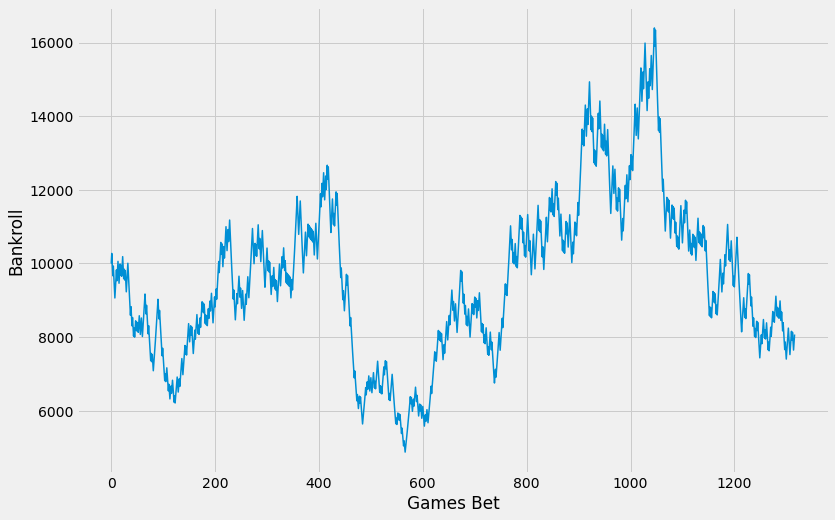

min balance: 4875.739831208471 
max balance: 16396.2152736751 
final balance: 7827.458065332492 
win percentage 52.769999999999996


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0         3  21700082  UTA vs. LAL         -6.5               56   
1         5  21700085  ATL vs. MIL          3.0               48   
2         9  21700089  SAC vs. WAS          4.0               32   
3        12  21700093  MIA vs. MIN          1.0               62   
4        13  21700094  NYK vs. DEN          2.0               65   
...     ...       ...          ...          ...              ...   
1312   3443  41900236  DEN vs. LAC          6.0               47   
1313   3457  41900402  LAL vs. MIA         -6.5               68   
1314   3458  41900403  MIA vs. LAL          6.0               58   
1315   3459  41900404  MIA vs. LAL          5.0               47   
1316   3461  41900406  MIA vs. LAL          3.5               36   

      team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                  45             11.0           1   0.544405   0.455595   
1                  61            -13.0           0   0.531358   0.468642   
2                  63            -31.0           0   0.550637   0.449363   
3                  60              2.0           1   0.606184   0.393816   
4                  43             22.0           1   0.469550   0.530450   
...               ...              ...         ...        ...        ...   
1312               63            -16.0           0   0.536238   0.463762   
1313               54             14.0           1   0.468507   0.531493   
1314               54              4.0           1   0.544920   0.455080   
1315               49             -2.0           1   0.540666   0.459334   
1316               64            -28.0           0   0.530662   0.469338   

      prob_avg  bet_home1  bet_home2  bet_home3    bankroll_i    bankroll_n  \
0     0.544405          1          1          1  10000.000000  10272.727273   
1     0.531358          1          1          1  10272.727273   9964.545455   
2     0.550637          1          1          1   9964.545455   9665.609091   
3     0.606184          1          1          1   9665.609091   9929.216612   
4     0.469550          0          0          0   9929.216612   9631.340113   
...        ...        ...        ...        ...           ...           ...   
1312  0.536238          1          1          1   8127.070556   7883.258440   
1313  0.468507          0          0          0   7883.258440   7646.760687   
1314  0.544920          1          1          1   7646.760687   7855.308705   
1315  0.540666          1          1          1   7855.308705   8069.544397   
1316  0.530662          1          1          1   8069.544397   7827.458065   

        bet_size  bet_won  
0     300.000000        1  
1     308.181818        0  
2     298.936364        0  
3     289.968273        1  
4     297.876498        0  
...          ...      ...  
1312  243.812117        0  
1313  236.497753        0  
1314  229.402821        1  
1315  235.659261        1  
1316  242.086332        0  

[1317 rows x 18 columns]

In [327]:
lr_probs = best_lr.predict_proba(X_test1)
select_bets_lr, bet_thresholds_lr = find_optimal_threshold(full_df_ewm_9, lr_probs, test_idx1)
simulate_bets(select_bets_lr)

In [171]:
bet_thresholds_lr.loc[bet_thresholds_lr['strategy'] ==3]
# bet_thresholds_lr
create_betting_df(df_19, lr_probs, test_idx1, 3)
bet_thresholds_lr.loc[0, 'strategy']

2

In [104]:
ex = X_test1.loc[28564:28565]
ex2 = ex.copy(deep=True)
ex2.iloc[0, -1] = -20
ex2.iloc[1, -1] = +20

print("old_spread:", ex.iloc[0, -1], "new:", ex2.iloc[0, -1])
print("old_spread:", ex.iloc[1, -1], "new:", ex2.iloc[1, -1])

print("old_pred:", best_lr.predict_proba(ex))
# print(best_lr.predict(ex))


print("new_pred:", best_lr.predict_proba(ex2))
# print(best_lr.predict(ex2))

ex

old_spread: -1.0 new: -20.0
old_spread: 1.0 new: 20.0
old_pred: [[0.43971163 0.56028837]
 [0.56020964 0.43979036]]
new_pred: [[0.5408872  0.4591128 ]
 [0.45903344 0.54096656]]


FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
28564      16.761691      30.424727       3.875412      11.952773   
28565      14.504408      27.836146       7.096701      16.378477   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
28564      9.177358     11.067959       3.257601      18.866255     22.123855   
28565      7.099729      8.840395       4.714342      18.012429     22.726771   

       AST_team_ewm  TOV_team_ewm  STL_team_ewm  BLK_team_ewm  BLKA_team_ewm  \
28564     11.311861      7.584088      1.850309      2.169935       2.015140   
28565     12.803570     10.359137      4.450758      3.965471       3.073014   

       PF_team_ewm  PFD_team_ewm  PTS_team_ewm  PLUS_MINUS_team_ewm  \
28564     6.613001     10.414715     54.326976             0.063881   
28565    11.046397      9.419892     57.398647            -0.413958   

       E_OFF_RATING_team_ewm  E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  \
28564             105.836746             105.691470               0.129254   
28565             106.541420             106.804823              -0.263403   

       POSS_team_ewm  PIE_team_ewm  PTS_2PT_MR_team_ewm  PTS_FB_team_ewm  \
28564      49.781422      0.531254             6.949061         3.966667   
28565      54.269249      0.499873             2.085444         7.425069   

       PTS_OFF_TOV_team_ewm  PTS_PAINT_team_ewm  AST_2PM_team_ewm  \
28564              6.653586           25.347928          7.280408   
28565              6.916168           25.767796          6.554736   

       AST_3PM_team_ewm  UAST_2PM_team_ewm  UAST_3PM_team_ewm  FG2M_opp_ewm  \
28564          3.655637           8.701057           0.000000     13.233230   
28565          5.446631           7.329662           1.092061     15.919196   

       FG2A_opp_ewm  FG3M_opp_ewm  FG3A_opp_ewm  FTM_opp_ewm  FTA_opp_ewm  \
28564     26.749066      7.468975     20.513931     5.389710     6.671485   
28565     33.226783      5.576274     13.763034     9.245391    11.099875   

       OREB_opp_ewm  DREB_opp_ewm  REB_opp_ewm  AST_opp_ewm  TOV_opp_ewm  \
28564      4.160216     15.877756    20.037972    13.081243     5.489194   
28565      6.843252     17.498205    24.341457    13.283436     9.072721   

       STL_opp_ewm  PF_opp_ewm  PFD_opp_ewm  PTS_opp_ewm  PLUS_MINUS_opp_ewm  \
28564     3.846866   10.414715     6.613001    54.263095           -0.063881   
28565     4.727943    9.419892    11.046397    57.812605            0.413958   

       E_NET_RATING_opp_ewm  POSS_opp_ewm  PIE_opp_ewm  PTS_2PT_MR_opp_ewm  \
28564             -0.129254     50.029792     0.468746            7.067691   
28565              0.263403     54.649239     0.500127            6.753510   

       PTS_FB_opp_ewm  PTS_OFF_TOV_opp_ewm  PTS_PAINT_opp_ewm  \
28564        3.599057             7.249127          18.357012   
28565        7.927645             9.670997          24.018705   

       AST_2PM_opp_ewm  AST_3PM_opp_ewm  UAST_2PM_opp_ewm  UAST_3PM_opp_ewm  \
28564         6.602208         5.879270          5.828820          1.369930   
28565         8.557007         4.304217          6.559986          1.094039   

       RECORD_opp_ewm  team_covered_opp_ewm  WL_record_ewm  ATS_record_ewm  \
28564        0.441992              0.661767            0.6             0.4   
28565        0.558008              0.404410            0.4             0.6   

       OREB_PCT_team_ewm  OREB_PCT_opp_ewm  DREB_PCT_team_ewm  \
28564           0.170240          0.180671           0.819329   
28565           0.212238          0.275319           0.724681   

       DREB_PCT_opp_ewm  REB_PCT_team_ewm  REB_PCT_opp_ewm  TS_PCT_team_ewm  \
28564          0.829760          0.524737         0.475263         0.606159   
28565          0.787762          0.482847         0.517153         0.621742   

       TS_PCT_opp_ewm  EFG_PCT_team_ewm  EFG_PCT_opp_ewm  AST_RATIO_team_ewm  \
28564        0.556765          0.532707         0.517036           22.

<AxesSubplot:ylabel='feature'>

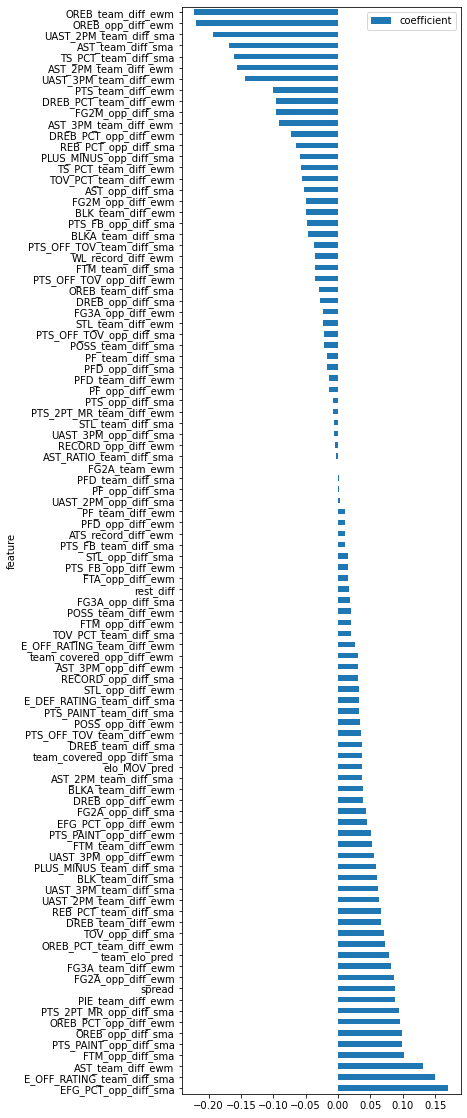

In [105]:
features = X_train1.columns
logistic_coefs = best_lr.named_steps['logreg'].coef_[0]
coef_df = pd.DataFrame({'feature':features,
                       'coefficient':logistic_coefs})


coef_df.loc[coef_df['coefficient']!=0].sort_values('coefficient', ascending=False).plot.barh(x = 'feature', 
                                                                                             figsize=(5,20))


### SGD

In [106]:
sgd_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(loss='log',
                               max_iter=2500, penalty='l1'))])

sgd_pipe.fit(X_train1, cover_train1)
preds_train_sgd = sgd_pipe.predict(X_train1)   
preds_test_sgd = sgd_pipe.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_sgd)
test_acc = accuracy_score(cover_test1, preds_test_sgd)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

train_acc: 0.5228571428571429 test_acc: 0.5030329289428076


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.7s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.5s finished


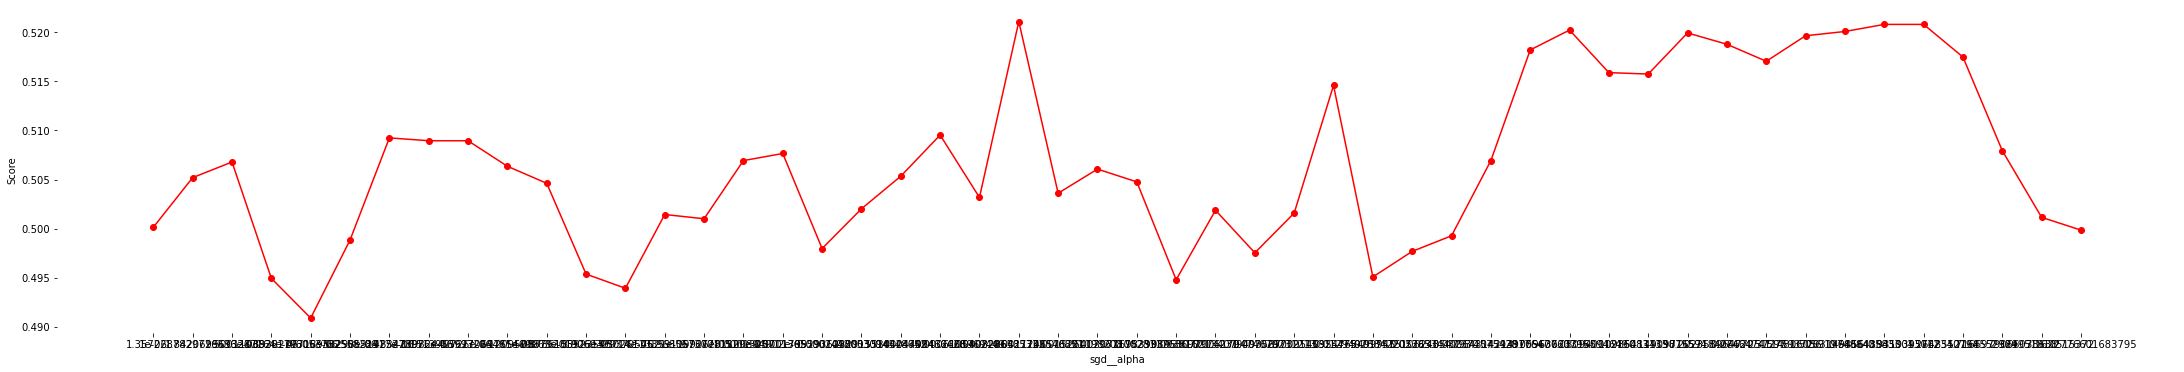

Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.0008286427728546851, loss='log',
                               random_state=23))]) 0.5210860774119006


In [109]:
# X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)


sgd_pipe = Pipeline([('scaler',StandardScaler()),
                          ('sgd', SGDClassifier(max_iter=1000, loss='log', penalty='l1',
                                                random_state=23))])
grid = {
        'sgd__alpha':np.logspace(-6, 0.5, 50)}

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(sgd_pipe, param_grid,
                                                            X_train1, cover_train1, 
                                                            X_test1, cover_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)



In [321]:
sgd_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=2.5001103826179306e-06, loss='log',
                               penalty='l1', random_state=23))])

sgd_pipe.fit(X_train1, cover_train1)
preds_train_sgd = sgd_pipe.predict(X_train1)   
preds_test_sgd = sgd_pipe.predict(X_test1)
probs_test_sgd = sgd_pipe.predict_proba(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_sgd)
test_acc = accuracy_score(cover_test1, preds_test_sgd)

print("train_acc:", train_acc,
     "test_acc:", test_acc)


train_acc: 0.5114688128772635 test_acc: 0.5216637781629117


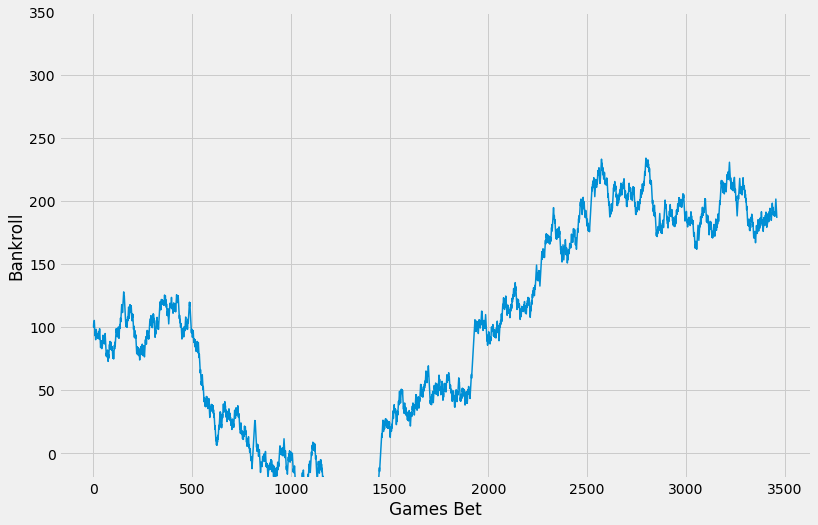

min balance: -67.45454545454389 
max balance: 233.90909090909088 
final balance: 189.18181818181552 
win percentage 52.83 
profit: 89.18181818181802 risk: 10386.0 
ROI: 0.86


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0         0  21700077  NOP vs. CLE          1.0               65   
1         1  21700080  MEM vs. HOU         -1.0               54   
2         2  21700081  DAL vs. PHI          0.5               56   
3         3  21700082  UTA vs. LAL         -6.5               56   
4         4  21700083  POR vs. PHX         -6.5               61   
...     ...       ...          ...          ...              ...   
3457   3457  41900402  LAL vs. MIA         -6.5               68   
3458   3458  41900403  MIA vs. LAL          6.0               58   
3459   3459  41900404  MIA vs. LAL          5.0               47   
3460   3460  41900405  LAL vs. MIA         -4.0               56   
3461   3461  41900406  MIA vs. LAL          3.5               36   

      team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                  52             13.0           1   0.999939   0.224530   
1                  49              5.0           1   0.842608   1.000000   
2                  57             -1.0           0   0.045529   0.999879   
3                  45             11.0           1   1.000000   0.311640   
4                  57              4.0           0   0.825590   0.000018   
...               ...              ...         ...        ...        ...   
3457               54             14.0           1   0.912103   0.994136   
3458               54              4.0           1   0.855055   0.992936   
3459               49             -2.0           1   0.042330   0.999755   
3460               60             -4.0           0   0.999996   0.011319   
3461               64            -28.0           0   0.391265   0.999571   

      prob_avg  bet_home1  bet_home2  bet_home3  bankroll_i  bankroll_n  \
0     0.887705          1          1          1  100.000000  102.727273   
1     0.421304          1          0          0  102.727273   99.727273   
2     0.022825          0          0          0   99.727273  102.454545   
3     0.844180          1          1          1  102.454545  105.181818   
4     0.912786          1          1          1  105.181818  102.181818   
...        ...        ...        ...        ...         ...         ...   
3457  0.458983          1          0          0  198.454545  195.454545   
3458  0.431060          1          0          0  195.454545  192.454545   
3459  0.021288          0          0          0  192.454545  189.454545   
3460  0.994339          1          1          1  189.454545  186.454545   
3461  0.195847          0          0          0  186.454545  189.181818   

      bet_size  bet_won  
0          3.0        1  
1          3.0        0  
2          3.0        1  
3          3.0        1  
4          3.0        0  
...        ...      ...  
3457       3.0        0  
3458       3.0        0  
3459       3.0        0  
3460       3.0        0  
3461       3.0        1  

[3462 rows x 18 columns]

In [113]:
sgd_bets = create_betting_df(full_df_combined, probs_test_sgd, test_idx1, 3)
simulate_bets_1(sgd_bets, unit_size=3)
# simulate_bets_kelly(sgd_bets)
# sgd_bets['bet_won'].mean()
# # sgd_bets

In [148]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)

scaler = StandardScaler()

X_train_sc  = scaler.fit_transform(X_train1)
X_test_sc = scaler.transform(X_test1)

sgd_lr = SGDClassifier(alpha=2.5001103826179306e-06, loss='log',
                               penalty='l1', random_state=23)


rfecv_lr = RFECV(sgd_lr, cv=tscv, scoring='accuracy')




RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
      estimator=SGDClassifier(alpha=2.5001103826179306e-06, loss='log',
                              penalty='l1', random_state=23),
      scoring='accuracy')

In [155]:
rfecv_lr.fit(X_train_sc, cover_train1)


features_mask_lr = rfecv_lr.support_

best_sgd_svm.fit(X_train1.iloc[:, features_mask_lr], cover_train1)
sgd_svm_preds_train = best_sgd_svm.predict(X_train1.iloc[:, features_mask_lr])

sgd_svm_preds_test = best_sgd_svm.predict(X_test1.iloc[:, features_mask_lr])
print(accuracy_score(cover_train1, sgd_svm_preds_train))
print(accuracy_score(cover_test1, sgd_svm_preds_test))

print(confusion_matrix(cover_test1, sgd_svm_preds_test))

0.5204426559356137
0.5145869439630272
[[1724 1738]
 [1623 1839]]


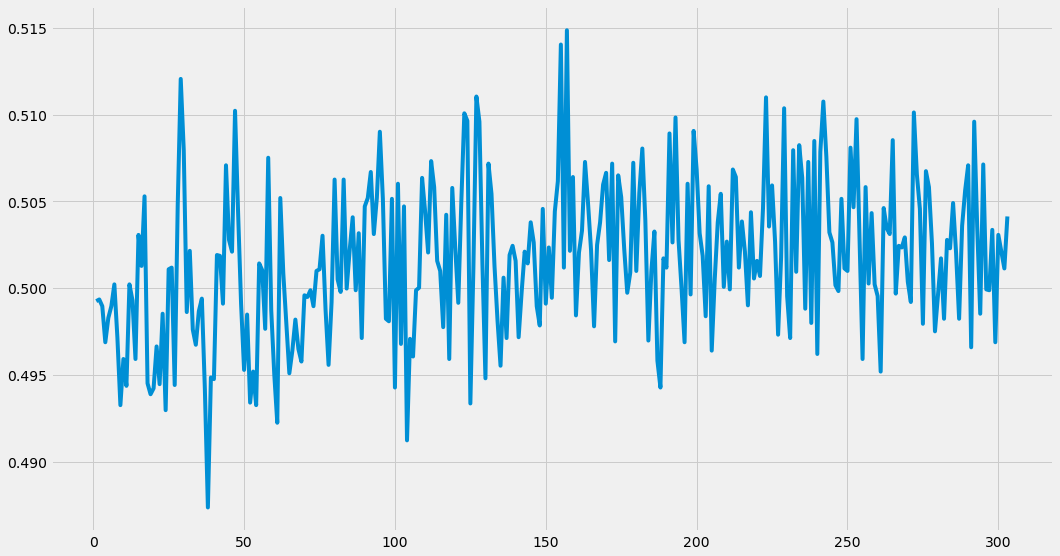

In [164]:
plt.figure(figsize=(16,9))
plt.plot(range(1, len(rfecv_lr.grid_scores_)+1), rfecv_lr.grid_scores_)

In [157]:
X_train1.iloc[:, features_mask_lr]

FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  FTM_team_ewm  \
150        29.683866       1.865937       5.853899      8.240605   
151        35.902615       2.518229       7.054724      5.409611   
156        30.049742       2.331225       6.385485     11.590950   
157        28.255452       4.040023       9.304779     10.890894   
158        37.570975       2.318893       6.383092      8.105028   
...              ...            ...            ...           ...   
28407      26.240134       6.913866      16.587010      9.555997   
28408      29.249894       6.766958      16.272068      7.893058   
28409      25.916110       6.722473      16.728314     10.000412   
28410      25.724494       7.350244      17.255498     10.700391   
28411      29.124900       6.690260      16.244860      8.503772   

       FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  AST_team_ewm  \
150       13.531367       5.635149      14.545237     20.180386     11.058948   
151        8.130033       7.012527      17.679886     24.692413     11.863276   
156       16.485654       4.353838      16.568973     20.922810      9.400527   
157       14.867793       7.073454      15.231692     22.305145      9.750849   
158       11.381505       8.776684      15.510952     24.287636     11.378526   
...             ...            ...            ...           ...           ...   
28407     11.839105       4.193624      18.419891     22.613515     12.561225   
28408      9.937359       4.749156      18.056017     22.805172     16.626294   
28409     12.355211       3.974254      17.877884     21.852139     11.905081   
28410     13.719730       4.276838      17.390081     21.666919     12.514591   
28411     10.743649       4.974248      17.250388     22.224636     16.663666   

       TOV_team_ewm  STL_team_ewm  BLK_team_ewm  BLKA_team_ewm  PF_team_ewm  \
150       11.259798      3.731460      2.309174       1.125736    11.674074   
151       10.496740      4.282630      2.384337       3.060633    11.745330   
156       10.212376      3.345755      1.596786       1.975825    12.085810   
157        8.558912      4.863471      1.604405       2.066177    12.967058   
158        8.582672      3.980000      1.630070       3.048131    11.757515   
...             ...           ...           ...            ...          ...   
28407      7.423562      3.964638      2.474170       2.260991     8.229057   
28408      8.093800      4.947909      2.993926       2.387599    10.619272   
28409      7.581211      4.068178      2.426752       2.134888     8.506160   
28410      7.223079      4.161363      2.184070       2.321405     8.855555   
28411      8.184423      4.553105      3.094537       2.148831    11.357369   

       PFD_team_ewm  PTS_team_ewm  PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  \
150       11.483260     47.957876            -0.690874             101.700105   
151        9.906522     46.557813            -0.961661              93.218803   
156       13.353838     43.645845            -6.778711              87.986347   
157       11.745403     46.865962             2.899270             103.620388   
158       11.480648     52.038143             6.427511             106.959579   
...             ...           ...                  ...                    ...   
28407     10.356659     59.540355             5.862437             116.463388   
28408      9.425595     60.819005             6.748616             114.249501   
28409     10.721005     59.686324             4.676154             115.807027   
28410     11.448926     62.317770             6.008578             120.026449   
28411      9.683044     61.537128             4.273673             115.434590   

       E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  POSS_team_ewm  \
150               101.432297               0.267808      46.685453   
151                93.525518              -0.284738      49.423067   
156                99.275468             -11.249342      49.006276   
157            

### Linear SVM with SGD

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


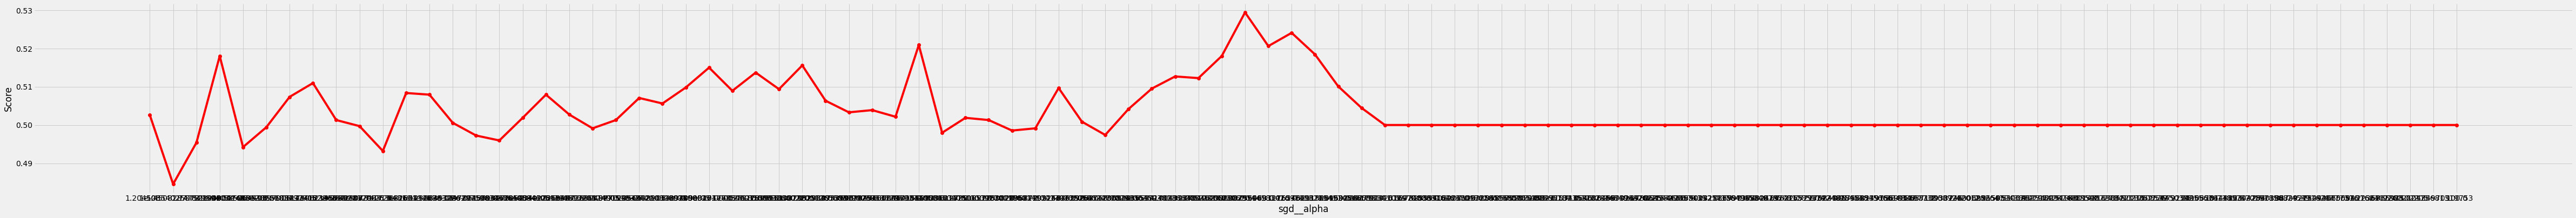

Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.00628029144183426, penalty='l1',
                               random_state=23))]) 0.5294627383015598


In [114]:
sgd_pipe = Pipeline([('scaler',StandardScaler()),
                          ('sgd', SGDClassifier(max_iter=1000, loss='hinge', penalty='l1',
                                                random_state=23))])
grid = {
        'sgd__alpha':np.logspace(-6, 2, 100)}

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(sgd_pipe, param_grid,
                                                            X_train1, cover_train1, 
                                                            X_test1, cover_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)
# sgd_cv.fit(X_train1, cover_train1)

# best_sgd = sgd_cv.best_estimator_
# print("best_sgd:", best_sgd)

# sgd_preds_train = best_sgd.predict(X_train1)
# sgd_preds_test = best_sgd.predict(X_test1)

# print(accuracy_score(cover_train1, sgd_preds_train))
# print(accuracy_score(cover_test1, sgd_preds_test))

# print(confusion_matrix(cover_test1, sgd_preds_test))

# select_bets_sgd, bet_thresholds_sgd = find_optimal_threshold(df_19, sgd_probs, test_idx1)
# simulate_bets(select_bets_sgd)


In [322]:

best_sgd_svm = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.00628029144183426, penalty='l1',
                              random_state=23))])

best_sgd_svm.fit(X_train1, cover_train1)

sgd_svm_preds_train = best_sgd_svm.predict(X_train1)

sgd_svm_preds_test = best_sgd_svm.predict(X_test1)
print(accuracy_score(cover_train1, sgd_svm_preds_train))
print(accuracy_score(cover_test1, sgd_svm_preds_test))

print(confusion_matrix(cover_test1, sgd_svm_preds_test))


0.5281287726358149
0.5294627383015598
[[1707 1755]
 [1503 1959]]


In [147]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)

scaler = StandardScaler()

X_train_sc  = scaler.fit_transform(X_train1)
X_test_sc = scaler.transform(X_test1)

sgd = SGDClassifier(alpha=0.00628029144183426, penalty='l1',
                              random_state=23)


rfecv = RFECV(sgd, cv=tscv, scoring='accuracy')


rfecv.fit(X_train_sc, cover_train1)

RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
      estimator=SGDClassifier(alpha=0.00628029144183426, penalty='l1',
                              random_state=23),
      scoring='accuracy')

In [154]:
best_sgd_svm = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.00628029144183426, penalty='l1',
                              random_state=23))])

features_mask_svm = rfecv.support_

best_sgd_svm.fit(X_train1.iloc[:, features_mask_svm], cover_train1)
sgd_svm_preds_train = best_sgd_svm.predict(X_train1.iloc[:, features_mask_svm])

sgd_svm_preds_test = best_sgd_svm.predict(X_test1.iloc[:, features_mask_svm])
print(accuracy_score(cover_train1, sgd_svm_preds_train))
print(accuracy_score(cover_test1, sgd_svm_preds_test))

print(confusion_matrix(cover_test1, sgd_svm_preds_test))

0.5212474849094567
0.5271519352975159
[[1788 1674]
 [1600 1862]]


In [159]:
X_train1.iloc[:, features_mask_svm]

FG3A_opp_diff_ewm  FTM_opp_diff_ewm  FTA_opp_diff_ewm  \
150            -0.207321          0.290909         -1.501013   
151             0.207321         -0.290909          1.501013   
156             1.309907         -1.749481         -2.153256   
157            -1.309907          1.749481          2.153256   
158             6.593539         -0.455642          0.603038   
...                  ...               ...               ...   
28407           1.392945         -1.175702         -1.605146   
28408          -1.453651          1.558146          2.244654   
28409           1.453651         -1.558146         -2.244654   
28410           0.708261         -1.702338         -2.820210   
28411          -0.708261          1.702338          2.820210   

       OREB_opp_diff_ewm  DREB_opp_diff_ewm  REB_opp_diff_ewm  \
150            -0.782545          -5.024835         -5.807380   
151             0.782545           5.024835          5.807380   
156            -0.910332           4.116798          3.206466   
157             0.910332          -4.116798         -3.206466   
158            -2.651144           1.423115         -1.228029   
...                  ...                ...               ...   
28407          -0.652077          -1.184208         -1.836285   
28408           0.386859           0.565766          0.952625   
28409          -0.386859          -0.565766         -0.952625   
28410          -0.348172          -0.809196         -1.157368   
28411           0.348172           0.809196          1.157368   

       AST_opp_diff_ewm  TOV_opp_diff_ewm  STL_opp_diff_ewm  PF_opp_diff_ewm  \
150            0.073698          0.436351          0.751557         1.576738   
151           -0.073698         -0.436351         -0.751557        -1.576738   
156            1.957193         -0.897414          2.365974         1.608434   
157           -1.957193          0.897414         -2.365974        -1.608434   
158           -0.012088          1.550267         -0.022979         2.411077   
...                 ...               ...               ...              ...   
28407          2.556484         -1.081783         -1.078355         1.106006   
28408         -3.800878          0.673592          0.770509        -1.295411   
28409          3.800878         -0.673592         -0.770509         1.295411   
28410          3.320774         -0.106215         -1.093468         1.765883   
28411         -3.320774          0.106215          1.093468        -1.765883   

       PFD_opp_diff_ewm  PTS_opp_diff_ewm  PLUS_MINUS_opp_diff_ewm  \
150           -0.071256          1.129276                -0.270787   
151            0.071256         -1.129276                 0.270787   
156           -0.881248          6.457864                 9.677981   
157            0.881248         -6.457864                -9.677981   
158            0.056873         -3.109814                -8.675881   
...                 ...               ...                      ...   
28407         -2.014564          0.377517                 0.969362   
28408          2.113112         -0.939781                -2.072462   
28409         -2.113112          0.939781                 2.072462   
28410         -2.501815         -0.954263                -1.734905   
28411          2.501815          0.954263                 1.734905   

       E_NET_RATING_opp_diff_ewm  POSS_opp_diff_ewm  PIE_opp_diff_ewm  \
150                    -0.552546          -3.041367          0.041510   
151                     0.552546           3.041367         -0.041510   
156                    17.959515           3.742180          0.137851   
157                   -17.959515          -3.742180         -0.137851   
158                   -19.605885           2.297331         -0.124784   
...                          ...                ...               ...   
28407                   0.873873          -1.021178          0.008689   
28408                  -2.326531           1.019061         -0.028821  

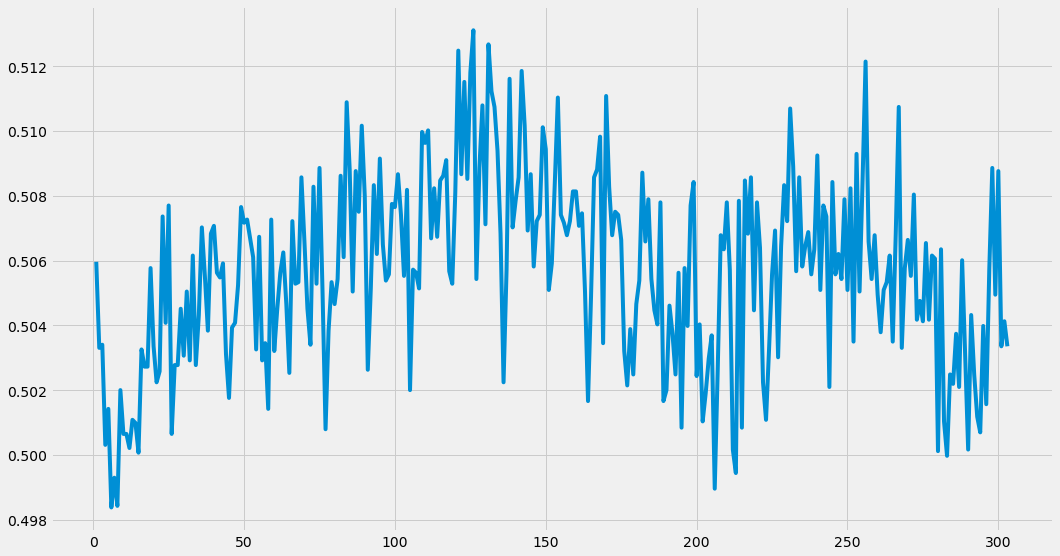

In [163]:
plt.figure(figsize=(16,9))
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)

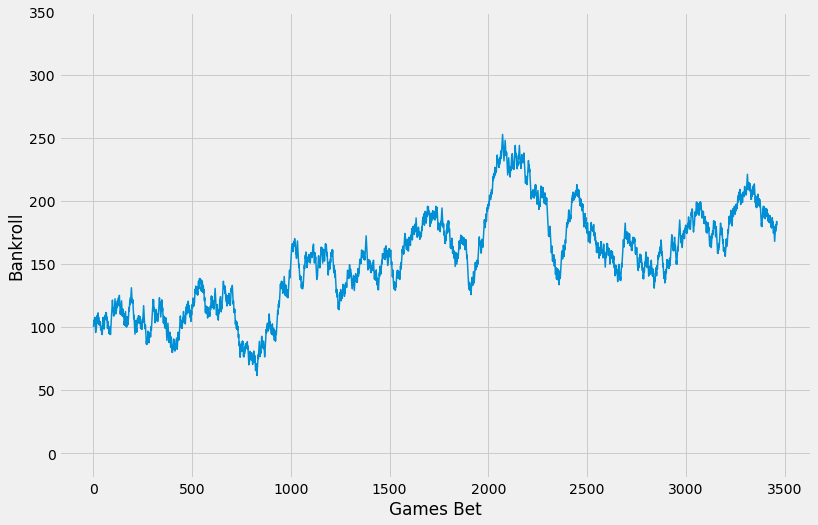

min balance: 61.545454545456764 
max balance: 252.72727272727101 
final balance: 183.4545454545382 
win percentage 52.800000000000004 
profit: 83.45454545454504 risk: 10386.0 
ROI: 0.8


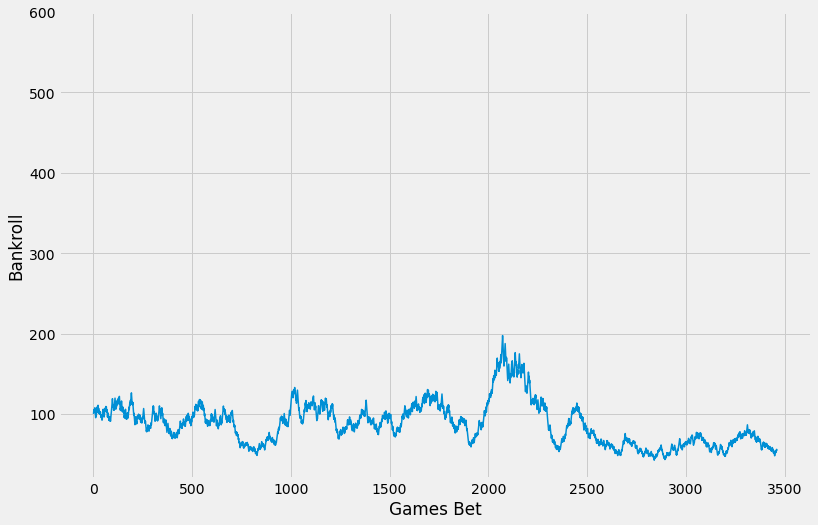

min balance: 42.49748567247735 
max balance: 197.43682260523215 
final balance: 55.79303794520553 
win percentage 52.800000000000004 
profit: -44.20696205479453 risk: 9103.80758181254 
ROI: -0.49


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0         0  21700077  NOP vs. CLE          1.0               65   
1         1  21700080  MEM vs. HOU         -1.0               54   
2         2  21700081  DAL vs. PHI          0.5               56   
3         3  21700082  UTA vs. LAL         -6.5               56   
4         4  21700083  POR vs. PHX         -6.5               61   
...     ...       ...          ...          ...              ...   
3457   3457  41900402  LAL vs. MIA         -6.5               68   
3458   3458  41900403  MIA vs. LAL          6.0               58   
3459   3459  41900404  MIA vs. LAL          5.0               47   
3460   3460  41900405  LAL vs. MIA         -4.0               56   
3461   3461  41900406  MIA vs. LAL          3.5               36   

      team_score_away  point_diff_home  cover_home  pred_home  bet_won  \
0                  52             13.0           1          1        1   
1                  49              5.0           1          1        1   
2                  57             -1.0           0          1        0   
3                  45             11.0           1          1        1   
4                  57              4.0           0          1        0   
...               ...              ...         ...        ...      ...   
3457               54             14.0           1          0        0   
3458               54              4.0           1          1        1   
3459               49             -2.0           1          1        1   
3460               60             -4.0           0          1        0   
3461               64            -28.0           0          0        1   

      bankroll_i  bankroll_n  bet_size  
0     100.000000  102.727273  3.000000  
1     102.727273  105.528926  3.081818  
2     105.528926  102.363058  3.165868  
3     102.363058  105.154778  3.070892  
4     105.154778  102.000134  3.154643  
...          ...         ...       ...  
3457   54.698985   53.058015  1.640970  
3458   53.058015   54.505052  1.591740  
3459   54.505052   55.991553  1.635152  
3460   55.991553   54.311807  1.679747  
3461   54.311807   55.793038  1.629354  

[3462 rows x 13 columns]

In [116]:
sgd_svm_bets = create_betting_df_with_preds(full_df_combined, sgd_svm_preds_test, test_idx1)
simulate_bets_1(sgd_svm_bets, unit_size=3)
sgd_svm_bets['bet_won'].mean()

simulate_bets_2(sgd_svm_bets, unit_pct=0.03)

<AxesSubplot:ylabel='feature'>

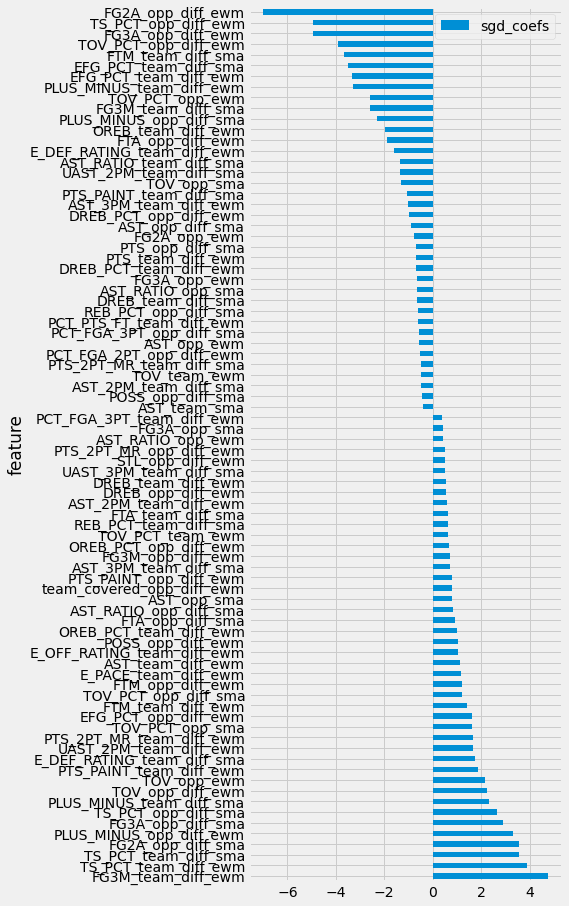

In [1002]:
feature_names = X_train1.columns
sgd_coefs = best_sgd.named_steps['sgd'].coef_[0]

coef_df_sgd = pd.DataFrame({'feature':feature_names,
                       'sgd_coefs':sgd_coefs
                           })
coef_df_sgd.loc[abs(coef_df_sgd['sgd_coefs'])>0.4].sort_values('sgd_coefs', ascending=False).plot.barh(figsize=(5,15),
                                                                                                           x='feature')

In [996]:
best_sgd = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(
                               epsilon=2.782559402207126, penalty='l1',
                               l1_ratio=0.6735612574911102, max_iter=1000, shuffle=False))])
params = {
    'sgd__loss': ['modified_huber', 'perceptron'],
    'sgd__alpha':np.logspace(-5, 2, 20)
}

sgd_cv = GridSearchCV(best_sgd, param_grid=params, scoring='accuracy', cv=tscv, n_jobs=-1, verbose=2)

sgd_cv.fit(X_train1, cover_train1)

print(sgd_cv.best_estimator_)

best_sgd = sgd_cv.best_estimator_


sgd_preds = best_sgd.predict(X_test1)
# sgd_probs = best_sgd.predict_proba(X_test1)

print(accuracy_score(cover_test1, sgd_preds))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.1min finished


Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=1e-05, epsilon=2.782559402207126,
                               l1_ratio=0.6735612574911102, loss='perceptron',
                               penalty='l1', shuffle=False))])
0.5014442518775274


In [993]:
print(accuracy_score(cover_test1, sgd_preds))


0.5018775274407856


In [45]:
sgd_probs = best_sgd.predict_proba(X_test1)
sgd_probs
# bet_df_sgd = create_betting_df(df_ewm_9_diffs, sgd_preds, test_idx1)
# simulate_bets(bet_df_sgd)

array([[0.48692677, 0.51307323],
       [0.51316886, 0.48683114],
       [0.51790843, 0.48209157],
       ...,
       [0.50300115, 0.49699885],
       [0.51426938, 0.48573062],
       [0.48545597, 0.51454403]])

In [ ]:
full_df_combined

best_sgd: Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.018329807108324356,
                               epsilon=0.6951927961775606, loss='log',
                               max_iter=10000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 2
best threshold: 0.535
num_games_bet: 1931
win percetange at threshold: 0.525116519937856


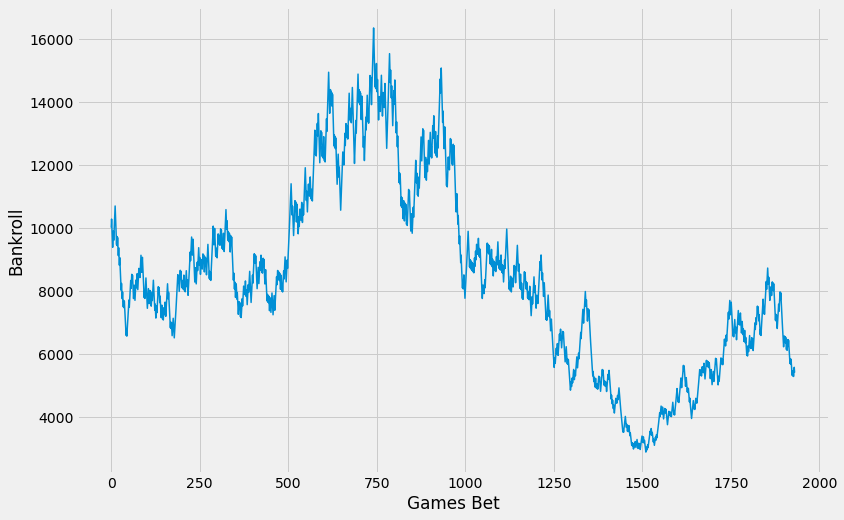

min balance: 2872.4832704852474 
max balance: 16341.531784301758 
final balance: 5236.477766331764 
win percentage 52.51


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0         0  21400073  PHI vs. CHI         10.0  5.500000  1.166667   
1         2  21400078  OKC vs. MEM          7.0  3.600000  1.307692   
2         3  21400079  PHX vs. SAC         -5.0  1.487805  2.750000   
3         4  21400080  UTA vs. DAL          3.0  2.300000  1.666667   
4         5  21400082  LAC vs. POR         -4.5  1.526316  2.650000   
...     ...       ...          ...          ...       ...       ...   
1926   3666  41600305  BOS vs. CLE         10.0  4.900000  1.172414   
1927   3668  41600402  GSW vs. CLE         -9.0  1.250000  4.300000   
1928   3669  41600403  CLE vs. GSW          3.0  2.200000  1.666667   
1929   3670  41600404  CLE vs. GSW          5.0  2.650000  1.526316   
1930   3671  41600405  GSW vs. CLE         -9.5  1.250000  3.600000   

      team_score_home  team_score_away  point_diff_home  cover_home  \
0                 115              118               -3           1   
1                  89               91               -2           1   
2                 112              114               -2           0   
3                  82              105              -23           0   
4                 106              102                4           0   
...               ...              ...              ...         ...   
1926              102              135              -33           0   
1927              132              113               19           1   
1928              113              118               -5           0   
1929              137              116               21           1   
1930              129              120                9           0   

      prob_home  prob_away  prob_avg  bet_home1  bet_home2  bet_home3  \
0      0.545720   0.469778  0.537971          1          1          1   
1      0.357353   0.657799  0.349777          0          0          0   
2      0.597032   0.324918  0.636057          1          1          1   
3      0.634946   0.383194  0.625876          1          1          1   
4      0.385207   0.573659  0.405774          0          0          0   
...         ...        ...       ...        ...        ...        ...   
1926   0.584923   0.459304  0.562810          1          1          1   
1927   0.543721   0.439739  0.551991          1          1          1   
1928   0.434251   0.564084  0.435084          0          0          0   
1929   0.450197   0.560030  0.445084          0          0          0   
1930   0.576223   0.443243  0.566490          1          1          1   

        bankroll_i    bankroll_n    bet_size  bet_won  
0     10000.000000  10272.727273  300.000000        1  
1     10272.727273   9964.545455  308.181818        0  
2      9964.545455   9665.609091  298.936364        0  
3      9665.609091   9375.640818  289.968273        0  
4      9375.640818   9631.340113  281.269225        1  
...            ...           ...         ...      ...  
1926   5436.915014   5273.807563  163.107450        0  
1927   5273.807563   5417.638679  158.214227        1  
1928   5417.638679   5565.392461  162.529160        1  
1929   5565.392461   5398.430687  166.961774        0  
1930   5398.430687   5236.477766  161.952921        0  

[1931 rows x 20 columns]

In [213]:
sgd_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha=0.018329807108324356,
                                      epsilon=0.6951927961775606,
                               max_iter=10000))])

params = {
    'sgd__loss': ['log', 'modified_huber',
    'squared_hinge', 'perceptron']
}

sgd_cv = GridSearchCV(sgd_pipe, param_grid=params, scoring='accuracy', cv=tscv, n_jobs=-1)


sgd_cv.fit(X_train1, cover_train1)

best_sgd = sgd_cv.best_estimator_
print("best_sgd:", best_sgd)

sgd_probs = best_sgd.predict_proba(X_test1)

select_bets_sgd, bet_thresholds_sgd = find_optimal_threshold(df_19, sgd_probs, test_idx1)
simulate_bets(select_bets_sgd)


<AxesSubplot:ylabel='feature'>

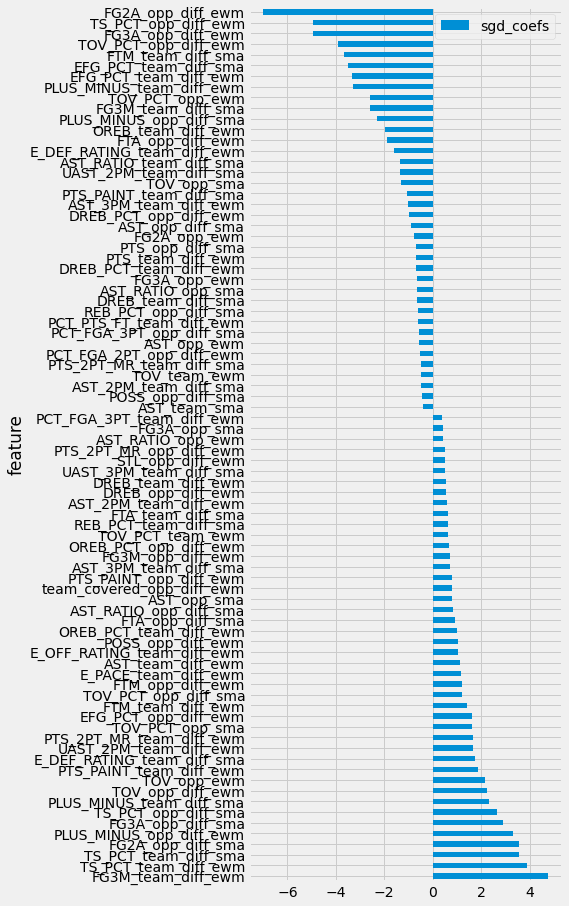

In [1001]:
feature_names = X_train1.columns
sgd_coefs = best_sgd.named_steps['sgd'].coef_[0]

coef_df_sgd = pd.DataFrame({'feature':feature_names,
                       'sgd_coefs':sgd_coefs
                           })
coef_df_sgd.loc[abs(coef_df_sgd['sgd_coefs'])>0.4].sort_values('sgd_coefs', ascending=False).plot.barh(figsize=(5,15),
                                                                                                           x='feature')

#### SGD RFE

In [867]:
scaler = StandardScaler()
X_train1_sc = scaler.fit_transform(X_train1)
X_test1_sc = scaler.transform(X_test1)

best_sgd_diff= SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                              l1_ratio=1.0, loss='huber', max_iter=5000,
                              penalty='elasticnet')

rfe_sgd = RFECV(best_sgd_diff, cv=tscv, scoring='neg_mean_absolute_error')
rfe_sgd.fit(X_train1_sc, point_diff_train1)


RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
      estimator=SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                             l1_ratio=1.0, loss='huber', max_iter=5000,
                             penalty='elasticnet'),
      scoring='neg_mean_absolute_error')

mae_diff_sgd_reduced: 13.483472170841289


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 1.25
best prediction strat: 2
num_games_bet: 454
win percetange at threshold: 0.5440528634361234


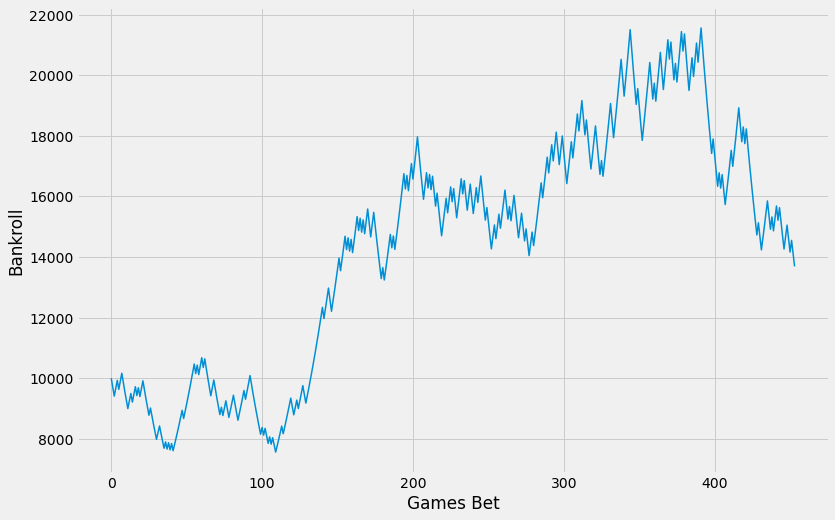

min balance: 7560.705293314098 
max balance: 21564.898338453335 
final balance: 14064.726761039305 
win percentage 54.410000000000004


index   GAME_ID MATCHUP_home  spread_home   ml_home  ml_away  \
0       11  21600096  CHI vs. ORL         -7.0  1.333333     3.40   
1       12  21600097  OKC vs. MIA         -5.5  1.425532     2.95   
2       14  21600099  GSW vs. NOP        -16.5  1.020000    14.00   
3       18  21600104  LAL vs. DAL         -4.0  1.571429     2.55   
4       20  21600106  NYK vs. BKN         -8.0  1.277778     3.80   
..     ...       ...          ...          ...       ...      ...   
449   2440  41700313  GSW vs. HOU         -7.5  1.250000     3.85   
450   2442  41700314  GSW vs. HOU         -7.5  1.232558     4.40   
451   2445  41700306  CLE vs. BOS         -7.0  1.322581     3.50   
452   2446  41700316  GSW vs. HOU        -12.5  1.094340     6.50   
453   2449  41700401  GSW vs. CLE        -13.0  1.100000     7.20   

     team_score_home  team_score_away  point_diff_home  cover_home  \
0                112               80               32           1   
1                 97               85               12           1   
2                116              106               10           0   
3                 97              109              -12           0   
4                110               96               14           1   
..               ...              ...              ...         ...   
449              126               85               41           1   
450               92               95               -3           0   
451              109               99               10           1   
452              115               86               29           1   
453              124              114               10           0   

     score_pred_home  score_pred_away  score_pred_diff  diff_preds_home  \
0         100.075529       105.306658        -5.231129         5.235371   
1         101.156827       101.580772        -0.423945         4.211420   
2         102.447470       105.595805        -3.148336        14.129172   
3         105.568476       101.949743         3.618733         1.200852   
4         104.692782       110.632741        -5.939959         6.739925   
..               ...              ...              ...              ...   
449       104.091055       107.778061        -3.687006         5.412862   
450       101.102738       108.105243        -7.002505         5.846622   
451        97.901593        99.727420        -1.825827         5.531878   
452        98.246613       106.274410        -8.027797         9.869949   
453        97.112530       104.877126        -7.764596        11.569969   

     diff_preds_away  point_diff_avg  bet_home1  bet_home2  bet_home3  \
0          -5.470670        5.353020          0          0          0   
1          -4.503992        4.357706          0          0          0   
2         -14.789008       14.459090          0          0          0   
3          -1.572029        1.386440          0          0          0   
4          -7.189000        6.964463          0          0          0   
..               ...             ...        ...        ...        ...   
449        -6.190781        5.801822          0          0          0   
450        -6.688231        6.267426          0          0          0   
451        -6.075165        5.803521          0          0          0   
452       -10.782762       10.326356          0          0          0   
453       -12.436212       12.003090          0          0          0   

     bet_home4  confidence_pred1  confidence_pred2  confidence_pred3  \
0            0        -12.231129         -1.764629         -1.529330   
1            0         -5.923945         -1.288580         -0.996008   
2            0        -19.648336         -2.370828         -1.710992   
3            0         -0.381267         -2.799148         -2.427971   
4            0        -13.939959         -1.260075         -0.811000   
..         ...               ...               ...               ...   
449          0        -11.187006         -2.087138   

In [872]:
best_sgd_diff_reduced = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                              l1_ratio=1.0, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])

best_sgd_diff_reduced.fit(X_train1.loc[:, rfe_sgd.support_], point_diff_train1)


diff_preds_sgd_reduced = best_sgd_diff_reduced.predict(X_test1.loc[:, rfe_sgd.support_])

mae_diff = mean_absolute_error(point_diff_test1, diff_preds)

print("mae_diff_sgd_reduced:", mae_diff)

select_bets_sgd, bet_thresholds_lr_sgd = find_optimal_confidence_thresholds(diff_preds_sgd_reduced, sgd_preds_score, test_idx1)
simulate_bets(select_bets_sgd)

<AxesSubplot:ylabel='feature'>

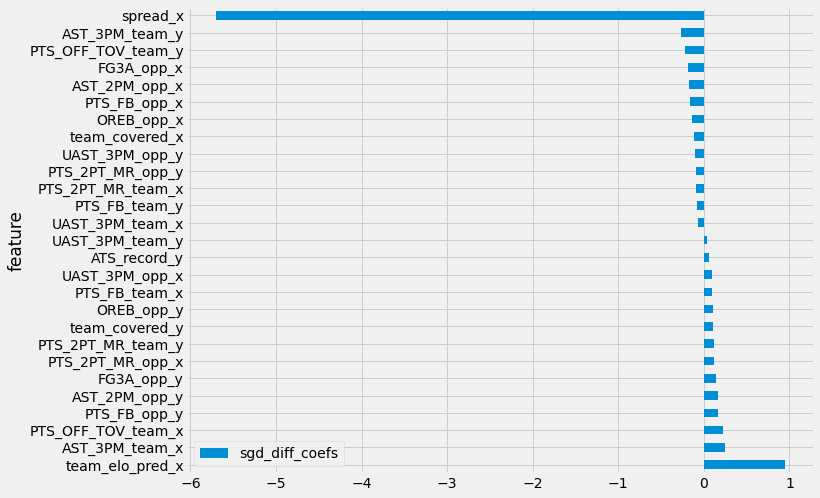

In [874]:
feature_names = X_train1.loc[:, rfe_sgd.support_].columns
sgd_diff_coefs = best_sgd_diff_reduced.named_steps['sgdregressor'].coef_

coef_df_sgd = pd.DataFrame({'feature':feature_names,
                       'sgd_diff_coefs':sgd_diff_coefs})

coef_df_sgd.loc[coef_df_sgd['sgd_diff_coefs']!=0].sort_values('sgd_diff_coefs', ascending=False).plot.barh(figsize=(10,8), x='feature')

mae_diff: 9.933691663701811


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


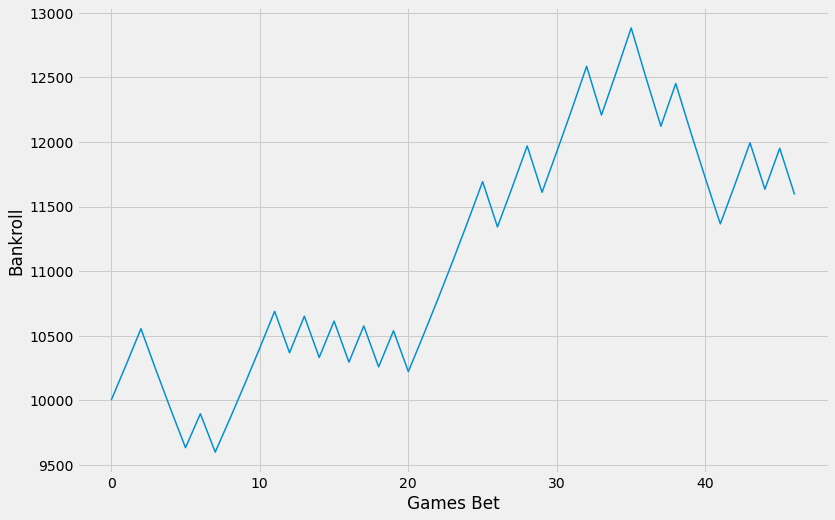

min balance: 9597.192634639892 
max balance: 12883.481930176657 
final balance: 11244.759210318141 
win percentage 57.45


index   GAME_ID MATCHUP_home  spread_home   ml_home    ml_away  \
0      14  21800094  SAS vs. DAL         -7.0  1.333333   3.500000   
1      71  21800151  PHX vs. BKN          2.5  2.200000   1.714286   
2     115  21800195  MIN vs. BKN         -4.0  1.571429   2.550000   
3     144  21800224  BKN vs. LAC          4.0  2.550000   1.526316   
4     250  21800330  NYK vs. MIL          8.0  4.000000   1.250000   
5     251  21800331  DET vs. GSW          4.5  2.600000   1.476190   
6     297  21800377  MIL vs. GSW         -2.0  1.800000   2.050000   
7     306  21800386  LAC vs. MIA         -9.5  1.175439   5.000000   
8     313  21800393  BOS vs. NOP         -2.5  1.740741   2.150000   
9     335  21800415  GSW vs. TOR         -8.0  1.238095   3.890000   
10    348  21800428  SAC vs. GSW          7.5  3.700000   1.294118   
11    446  21800526  LAL vs. LAC          7.0  3.400000   1.344828   
12    584  21800664  LAC vs. UTA         -1.0  1.869565   1.952381   
13    653  21800733  DEN vs. PHI        -10.5  1.149254   4.750000   
14    718  21800798  IND vs. LAL          2.5  2.200000   1.714286   
15    860  21800940  SAS vs. OKC         -5.0  1.526316   2.650000   
16    928  21801008  PHI vs. CLE        -15.5  1.066667   8.750000   
17    952  21801032  SAS vs. NYK        -13.5  1.083333   8.000000   
18   1149  21801229  LAC vs. UTA         -8.0  1.294118   3.700000   
19   1155  41800101  MIL vs. DET        -15.0  1.047619  11.700000   
20   1251  21900096  GSW vs. POR         11.5  6.500000   1.100000   
21   1255  21900100  CHI vs. LAL          7.0  3.700000   1.294118   
22   1278  21900123  DEN vs. PHI         -5.0  1.476190   2.750000   
23   1280  21900125  POR vs. BKN         -4.0  1.606061   2.450000   
24   1294  21900139  LAL vs. TOR        -10.5  1.161290   4.750000   
25   1306  21900151  PHX vs. LAL          3.5  2.400000   1.571429   
26   1329  21900174  LAL vs. SAC        -10.5  1.153846   5.250000   
27   1356  21900201  LAL vs. OKC        -11.5  1.117647   6.200000   
28   1547  21900406  LAC vs. PHX        -14.5  1.071429   6.560000   
29   1633  21900506  MIL vs. MIN        -18.0  1.020000  13.750000   
30   1707  21900580  OKC vs. LAL         -9.0  1.222222   4.000000   
31   1844  21900719  LAC vs. SAC        -14.5  1.066667   8.000000   
32   1852  21900727  LAC vs. MIN        -10.5  1.153846   5.000000   
33   1907  21900782  MIN vs. LAC         10.0  5.000000   1.165289   
34   1969  21900844  DEN vs. MIN        -14.5  1.052002   9.500000   
35   1979  21900854  DAL vs. MIN        -14.0  1.076923   8.900000   
36   2050  21900925  POR vs. WAS         -8.0  1.285714   3.750000   
37   2063  21900938  PHX vs. POR          3.5  2.440000   1.571429   
38   2082  21900958  DEN vs. MIL         -7.5  1.312500   3.400000   
39   2090  21900966  POR vs. PHX         -6.5  1.377358   3.000000   
40   2118  21901252  WAS vs. IND          8.5  4.150000   1.232558   
41   2140  21901274  SAS vs. UTA         -9.0  1.235294   3.900000   
42   2146  21901280  POR vs. LAC         -4.5  1.282486   2.600000   
43   2149  21901283  MIA vs. PHX          4.0  2.380000   1.571429   
44   2174  21901309  BKN vs. POR         10.5  5.300000   1.151515   
45   2241  41900223  HOU vs. LAL          4.5  2.440000   1.526316   
46   2244  41900224  HOU vs. LAL          5.5  2.750000   1.322581   

    team_score_home  team_score_away  point_diff_home  cover_home  \
0               113              108                5           0   
1                82              104              -22           0   
2               120              113                7           1   
3               119              127               -8           0   
4               136              134                2           1   
5               111              102                9           1   
6                95              105              -10           0   
7                98              121              -23           0   
8               113   

In [876]:
best_sgd_diff_reduced.fit(X_train2.loc[:, rfe_sgd.support_], point_diff_train2)


diff_preds_sgd2_reduced = best_sgd_diff_reduced.predict(X_test2.loc[:, rfe_sgd.support_])

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_sgd2_reduced)

print("mae_diff:", mae_diff)

bets = create_betting_df(final_df_ewm_19, diff_preds_sgd2_reduced, score_preds_sgd2, test_idx2, 2)
select_bets = bets.loc[abs(bets['confidence_pred2']) > 1.5]    
simulate_bets(select_bets)

In [695]:
### Light Gradient Boost

In [1003]:
lgbc = lgb.LGBMClassifier()

lgbc.fit(X_train1, cover_train1)
preds_train_lgbc = lgbc.predict(X_train1)   
preds_test_lgbc = lgbc.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_lgbc)
test_acc = accuracy_score(cover_test1, preds_test_lgbc)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

train_acc: 0.8591146881287727 test_acc: 0.5040439052570769


In [442]:
lgbc = lgb.LGBMClassifier()

search_spaces = {'min_child_weight':Integer(1,16),
              'subsample': Real(0.6, 1),
              'max_depth': Integer(3, 20),
              'reg_lambda': Integer(1, 20),
              'reg_alpha': Integer(0, 1),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'num_leaves':Integer(2, 2048),
                'feature_fraction':Real(0.01, 1)
                }
    
    
lgbc_bs = BayesSearchCV(lgb.LGBMClassifier(objective='binary', subsample_freq=1), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1, n_iter=100)


lgbc_bs.fit(X_train1, cover_train1)

best_lgbc = lgbc_bs.best_estimator_

print("best_lgbr:", best_lgbc)

preds_train_lgbc = best_lgbc.predict(X_train1)   
preds_test_lgbc = best_lgbc.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_lgbc)
test_acc = accuracy_score(cover_test1, preds_test_lgbc)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


[LightGBM] [Warning] feature_fraction is set=0.8091701319933615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8091701319933615
best_lgbr: LGBMClassifier(feature_fraction=0.8091701319933615, max_depth=3,
               min_child_weight=3, num_leaves=1461, objective='binary',
               reg_alpha=0, reg_lambda=2, subsample=0.7695035174798582,
               subsample_freq=1)
train_acc: 0.6349295774647887 test_acc: 0.5194974003466204


In [121]:
np.logspace(-4, 1, 11),

(array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
        1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
        1.00000000e+00, 3.16227766e+00, 1.00000000e+01]),)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:  2.1min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 114 out of 121 | elapsed:    4.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:    4.2s finished


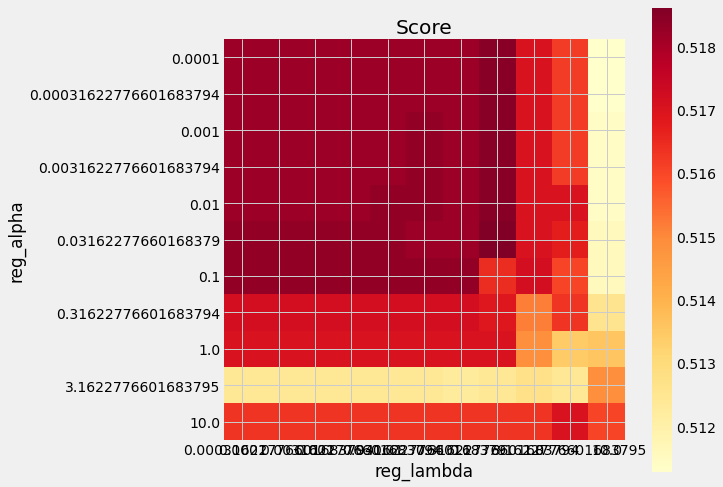

LGBMClassifier(feature_fraction=1.0, max_depth=7, min_child_weight=0.0001,
               num_leaves=2, random_state=23, reg_alpha=0.03162277660168379,
               reg_lambda=0.31622776601683794, subsample=0.6) 0.5186308492201039


In [124]:
lgbc = lgb.LGBMClassifier(feature_fraction=1.0, max_depth=7, min_child_weight=0.0001,
               num_leaves=2, random_state=23, reg_alpha=0.03162277660168379,
               reg_lambda=0.31622776601683794, subsample=0.6)

grid = {
#     'min_child_weight':np.logspace(-4, 1, 10),
#     'reg_lambda':np.logspace(-4, 1, 11),
#     'reg_alpha':np.logspace(-4, 1, 11)
#     'feature_fraction':np.linspace(0.01, 1.0, 10),
#     'boosting_type':['gbdt'],
#     'max_depth':np.arange(6,11,1),
#     'num_leaves':np.arange(2, 128, 4)
    
                }


param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(lgbc, param_grid,
                                                            X_train1, cover_train1, 
                                                            X_test1, cover_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)

In [123]:
best_lgbc = lgb.LGBMClassifier(feature_fraction=1.0, max_depth=7, min_child_weight=0.0001,
               num_leaves=2, random_state=23, reg_alpha=0.03162277660168379,
               reg_lambda=0.31622776601683794, subsample=0.6)
                               
best_lgbc.fit(X_train1, cover_train1)

preds_train_lgbc = best_lgbc.predict(X_train1)   
preds_test_lgbc = best_lgbc.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_lgbc)
test_acc = accuracy_score(cover_test1, preds_test_lgbc)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
train_acc: 0.5437826961770623 test_acc: 0.5171865973425765


0.5109837631327603


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 1
best threshold: 0.518
num_games_bet: 485
win percetange at threshold: 0.5381443298969072


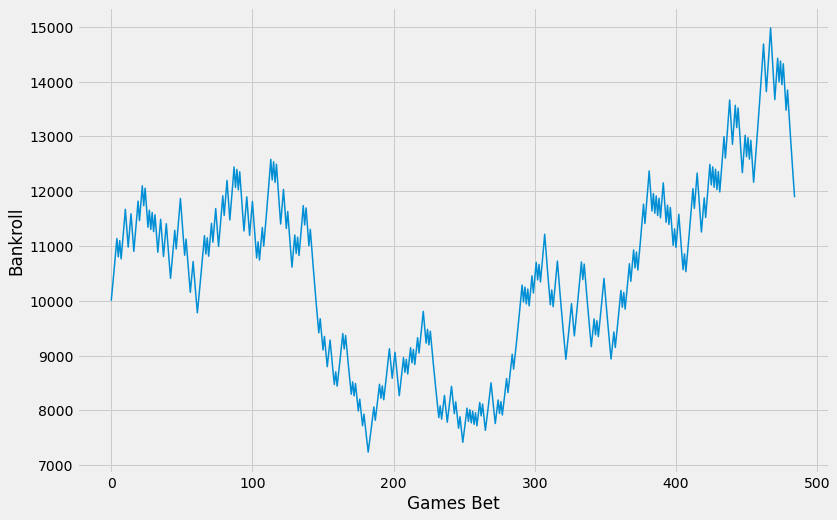

min balance: 7238.220780151876 
max balance: 14978.766039283293 
final balance: 12213.816714654682 
win percentage 53.81


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0        0  21900073  CHI vs. DET         -2.5               57   
1        3  21900078  DET vs. BKN          2.0               46   
2        4  21900079  ORL vs. DEN          1.5               45   
3        5  21900082  MIL vs. TOR         -3.5               66   
4        8  21900086  MIA vs. HOU          1.5               71   
..     ...       ...          ...          ...              ...   
480   1026  41900235  LAC vs. DEN         -4.5               56   
481   1027  41900225  LAL vs. HOU         -3.5               62   
482   1031  41900302  BOS vs. MIA         -1.5               60   
483   1033  41900303  MIA vs. BOS          3.0               50   
484   1036  41900304  MIA vs. BOS          3.0               50   

     team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                 52              5.0           1   0.528354   0.480279   
1                 54             -8.0           0   0.478481   0.522165   
2                 40              5.0           1   0.521815   0.496812   
3                 50             16.0           1   0.529880   0.459982   
4                 46             25.0           1   0.464053   0.539146   
..               ...              ...         ...        ...        ...   
480               44             12.0           1   0.472172   0.529422   
481               51             11.0           1   0.481278   0.525189   
482               47             13.0           1   0.477905   0.517117   
483               63            -13.0           0   0.550506   0.461680   
484               44              6.0           1   0.543983   0.472710   

     prob_avg  bet_home1  bet_home2  bet_home3    bankroll_i    bankroll_n  \
0    0.524037          1          1          1  10000.000000  10272.727273   
1    0.478158          0          0          0  10272.727273  10552.892562   
2    0.512501          1          1          1  10552.892562  10840.698723   
3    0.534949          1          1          1  10840.698723  11136.354142   
4    0.462453          0          0          0  11136.354142  10802.263518   
..        ...        ...        ...        ...           ...           ...   
480  0.471375          0          0          0  13430.083199  13027.180703   
481  0.478045          0          0          0  13027.180703  12636.365282   
482  0.480394          0          0          0  12636.365282  12257.274324   
483  0.544413          1          1          1  12257.274324  11889.556094   
484  0.535637          1          1          1  11889.556094  12213.816715   

       bet_size  bet_won  
0    300.000000        1  
1    308.181818        1  
2    316.586777        1  
3    325.220962        1  
4    334.090624        0  
..          ...      ...  
480  402.902496        0  
481  390.815421        0  
482  379.090958        0  
483  367.718230        0  
484  356.686683        1  

[485 rows x 18 columns]

In [62]:
print(accuracy_score(cover_test1, lgbr_preds))

select_bets_lgbr, bet_thresholds_lgbr = find_optimal_threshold(df_ewm_9_diffs, lgbr_probs,
                                                                               test_idx1)
simulate_bets(select_bets_lgbr)


In [1206]:
bet_thresholds_lgbr

index  prediction_num  confidence_thresholds  num_games_bet  \
0      1220               2                   2.21            252   
1      1221               2                   2.22            251   
2      2216               3                   2.17            238   
3      1222               2                   2.23            249   
4      1223               2                   2.24            249   
...     ...             ...                    ...            ...   
1463    420               1                   4.21             15   
1464    421               1                   4.22             15   
1465    422               1                   4.23             15   
1466    423               1                   4.24             15   
1467    424               1                   4.25             15   

      win_percentage  expected_profits  
0           0.563492              2320  
1           0.561753              2220  
2           0.563025              2168  
3           0.558233              2020  
4           0.558233              2020  
...              ...               ...  
1463        0.533333                44  
1464        0.533333                44  
1465        0.533333                44  
1466        0.533333                44  
1467        0.533333                44  

[1468 rows x 6 columns]

### XGB

In [422]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 67.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 78.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 85.3min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.4s finished


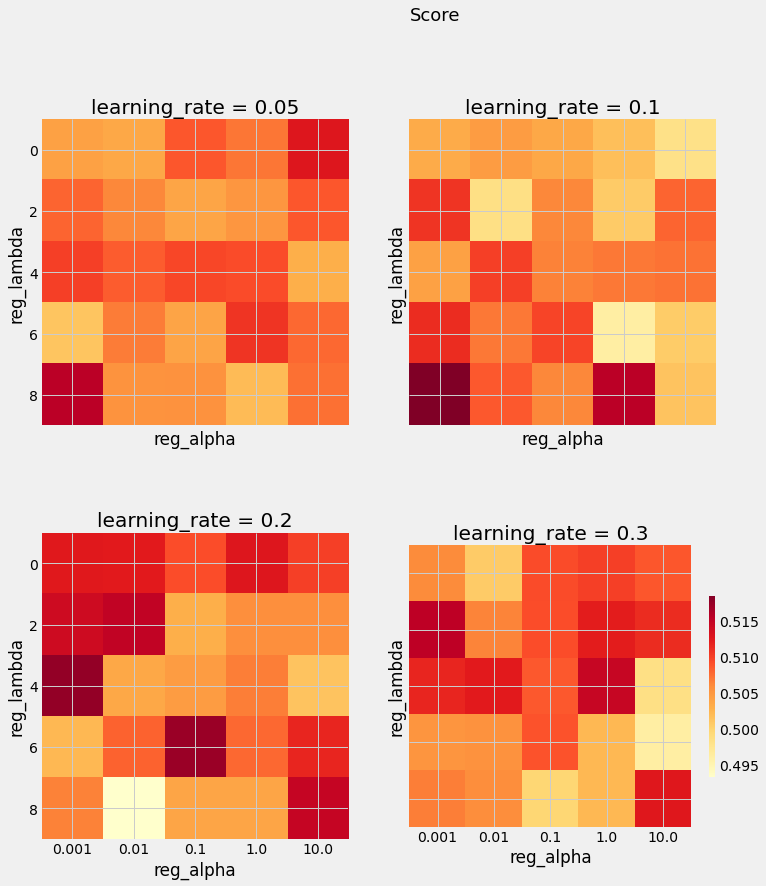

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.3333, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=23,
              reg_alpha=0.001, reg_lambda=8, scale_pos_weight=1, subsample=1,
              subsample_bytree=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None) 0.5186308492201039


In [135]:

# xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.2, max_delta_step=0, max_depth=6,
#               min_child_weight=1, monotone_constraints='()',
#               n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=23,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=None)


xgbc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.3333, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=20, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=23,
              reg_alpha=0.001, reg_lambda=8, scale_pos_weight=1, subsample=1,
              subsample_bytree=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

grid = {
#      "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#   "min_child_weight" : np.arange(20, 31, 2),
#  "gamma"            : np.linspace(0, 3, 10)
#  "colsample_bytree" : [0.8, 0.9, 0.95, 1.0],
# "subsample_bytree":[0.5, 0.6, 0.7, 0.8, 0.9, 1],
"reg_alpha":np.logspace(-3,1, 5),
"reg_lambda":np.arange(0, 10, 2),
    'learning_rate':[0.05, 0.1, 0.2, 0.3]
}   
 

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(xgbc, param_grid,
                                                            X_train1, cover_train1, 
                                                            X_test1, cover_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)


In [324]:
best_xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.3333, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=20, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=23,
              reg_alpha=0.001, reg_lambda=8, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1,
              verbosity=None)

best_xgbc.fit(X_train1, cover_train1)


preds_train_xgb = best_xgbc.predict(X_train1)   
preds_test_xgb = best_xgbc.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_xgb)
test_acc = accuracy_score(cover_test1, preds_test_xgb)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

train_acc: 0.9413682092555332 test_acc: 0.5186308492201039


accuracy: 0.4894937917860554


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 2
best threshold: 0.732
num_games_bet: 24
win percetange at threshold: 0.5833333333333334


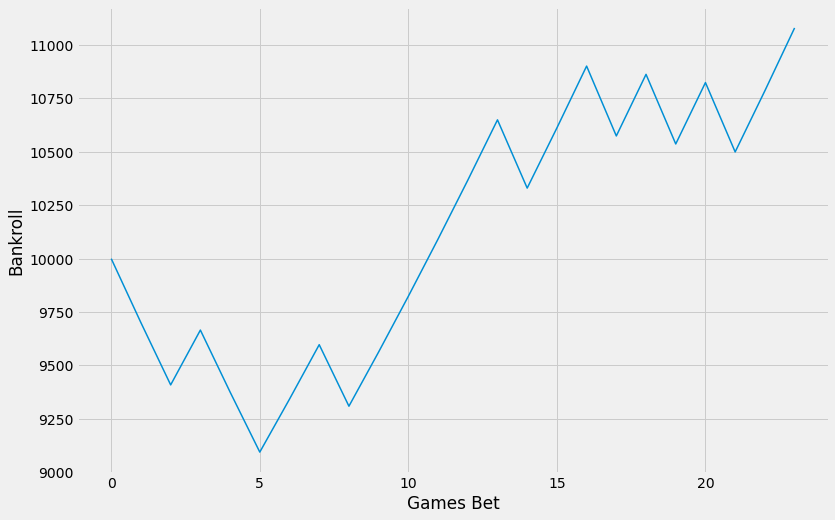

min balance: 9094.371593636364 
max balance: 11080.164929149007 
final balance: 10747.759981274536 
win percentage 58.330000000000005


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0     103  21900184  SAC vs. BOS          1.0               50   
1     140  21900222  DEN vs. BOS         -2.5               45   
2     154  21900236  NYK vs. BKN          1.0               46   
3     220  21900302  NOP vs. DAL          2.0               53   
4     228  21900310  BOS vs. MIA         -3.0               52   
5     240  21900322  DET vs. IND          0.5               55   
6     397  21900482  GSW vs. DAL          6.5               74   
7     413  21900499  SAC vs. LAC          3.0               40   
8     429  21900516  LAC vs. DET         -7.5               69   
9     449  21900536  CLE vs. MIN          3.0               48   
10    479  21900566  OKC vs. HOU          1.5               60   
11    517  21900604  BOS vs. DET         -6.0               59   
12    526  21900613  LAL vs. ORL         -6.5               58   
13    562  21900649  MIN vs. DEN         -1.5               54   
14    577  21900664  PHX vs. IND          0.5               48   
15    631  21900719  LAC vs. SAC         -8.0               47   
16    703  21900792  POR vs. MIA         -3.5               63   
17    719  21900809  BKN vs. TOR          1.5               52   
18    817  21900908  SAS vs. IND          0.5               57   
19    852  21900944  GSW vs. PHI          1.5               55   
20    883  21901235  WAS vs. PHX          4.0               52   
21    892  21901244  BKN vs. WAS         -2.5               54   
22   1018  41900215  TOR vs. BOS          0.5               35   
23   1019  41900233  DEN vs. LAC          5.0               59   

    team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                46              4.0           1   0.260377   0.657327   
1                34             11.0           1   0.259044   0.684801   
2                52             -6.0           0   0.224145   0.642053   
3                59             -6.0           0   0.748982   0.337911   
4                44              8.0           1   0.258953   0.519840   
5                44             11.0           1   0.814541   0.322009   
6                72              2.0           1   0.752786   0.346833   
7                57            -17.0           0   0.741847   0.191008   
8                63              6.0           0   0.247013   0.498271   
9                66            -18.0           0   0.264887   0.606064   
10               48             12.0           1   0.794323   0.449885   
11               57              2.0           0   0.244509   0.581333   
12               65             -7.0           0   0.261467   0.665554   
13               55             -1.0           0   0.760303   0.334019   
14               54             -6.0           0   0.256423   0.517853   
15               64            -17.0           0   0.257611   0.490032   
16               60              3.0           0   0.734071   0.515923   
17               40             12.0           1   0.834522   0.209760   
18               66             -9.0           0   0.776965   0.415000   
19               57             -2.0           0   0.262336   0.440277   
20               67            -15.0           0   0.744075   0.389068   
21               54              0.0           0   0.232312   0.679765   
22               62            -27.0           0   0.265190   0.630785   
23               57              2.0           1   0.250465   0.703518   

    prob_avg  bet_home1  bet_home2  bet_home3    bankroll_i    bankroll_n  \
0   0.301525          0          0          0  10000.000000   9700.000000   
1   0.287121          0          0          0   9700.000000   9409.000000   
2   0.291046          0          0          0   9409.000000   9665.609091   
3   0.705535          1          1          1   9665.609091   9375.640818   
4   0.369557          0          0          0   9375.640818   9094.371594   
5   0.746266          1          1      

In [64]:
xgb_preds = best_xgb.predict(X_test1)
xgb_probs = best_xgb.predict_proba(X_test1)

print("accuracy:", accuracy_score(cover_test1, xgb_preds))

select_bets_xgb, bet_thresholds_xgb = find_optimal_threshold(df_ewm_9_diffs, xgb_probs,
                                                                               test_idx1)
simulate_bets(select_bets_xgb)

In [182]:
xgb.XGBClassifier()

dtrain = xgb.DMatrix(X_train1, label=cover_train1)
dtest = xgb.DMatrix(X_test1, label=cover_test1)

baseline_preds = np.ones(cover_test1.shape)
baseline_acc = accuracy_score(cover_test1, baseline_preds)
print("Baseline_Accuracy:", baseline_acc)

params = {
    'max_depth':6,
    'min_child_weight':1,
    'eta':0.3,
    'subsample':1,
    'colsample_bytree':1,
    'eval_metric':'error'
}
num_boost_round=999
model = xgb.train(params,
                 dtrain,
                 num_boost_round=num_boost_round,
                 evals=[(dtest, "Test")],
                 early_stopping_rounds=10
                 )
print("Best accuracy: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Baseline_Accuracy: 0.5
[0]	Test-error:0.48426
Will train until Test-error hasn't improved in 10 rounds.
[1]	Test-error:0.49191
[2]	Test-error:0.48931
[3]	Test-error:0.49581
[4]	Test-error:0.49552
[5]	Test-error:0.50101
[6]	Test-error:0.49422
[7]	Test-error:0.48859
[8]	Test-error:0.48917
[9]	Test-error:0.48729
[10]	Test-error:0.48686
Stopping. Best iteration:
[0]	Test-error:0.48426

Best accuracy: 0.48 with 1 rounds


In [184]:
gridsearch_params = 


cv_results = xgb.cv(
params,
dtrain,
num_boost_round=num_boost_round,
seed=23,
folds=tscv,
metrics='error',
early_stopping_rounds=10)

cv_results

train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.418994         0.020154         0.496547        0.006958
1          0.391851         0.020279         0.495098        0.007923

In [304]:
X_train1

FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
150        17.059730      29.683866       1.865937       5.853899   
151        16.796757      35.902615       2.518229       7.054724   
156        12.530610      30.049742       2.331225       6.385485   
157        11.927499      28.255452       4.040023       9.304779   
158        18.488218      37.570975       2.318893       6.383092   
...              ...            ...            ...            ...   
28407      14.621380      26.240134       6.913866      16.587010   
28408      16.312537      29.249894       6.766958      16.272068   
28409      14.759247      25.916110       6.722473      16.728314   
28410      14.783323      25.724494       7.350244      17.255498   
28411      16.481289      29.124900       6.690260      16.244860   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
150        8.240605     13.531367       5.635149      14.545237     20.180386   
151        5.409611      8.130033       7.012527      17.679886     24.692413   
156       11.590950     16.485654       4.353838      16.568973     20.922810   
157       10.890894     14.867793       7.073454      15.231692     22.305145   
158        8.105028     11.381505       8.776684      15.510952     24.287636   
...             ...           ...            ...            ...           ...   
28407      9.555997     11.839105       4.193624      18.419891     22.613515   
28408      7.893058      9.937359       4.749156      18.056017     22.805172   
28409     10.000412     12.355211       3.974254      17.877884     21.852139   
28410     10.700391     13.719730       4.276838      17.390081     21.666919   
28411      8.503772     10.743649       4.974248      17.250388     22.224636   

       AST_team_ewm  STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  \
150       11.058948      3.731460      2.309174     11.259798    11.674074   
151       11.863276      4.282630      2.384337     10.496740    11.745330   
156        9.400527      3.345755      1.596786     10.212376    12.085810   
157        9.750849      4.863471      1.604405      8.558912    12.967058   
158       11.378526      3.980000      1.630070      8.582672    11.757515   
...             ...           ...           ...           ...          ...   
28407     12.561225      3.964638      2.474170      7.423562     8.229057   
28408     16.626294      4.947909      2.993926      8.093800    10.619272   
28409     11.905081      4.068178      2.426752      7.581211     8.506160   
28410     12.514591      4.161363      2.184070      7.223079     8.855555   
28411     16.663666      4.553105      3.094537      8.184423    11.357369   

       PTS_team_ewm  PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  \
150       47.957876            -0.690874             101.700105   
151       46.557813            -0.961661              93.218803   
156       43.645845            -6.778711              87.986347   
157       46.865962             2.899270             103.620388   
158       52.038143             6.427511             106.959579   
...             ...                  ...                    ...   
28407     59.540355             5.862437             116.463388   
28408     60.819005             6.748616             114.249501   
28409     59.686324             4.676154             115.807027   
28410     62.317770             6.008578             120.026449   
28411     61.537128             4.273673             115.434590   

       E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  POSS_team_ewm  \
150               101.432297               0.267808      46.685453   
151                93.525518              -0.284738      49.423067   
156                99.275468             -11.249342      49.006276   
157                96.894193               6.710173      45.348075   
158                92.396926              14.584630      47.869698   
...                      ...               

In [305]:
rf = RandomForestClassifier(max_features='auto',
                                 max_depth=11)

    
    
grid = {
     "max_depth":np.arange(3, 16, 3),
#   "min_samples_split":np.linspace(0.01, 0.5, 5)
#  "min_samples_leaf":np.linspace(0, 3, 20)
"max_features":[0.5, 0.6, 0.7, 0.8, 0.9, 1, 'log2', 'auto']
} 

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(rf, param_grid,
                                                            X_train1.iloc[:, 1:], cover_train1, 
                                                            X_test1.iloc[:, 1:], cover_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)

rf_bs = BayesSearchCV(RandomForestClassifier(), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1, n_iter=50)

rf_bs.fit(X_train1, cover_train1)

best_rf = rf_bs.best_estimator_

print("best_rf:", best_rf)

preds_rf_train = best_rf.predict(X_train1)
preds_rf_test = best_rf.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_rf_train)
test_acc = accuracy_score(cover_test1, preds_rf_test)

print("train_acc:", train_acc,
     "test_acc:", test_acc)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [25]:
np.linspace(0.01, 0.5, 5)

array([0.01  , 0.1325, 0.255 , 0.3775, 0.5   ])

In [128]:
best_rf = RandomForestClassifier(max_features='auto',
                                 max_depth=11)
params = {
    'min_samples_leaf':np.linspace(0.01, 0.5, 5),
         'min_samples_split':np.linspace(0.01, 0.5, 5)}

rf_gs = GridSearchCV(best_rf, param_grid = params,
                    verbose=1, n_jobs=-1)

rf_gs.fit(X_train1, cover_train1)
best_rf = rf_gs.best_estimator_

print("best_rf:", best_rf)

preds_rf_train = best_rf.predict(X_train1)
preds_rf_test = best_rf.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_rf_train)
test_acc = accuracy_score(cover_test1, preds_rf_test)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.7min finished


best_rf: RandomForestClassifier(max_depth=11, min_samples_leaf=0.1325,
                       min_samples_split=0.3775)
train_acc: 0.5322736418511066 test_acc: 0.5222414789139226


In [282]:
best_rf = RandomForestClassifier(max_depth=11, min_samples_leaf=0.1325, max_features='log2',
                       min_samples_split=0.3775, random_state=23)

best_rf.fit(X_train1, cover_train1)


preds_rf_train = best_rf.predict(X_train1)
preds_rf_test = best_rf.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_rf_train)
test_acc = accuracy_score(cover_test1, preds_rf_test)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

train_acc: 0.5313480885311871 test_acc: 0.5265742345465049


### Stacked Classifier

In [223]:
X_train1

FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  FTM_team_ewm  \
150        29.683866       1.865937       5.853899      8.240605   
151        35.902615       2.518229       7.054724      5.409611   
156        30.049742       2.331225       6.385485     11.590950   
157        28.255452       4.040023       9.304779     10.890894   
158        37.570975       2.318893       6.383092      8.105028   
...              ...            ...            ...           ...   
28407      26.240134       6.913866      16.587010      9.555997   
28408      29.249894       6.766958      16.272068      7.893058   
28409      25.916110       6.722473      16.728314     10.000412   
28410      25.724494       7.350244      17.255498     10.700391   
28411      29.124900       6.690260      16.244860      8.503772   

       FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  AST_team_ewm  \
150       13.531367       5.635149      14.545237     20.180386     11.058948   
151        8.130033       7.012527      17.679886     24.692413     11.863276   
156       16.485654       4.353838      16.568973     20.922810      9.400527   
157       14.867793       7.073454      15.231692     22.305145      9.750849   
158       11.381505       8.776684      15.510952     24.287636     11.378526   
...             ...            ...            ...           ...           ...   
28407     11.839105       4.193624      18.419891     22.613515     12.561225   
28408      9.937359       4.749156      18.056017     22.805172     16.626294   
28409     12.355211       3.974254      17.877884     21.852139     11.905081   
28410     13.719730       4.276838      17.390081     21.666919     12.514591   
28411     10.743649       4.974248      17.250388     22.224636     16.663666   

       STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  PTS_team_ewm  \
150        3.731460      2.309174     11.259798    11.674074     47.957876   
151        4.282630      2.384337     10.496740    11.745330     46.557813   
156        3.345755      1.596786     10.212376    12.085810     43.645845   
157        4.863471      1.604405      8.558912    12.967058     46.865962   
158        3.980000      1.630070      8.582672    11.757515     52.038143   
...             ...           ...           ...          ...           ...   
28407      3.964638      2.474170      7.423562     8.229057     59.540355   
28408      4.947909      2.993926      8.093800    10.619272     60.819005   
28409      4.068178      2.426752      7.581211     8.506160     59.686324   
28410      4.161363      2.184070      7.223079     8.855555     62.317770   
28411      4.553105      3.094537      8.184423    11.357369     61.537128   

       PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  E_DEF_RATING_team_ewm  \
150              -0.690874             101.700105             101.432297   
151              -0.961661              93.218803              93.525518   
156              -6.778711              87.986347              99.275468   
157               2.899270             103.620388              96.894193   
158               6.427511             106.959579              92.396926   
...                    ...                    ...                    ...   
28407             5.862437             116.463388             103.887120   
28408             6.748616             114.249501             101.394138   
28409             4.676154             115.807027             105.258453   
28410             6.008578             120.026449             107.342669   
28411             4.273673             115.434590             107.054910   

       E_NET_RATING_team_ewm  POSS_team_ewm  PIE_team_ewm  \
150                 0.267808      46.685453      0.482559   
151                -0.284738      49.423067      0.524247   
156               -11.249342      49.006276      0.419082   
157                 6.710173      45.348075      0.556933   
158                14.584630      47.869698      0.585109   
.

In [225]:
full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2010-11']

SEASON_YEAR_team TEAM_ID_team TEAM_ABBREVIATION_team  \
10504          2010-11   1610612748                    MIA   
10505          2010-11   1610612738                    BOS   
10506          2010-11   1610612756                    PHX   
10507          2010-11   1610612757                    POR   
10508          2010-11   1610612745                    HOU   
...                ...          ...                    ...   
13121          2010-11   1610612742                    DAL   
13122          2010-11   1610612748                    MIA   
13123          2010-11   1610612742                    DAL   
13124          2010-11   1610612742                    DAL   
13125          2010-11   1610612748                    MIA   

               TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
10504              Miami Heat  21000001     2010-10-26    MIA @ BOS   
10505          Boston Celtics  21000001     2010-10-26  BOS vs. MIA   
10506            Phoenix Suns  21000002     2010-10-26    PHX @ POR   
10507  Portland Trail Blazers  21000002     2010-10-26  POR vs. PHX   
10508         Houston Rockets  21000003     2010-10-26    HOU @ LAL   
...                       ...       ...            ...          ...   
13121        Dallas Mavericks  41000404     2011-06-07  DAL vs. MIA   
13122              Miami Heat  41000405     2011-06-09    MIA @ DAL   
13123        Dallas Mavericks  41000405     2011-06-09  DAL vs. MIA   
13124        Dallas Mavericks  41000406     2011-06-12    DAL @ MIA   
13125              Miami Heat  41000406     2011-06-12  MIA vs. DAL   

      HOME_GAME_team TEAM_SCORE_team point_diff_team WL_team spread_team  \
10504              0              30             -15       0          -0   
10505              1              45              15       1           0   
10506              0              46              -4       0           4   
10507              1              50               4       1          -4   
10508              0              62              11       0         3.5   
...              ...             ...             ...     ...         ...   
13121              1              45              -2       1        -1.5   
13122              0              57              -3       0         0.5   
13123              1              60               3       1        -0.5   
13124              0              53               2       1         2.5   
13125              1              51              -2       0        -2.5   

      team_covered_team FG2M_team_ewm FG2A_team_ewm FG3M_team_ewm  \
10504                 0           NaN           NaN           NaN   
10505                 1           NaN           NaN           NaN   
10506                 0           NaN           NaN           NaN   
10507                 0           NaN           NaN           NaN   
10508                 1           NaN           NaN           NaN   
...                 ...           ...           ...           ...   
13121                 0       13.9016       28.0883       4.29096   
13122                 0       14.4038       29.7122       2.91121   
13123                 1       13.7114       27.9795       4.26186   
13124                 1       14.1403       27.9816       4.33568   
13125                 0       14.4634        29.541       3.12009   

      FG3A_team_ewm FTM_team_ewm FTA_team_ewm OREB_team_ewm DREB_team_ewm  \
10504           NaN          NaN          NaN           NaN           NaN   
10505           NaN          NaN          NaN           NaN           NaN   
10506           NaN          NaN          NaN           NaN           NaN   
10507           NaN          NaN          NaN           NaN           NaN   
10508           NaN          NaN          NaN           NaN           NaN   
...             ...          ...          ...           ...           ...   
13121       10.5616      9.27999      11.5801       4.41758       14.3836   
13122       8.64777      9.75126      12.4462     

In [235]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
import numpy as np

class TimeSeriesSplitImproved(TimeSeriesSplit):
    def split(self, X, y=None, groups=None, fixed_length=False,
              train_splits=1, test_splits=1):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        train_splits, test_splits = int(train_splits), int(test_splits)
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_samples))
        if (n_folds - train_splits - test_splits) <= 0 and test_splits > 0:
            raise ValueError(
                ("Both train_splits and test_splits must be positive"
                 " integers."))
        indices = np.arange(n_samples)
        split_size = (n_samples // n_folds)
        test_size = split_size * test_splits
        train_size = split_size * train_splits
        test_starts = range(train_size + n_samples % n_folds,
                            n_samples - (test_size - split_size),
                            split_size)
        if fixed_length:
            for i, test_start in zip(range(len(test_starts)),
                                     test_starts):
                rem = 0
                if i == 0:
                    rem = n_samples % n_folds
                yield (indices[(test_start - train_size - rem):test_start],indices[test_start:test_start + test_size])
        else:
            for test_start in test_starts:
                yield (indices[:test_start],indices[test_start:test_start + test_size])


model = TimeSeriesSplitImproved(n_splits=10)
for train_index, test_index in model.split(X_train1,fixed_length=True,train_splits=2, test_splits=1):
    print("TRAIN:", train_index, "TEST:", test_index)
    train, test = X_train1.iloc[train_index], X_train1.iloc[test_index]

TRAIN: [   0    1    2 ... 4516 4517 4518] TEST: [4519 4520 4521 ... 6775 6776 6777]
TRAIN: [2260 2261 2262 ... 6775 6776 6777] TEST: [6778 6779 6780 ... 9034 9035 9036]
TRAIN: [4519 4520 4521 ... 9034 9035 9036] TEST: [ 9037  9038  9039 ... 11293 11294 11295]
TRAIN: [ 6778  6779  6780 ... 11293 11294 11295] TEST: [11296 11297 11298 ... 13552 13553 13554]
TRAIN: [ 9037  9038  9039 ... 13552 13553 13554] TEST: [13555 13556 13557 ... 15811 15812 15813]
TRAIN: [11296 11297 11298 ... 15811 15812 15813] TEST: [15814 15815 15816 ... 18070 18071 18072]
TRAIN: [13555 13556 13557 ... 18070 18071 18072] TEST: [18073 18074 18075 ... 20329 20330 20331]
TRAIN: [15814 15815 15816 ... 20329 20330 20331] TEST: [20332 20333 20334 ... 22588 22589 22590]
TRAIN: [18073 18074 18075 ... 22588 22589 22590] TEST: [22591 22592 22593 ... 24847 24848 24849]


In [236]:
model

TimeSeriesSplitImproved(max_train_size=None, n_splits=10)

In [232]:
data = list(range(X_train1.shape[0]))

window_size = 2460*4
splits = []

for i in range(window_size, X_train1.shape[0], window_size):
    train = X_train1.iloc[i-window_size:i]
    test = X_train1.iloc[i:i+2622]
    splits.append((train, test))
    
    
for a_tuple in splits:
    print(a_tuple[0].shape, a_tuple[1].shape)

(9840, 298) (2622, 298)
(9840, 298) (2622, 298)


In [311]:
X_train1

FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
150        17.059730      29.683866       1.865937       5.853899   
151        16.796757      35.902615       2.518229       7.054724   
156        12.530610      30.049742       2.331225       6.385485   
157        11.927499      28.255452       4.040023       9.304779   
158        18.488218      37.570975       2.318893       6.383092   
...              ...            ...            ...            ...   
28407      14.621380      26.240134       6.913866      16.587010   
28408      16.312537      29.249894       6.766958      16.272068   
28409      14.759247      25.916110       6.722473      16.728314   
28410      14.783323      25.724494       7.350244      17.255498   
28411      16.481289      29.124900       6.690260      16.244860   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
150        8.240605     13.531367       5.635149      14.545237     20.180386   
151        5.409611      8.130033       7.012527      17.679886     24.692413   
156       11.590950     16.485654       4.353838      16.568973     20.922810   
157       10.890894     14.867793       7.073454      15.231692     22.305145   
158        8.105028     11.381505       8.776684      15.510952     24.287636   
...             ...           ...            ...            ...           ...   
28407      9.555997     11.839105       4.193624      18.419891     22.613515   
28408      7.893058      9.937359       4.749156      18.056017     22.805172   
28409     10.000412     12.355211       3.974254      17.877884     21.852139   
28410     10.700391     13.719730       4.276838      17.390081     21.666919   
28411      8.503772     10.743649       4.974248      17.250388     22.224636   

       AST_team_ewm  STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  \
150       11.058948      3.731460      2.309174     11.259798    11.674074   
151       11.863276      4.282630      2.384337     10.496740    11.745330   
156        9.400527      3.345755      1.596786     10.212376    12.085810   
157        9.750849      4.863471      1.604405      8.558912    12.967058   
158       11.378526      3.980000      1.630070      8.582672    11.757515   
...             ...           ...           ...           ...          ...   
28407     12.561225      3.964638      2.474170      7.423562     8.229057   
28408     16.626294      4.947909      2.993926      8.093800    10.619272   
28409     11.905081      4.068178      2.426752      7.581211     8.506160   
28410     12.514591      4.161363      2.184070      7.223079     8.855555   
28411     16.663666      4.553105      3.094537      8.184423    11.357369   

       PTS_team_ewm  PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  \
150       47.957876            -0.690874             101.700105   
151       46.557813            -0.961661              93.218803   
156       43.645845            -6.778711              87.986347   
157       46.865962             2.899270             103.620388   
158       52.038143             6.427511             106.959579   
...             ...                  ...                    ...   
28407     59.540355             5.862437             116.463388   
28408     60.819005             6.748616             114.249501   
28409     59.686324             4.676154             115.807027   
28410     62.317770             6.008578             120.026449   
28411     61.537128             4.273673             115.434590   

       E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  POSS_team_ewm  \
150               101.432297               0.267808      46.685453   
151                93.525518              -0.284738      49.423067   
156                99.275468             -11.249342      49.006276   
157                96.894193               6.710173      45.348075   
158                92.396926              14.584630      47.869698   
...                      ...               

In [316]:
best_sgd_lr = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=3.511191734215127e-05, loss='log',
                               penalty='l1', random_state=23))])

best_sgd_lr = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.0008286427728546851, loss='log',
                               random_state=23))])

best_sgd_svm = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.00628029144183426, penalty='l1',
                               random_state=23))])

best_sgd_svm = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.00628029144183426, penalty='l1',
                              random_state=23))])



best_rf = RandomForestClassifier(max_depth=11, min_samples_leaf=0.1325, max_features='log2',
                       min_samples_split=0.3775, random_state=23)

best_lgbc = lgb.LGBMClassifier(feature_fraction=1.0, max_depth=7, min_child_weight=0.0001,
               num_leaves=2, random_state=23, reg_alpha=0.03162277660168379,
               reg_lambda=0.31622776601683794, subsample=0.6)


best_xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.3333, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=20, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=23,
              reg_alpha=0.001, reg_lambda=8, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1,
              verbosity=None)

estimators = [('sgd', best_sgd_lr), ('svr', best_sgd_svm),
              ('rf', best_rf), ('lgbr', best_lgbc), 
              ('xgbr', best_xgbc)]



stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(), n_jobs=-1, verbose=1)

stacked_clf.fit(X_train1, cover_train1)

stacked_preds_train = stacked_clf.predict(X_train1)
stacked_preds_test = stacked_clf.predict(X_test1)

stacked_probs_test = stacked_clf.predict_proba(X_test1)


train_acc = accuracy_score(cover_train1, stacked_preds_train)
test_acc = accuracy_score(cover_test1, stacked_preds_test)

print("train_acc:", train_acc,
     "test_acc:", test_acc)





train_acc: 0.6035814889336016 test_acc: 0.5200751010976314


In [395]:
full_df_combined.loc[cutoff_17+1:cutoff_18]

SEASON_YEAR_team TEAM_ID_team TEAM_ABBREVIATION_team  \
28412          2017-18   1610612738                    BOS   
28413          2017-18   1610612739                    CLE   
28414          2017-18   1610612745                    HOU   
28415          2017-18   1610612744                    GSW   
28416          2017-18   1610612766                    CHA   
...                ...          ...                    ...   
31031          2017-18   1610612744                    GSW   
31032          2017-18   1610612744                    GSW   
31033          2017-18   1610612739                    CLE   
31034          2017-18   1610612744                    GSW   
31035          2017-18   1610612739                    CLE   

              TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
28412         Boston Celtics  21700001     2017-10-17    BOS @ CLE   
28413    Cleveland Cavaliers  21700001     2017-10-17  CLE vs. BOS   
28414        Houston Rockets  21700002     2017-10-17    HOU @ GSW   
28415  Golden State Warriors  21700002     2017-10-17  GSW vs. HOU   
28416      Charlotte Hornets  21700003     2017-10-18    CHA @ DET   
...                      ...       ...            ...          ...   
31031  Golden State Warriors  41700402     2018-06-03  GSW vs. CLE   
31032  Golden State Warriors  41700403     2018-06-06    GSW @ CLE   
31033    Cleveland Cavaliers  41700403     2018-06-06  CLE vs. GSW   
31034  Golden State Warriors  41700404     2018-06-08    GSW @ CLE   
31035    Cleveland Cavaliers  41700404     2018-06-08  CLE vs. GSW   

      HOME_GAME_team TEAM_SCORE_team point_diff_team WL_team spread_team  \
28412              0              38             -16       0           3   
28413              1              54              16       1          -3   
28414              0              62              -9       1         5.5   
28415              1              71               9       0        -5.5   
28416              0              45             -11       0         1.5   
...              ...             ...             ...     ...         ...   
31031              1              59              13       1          -6   
31032              0              52              -6       1         0.5   
31033              1              58               6       0        -0.5   
31034              0              61               9       1        -0.5   
31035              1              52              -9       0         0.5   

      team_covered_team FG2M_team_ewm FG2A_team_ewm FG3M_team_ewm  \
28412                 0           NaN           NaN           NaN   
28413                 1           NaN           NaN           NaN   
28414                 0           NaN           NaN           NaN   
28415                 1           NaN           NaN           NaN   
28416                 0           NaN           NaN           NaN   
...                 ...           ...           ...           ...   
31031                 1       15.8894       28.6295       4.77293   
31032                 0       16.2005       28.0665       4.89564   
31033                 1       14.9522       28.5408       4.68729   
31034                 1       15.9804       27.9599       4.80607   
31035                 0       15.4569       29.4868       4.81856   

      FG3A_team_ewm FTM_team_ewm FTA_team_ewm OREB_team_ewm DREB_team_ewm  \
28412           NaN          NaN          NaN           NaN           NaN   
28413           NaN          NaN          NaN           NaN           NaN   
28414           NaN          NaN          NaN           NaN           NaN   
28415           NaN          NaN          NaN           NaN           NaN   
28416           NaN          NaN          NaN           NaN           NaN   
...             ...          ...          ...           ...           ...   
31031       15.4533      6.24046      7.78817       4.12671       17.1565   
31032        15.808      5.91641      7.60935       4.11404   

In [309]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [310]:
torch_scaler = StandardScaler()

X_train1_scaled = torch_scaler.fit_transform(X_train1)
X_test1_scaled = torch_scaler.transform(X_test1)

# X_train2_scaled = torch_scaler.fit_transform(X_train2)
# X_test2_scaled = torch_scaler.transform(X_test2)


class MatchupDataset(Dataset):
    
    def __init__(self, features, targets):
        self.targets = targets
        self.features = features
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        X = self.features[index]
        y = self.targets[index]
        
        return X, y
    
batch_size = 64

training_set1 = MatchupDataset(X_train1_scaled, cover_train1.values)
validation_set1 = MatchupDataset(X_test1_scaled, cover_test1.values)

train_loader1 = DataLoader(training_set1, batch_size = batch_size, shuffle=False)
val_loader1 = DataLoader(validation_set1, batch_size = batch_size, shuffle=False)

# training_set2 = MatchupDataset(X_train2_scaled, cover_train2.values)
# validation_set2 = MatchupDataset(X_test2_scaled, cover_test2.values)

# train_loader2 = DataLoader(training_set2, batch_size = batch_size, shuffle=False)
# val_loader2 = DataLoader(validation_set2, batch_size = batch_size, shuffle=False)



In [311]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(X_train1.shape[1], 256)
#         self.bn1 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(256, 128)
#         self.bn2 = nn.BatchNorm1d(num_features=64)
        self.fc3 = nn.Linear(128, 64)
#         self.bn3 = nn.BatchNorm1d(num_features=32)
        self.fc4 = nn.Linear(64, 32)
    
        self.fc5 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = (torch.relu(self.fc1(x)))
        x = (torch.relu(self.fc2(x)))
        x = (torch.relu(self.fc3(x)))
        x = (torch.relu(self.fc4(x)))
        x = torch.sigmoid(self.fc5(x))
        return x
        
net = Net() 
print(net)

Net(
  (fc1): Linear(in_features=303, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [312]:
data, target = next(iter(train_loader1))

data.shape, target.shape


(torch.Size([64, 303]), torch.Size([64]))

In [313]:
torch.sigmoid(torch.tensor([4.3]))
torch.round(torch.tensor([0.51]))

X_test1
X_train1.shape

(24850, 303)

In [315]:
torch.manual_seed(23)

# net = Net()

learning_rate = 0.000001
# def my_loss(output, target):
#     residual = (output-target).float()
#     output*
#     return

loss_function = nn.BCELoss()

optimizer = optim.AdamW(net.parameters(), lr=learning_rate)

epochs = 164

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net.train()
    
    for (data, target) in  train_loader1:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        n_correct_preds = (torch.round(outputs)==target).detach().numpy().flatten().astype(int).sum()
        train_correct_preds += n_correct_preds
        train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train1.shape[0])
    train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net.eval()
        for batch_idx, (data, target) in enumerate(val_loader1):
            target = target.reshape(-1, 1)
            outputs = net(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
            n_correct_preds = (torch.round(outputs)==target).detach().numpy().flatten().astype(int).sum()
            val_correct_preds += n_correct_preds
            val_total_preds += outputs.shape[0]

        val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test1.shape[0])
        
    if e % 5 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.7f}.. ".format(train_loss / X_train1.shape[0]),
             "Test Loss: {:.7f}.. ".format(val_loss / X_test1.shape[0]),
             "Train Accuracy: {:.4f}..".format(train_accuracies[-1]),
             "Test Accuracy: {:.4f}..".format(val_accuracies[-1]))


Epoch: 1/164..  Training Loss: 0.0108373..  Test Loss: 0.0109093..  Train Accuracy: 0.5423.. Test Accuracy: 0.5118..
Epoch: 6/164..  Training Loss: 0.0108360..  Test Loss: 0.0109090..  Train Accuracy: 0.5423.. Test Accuracy: 0.5124..
Epoch: 11/164..  Training Loss: 0.0108347..  Test Loss: 0.0109087..  Train Accuracy: 0.5438.. Test Accuracy: 0.5147..
Epoch: 16/164..  Training Loss: 0.0108332..  Test Loss: 0.0109084..  Train Accuracy: 0.5453.. Test Accuracy: 0.5146..
Epoch: 21/164..  Training Loss: 0.0108317..  Test Loss: 0.0109081..  Train Accuracy: 0.5458.. Test Accuracy: 0.5142..
Epoch: 26/164..  Training Loss: 0.0108301..  Test Loss: 0.0109078..  Train Accuracy: 0.5459.. Test Accuracy: 0.5153..
Epoch: 31/164..  Training Loss: 0.0108284..  Test Loss: 0.0109074..  Train Accuracy: 0.5458.. Test Accuracy: 0.5169..
Epoch: 36/164..  Training Loss: 0.0108266..  Test Loss: 0.0109071..  Train Accuracy: 0.5462.. Test Accuracy: 0.5178..
Epoch: 41/164..  Training Loss: 0.0108247..  Test Loss: 0.

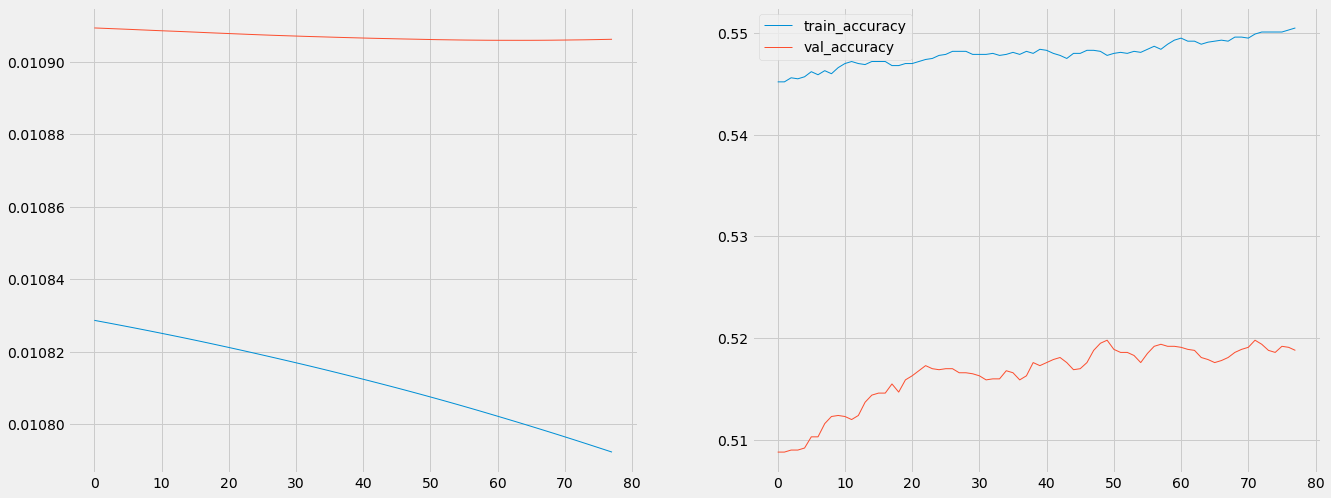

In [264]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].plot(train_losses, linewidth=1, label='train_loss')
axs[0].plot(val_losses, linewidth=1, label='val_loss')

axs[1].plot(train_accuracies, linewidth=1, label='train_accuracy')
axs[1].plot(val_accuracies, linewidth=1, label='val_accuracy')
plt.legend()
plt.show()

In [279]:
# preds_train1 = net(torch.tensor(X_train2_scaled).float()).detach().numpy()[0]
preds_test1 = net(torch.tensor(X_test1_scaled).float()).detach().numpy()

preds = pd.DataFrame({'probs':preds_test1[:, 0], 'target':cover_test1})

print(preds_test1.shape, cover_test1.shape)
preds['prediction'] = np.round(preds['probs'])
preds['bet_won'] = (preds['prediction'] == preds['target']).astype(int)
preds_test1 = np.concatenate([np.zeros_like(preds_test1), preds_test1], axis=1) 

nn_betting_df = create_betting_df(full_df_combined, preds_test1, test_idx1, 1)
# t = 0.504
# select_bets = nn_betting_df.loc[~nn_betting_df['prob_avg'].between(1-t, t)]
# print(select_bets['bet_won'].mean())
# simulate_bets(select_bets)
# # betting_df

# select_bets, thresholds = find_optimal_threshold(full_df_diffs, preds_test1, test_idx2)
# simulate_bets(select_bets)
# preds

# select_bets
# nn_betting_df
nn_betting_df['bet_won'].mean()

(6924, 1) (6924,)


0.5184864240323512

### Bet Functions

In [112]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(-20, 350)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(20, 600)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 5
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(15, 200)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets


def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            pct = .05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            pct = .04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            pct = .03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            pct = .02
        else:
            pct = .01
            
        selected_bets.at[idx, 'bet_size'] = selected_bets.at[idx, 'bankroll_i'] * pct
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(15, 200)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets


def simulate_bets_kelly(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']
        
        b = 1/1.1
        if selected_bets.loc[idx, 'prob_avg'] > 0.5:
            p = selected_bets.loc[idx, 'prob_avg']
        else:
            p = 1 - selected_bets.loc[idx, 'prob_avg']
        q = 1-p
        
        K = (b*p-q)/b
        if K < 0:
            bet_size=0
        else:
            bet_size=selected_bets.loc[idx, 'bankroll_i']*K
            
        
        selected_bets.loc[idx, 'bet_size'] = bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets

In [137]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)

stacked_clf.fit(X_train1, cover_train1)

print(stacked_clf.score(X_test1.loc[cutoff_17+1:cutoff_18], cover_test1.loc[cutoff_17+1:cutoff_18]))

stacked_probs = stacked_clf.predict_proba(X_test1.loc[cutoff_17+1:cutoff_18])


0.533195020746888


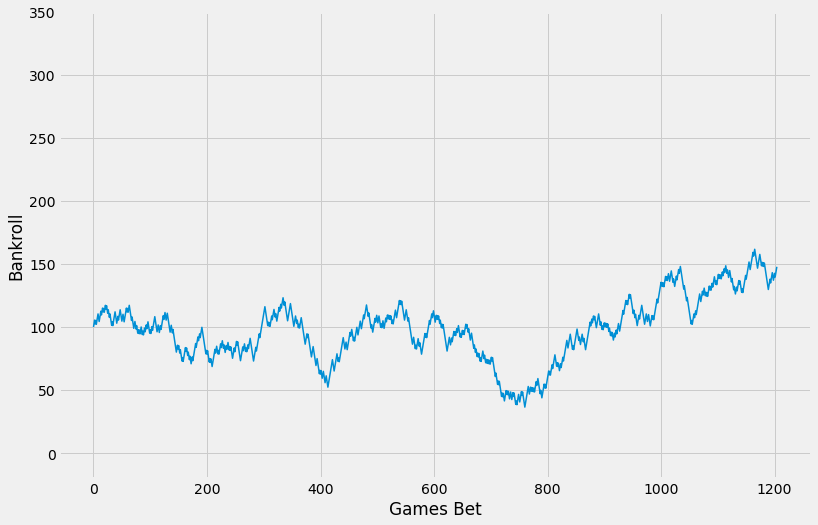

min balance: 36.454545454547734 
max balance: 161.63636363636618 
final balance: 144.72727272727514 
win percentage 53.03 
profit: 44.72727272727252 risk: 3615.0 
ROI: 1.24


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0         0  21700077  NOP vs. CLE          1.0               65   
1         1  21700080  MEM vs. HOU         -1.0               54   
2         2  21700081  DAL vs. PHI          0.5               56   
3         3  21700082  UTA vs. LAL         -6.5               56   
4         4  21700083  POR vs. PHX         -6.5               61   
...     ...       ...          ...          ...              ...   
1200   1200  41700317  HOU vs. GSW          2.0               54   
1201   1201  41700401  GSW vs. CLE         -7.0               56   
1202   1202  41700402  GSW vs. CLE         -6.0               59   
1203   1203  41700403  CLE vs. GSW         -0.5               58   
1204   1204  41700404  CLE vs. GSW          0.5               52   

      team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                  52             13.0           1   0.517587   0.490757   
1                  49              5.0           1   0.500748   0.498350   
2                  57             -1.0           0   0.500202   0.495379   
3                  45             11.0           1   0.508741   0.496652   
4                  57              4.0           0   0.512658   0.479359   
...               ...              ...         ...        ...        ...   
1200               43             11.0           1   0.497317   0.500184   
1201               56              0.0           0   0.498595   0.500352   
1202               46             13.0           1   0.501770   0.497684   
1203               52              6.0           1   0.503737   0.499882   
1204               61             -9.0           0   0.508266   0.496587   

      prob_avg  bet_home1  bet_home2  bet_home3  bankroll_i  bankroll_n  \
0     0.513415          1          1          1  100.000000  102.727273   
1     0.501199          1          1          1  102.727273  105.454545   
2     0.502411          1          1          1  105.454545  102.454545   
3     0.506044          1          1          1  102.454545  105.181818   
4     0.516649          1          1          1  105.181818  102.181818   
...        ...        ...        ...        ...         ...         ...   
1200  0.498567          0          0          0  142.545455  139.545455   
1201  0.499121          0          0          0  139.545455  142.272727   
1202  0.502043          1          1          1  142.272727  145.000000   
1203  0.501927          1          1          1  145.000000  147.727273   
1204  0.505840          1          1          1  147.727273  144.727273   

      bet_size  bet_won  
0          3.0        1  
1          3.0        1  
2          3.0        0  
3          3.0        1  
4          3.0        0  
...        ...      ...  
1200       3.0        0  
1201       3.0        1  
1202       3.0        1  
1203       3.0        1  
1204       3.0        0  

[1205 rows x 18 columns]

In [139]:
stacked_bets_2018 = create_betting_df(full_df_combined, stacked_probs, X_test1.loc[cutoff_17+1:cutoff_18].index, 3)

simulate_bets_1(stacked_bets_2018, 3)

0.5148760330578512


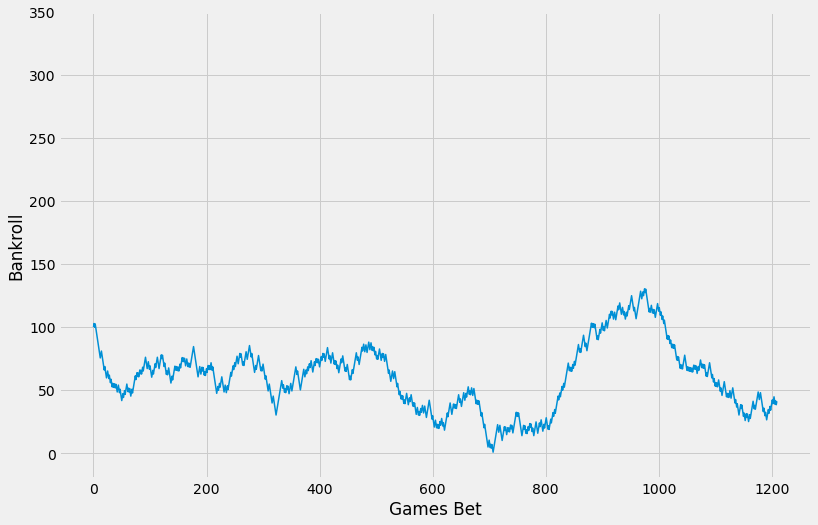

min balance: 0.7272727272737143 
max balance: 130.27272727272876 
final balance: 43.81818181818356 
win percentage 51.57000000000001 
profit: -56.181818181818244 risk: 3630.0 
ROI: -1.55


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0         0  21800068  NYK vs. GSW          6.5               53   
1         1  21800077  CLE vs. IND          3.5               55   
2         2  21800078  PHI vs. CHA         -4.0               63   
3         3  21800081  MIL vs. ORL         -5.5               65   
4         4  21800083  BKN vs. GSW          5.0               49   
...     ...       ...          ...          ...              ...   
1205   1205  41800402  TOR vs. GSW         -1.5               59   
1206   1206  41800403  GSW vs. TOR         -1.0               52   
1207   1207  41800404  GSW vs. TOR         -3.0               46   
1208   1208  41800405  TOR vs. GSW          0.0               56   
1209   1209  41800406  GSW vs. TOR         -2.0               57   

      team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                  53              0.0           1   0.536613   0.443401   
1                  60             -5.0           0   0.529942   0.461936   
2                  62              1.0           0   0.493116   0.511589   
3                  51             14.0           1   0.475331   0.506208   
4                  63            -14.0           0   0.528215   0.455623   
...               ...              ...         ...        ...        ...   
1205               54              5.0           1   0.494273   0.509293   
1206               60             -8.0           0   0.500596   0.501815   
1207               42              4.0           1   0.499046   0.503028   
1208               62             -6.0           0   0.491866   0.509645   
1209               60             -3.0           0   0.499370   0.506304   

      prob_avg  bet_home1  bet_home2  bet_home3  bankroll_i  bankroll_n  \
0     0.546606          1          1          1  100.000000  102.727273   
1     0.534003          1          1          1  102.727273   99.727273   
2     0.490763          0          0          0   99.727273  102.454545   
3     0.484562          0          0          0  102.454545   99.454545   
4     0.536296          1          1          1   99.454545   96.454545   
...        ...        ...        ...        ...         ...         ...   
1205  0.492490          0          0          0   41.636364   38.636364   
1206  0.499390          1          0          0   38.636364   41.363636   
1207  0.498009          0          0          0   41.363636   38.363636   
1208  0.491110          0          0          0   38.363636   41.090909   
1209  0.496533          0          0          0   41.090909   43.818182   

      bet_size  bet_won  
0          3.0        1  
1          3.0        0  
2          3.0        1  
3          3.0        0  
4          3.0        0  
...        ...      ...  
1205       3.0        0  
1206       3.0        1  
1207       3.0        0  
1208       3.0        1  
1209       3.0        1  

[1210 rows x 18 columns]

In [140]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_18)

stacked_clf.fit(X_train1, cover_train1)

print(stacked_clf.score(X_test1.loc[cutoff_18+1:cutoff_19], cover_test1.loc[cutoff_18+1:cutoff_19]))


stacked_probs = stacked_clf.predict_proba(X_test1.loc[cutoff_18+1:cutoff_19])

stacked_bets_2019 = create_betting_df(full_df_combined, stacked_probs, X_test1.loc[cutoff_18+1:cutoff_19].index, 3)

simulate_bets_1(stacked_bets_2019, 3)

0.5171919770773639


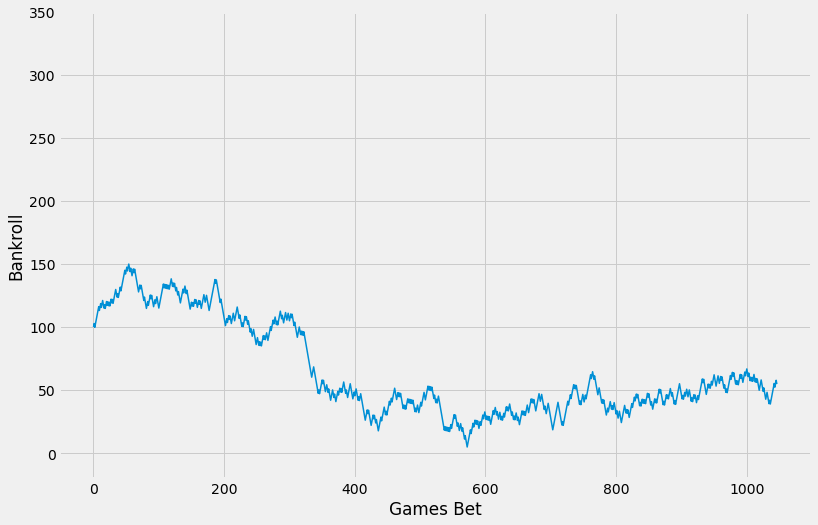

min balance: 4.8181818181822536 
max balance: 149.90909090909096 
final balance: 51.72727272727302 
win percentage 51.580000000000005 
profit: -48.27272727272748 risk: 3141.0 
ROI: -1.54


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0         0  21900073  CHI vs. DET         -2.5               57   
1         1  21900075  SAC vs. UTA          1.5               51   
2         2  21900077  OKC vs. NOP         -1.0               65   
3         3  21900078  DET vs. BKN          2.0               46   
4         4  21900079  ORL vs. DEN          1.5               45   
...     ...       ...          ...          ...              ...   
1042   1042  41900402  LAL vs. MIA         -6.5               68   
1043   1043  41900403  MIA vs. LAL          6.0               58   
1044   1044  41900404  MIA vs. LAL          5.0               47   
1045   1045  41900405  LAL vs. MIA         -4.0               56   
1046   1046  41900406  MIA vs. LAL          3.5               36   

      team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                  52              5.0           1   0.523685   0.475131   
1                  48              3.0           1   0.469688   0.522174   
2                  60              5.0           1   0.507461   0.486155   
3                  54             -8.0           0   0.497810   0.513841   
4                  40              5.0           1   0.523589   0.478991   
...               ...              ...         ...        ...        ...   
1042               54             14.0           1   0.495745   0.498959   
1043               54              4.0           1   0.507874   0.501342   
1044               49             -2.0           1   0.505000   0.502956   
1045               60             -4.0           0   0.502941   0.497794   
1046               64            -28.0           0   0.499925   0.498347   

      prob_avg  bet_home1  bet_home2  bet_home3  bankroll_i  bankroll_n  \
0     0.524277          1          1          1  100.000000  102.727273   
1     0.473757          0          0          0  102.727273   99.727273   
2     0.510653          1          1          1   99.727273  102.454545   
3     0.491984          0          0          0  102.454545  105.181818   
4     0.522299          1          1          1  105.181818  107.909091   
...        ...        ...        ...        ...         ...         ...   
1042  0.498393          0          1          0   55.272727   52.272727   
1043  0.503266          1          0          1   52.272727   55.000000   
1044  0.501022          1          0          1   55.000000   57.727273   
1045  0.502573          1          1          1   57.727273   54.727273   
1046  0.500789          0          1          1   54.727273   51.727273   

      bet_size  bet_won  
0          3.0        1  
1          3.0        0  
2          3.0        1  
3          3.0        1  
4          3.0        1  
...        ...      ...  
1042       3.0        0  
1043       3.0        1  
1044       3.0        1  
1045       3.0        0  
1046       3.0        0  

[1047 rows x 18 columns]

In [141]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_19)

stacked_clf.fit(X_train1, cover_train1)

print(stacked_clf.score(X_test1.loc[cutoff_19+1:cutoff_20], cover_test1.loc[cutoff_19+1:cutoff_20]))


stacked_probs = stacked_clf.predict_proba(X_test1.loc[cutoff_19+1:cutoff_20])

stacked_bets_2020 = create_betting_df(full_df_combined, stacked_probs, X_test1.loc[cutoff_19+1:cutoff_20].index, 3)

simulate_bets_1(stacked_bets_2020, 3)

In [ ]:
simulate_bets_1(stacked_bets_2018, 3), simulate_bets_1(stacked_bets_2019, 3), simulate_bets_1(stacked_bets_2020, 3)

### Percentage of Bankroll

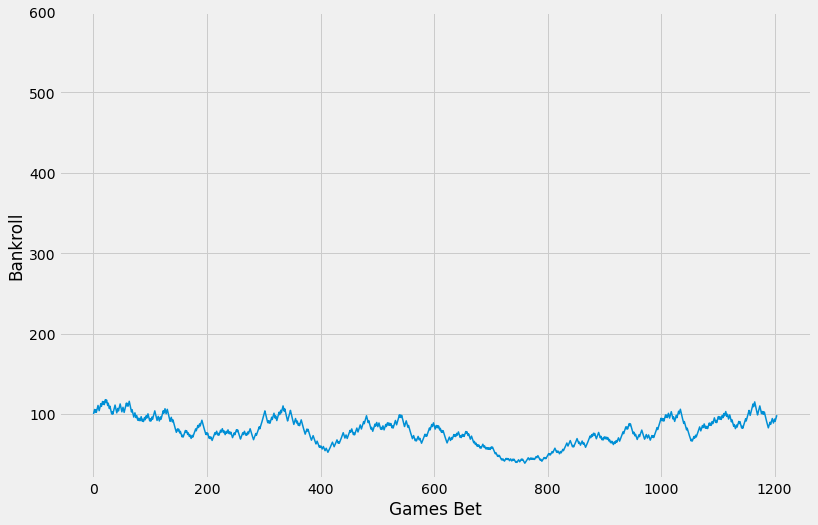

min balance: 38.747648659465064 
max balance: 117.7613447672336 
final balance: 95.49951466908956 
win percentage 53.03 
profit: -4.500485330910351 risk: 2847.5198511438693 
ROI: -0.16


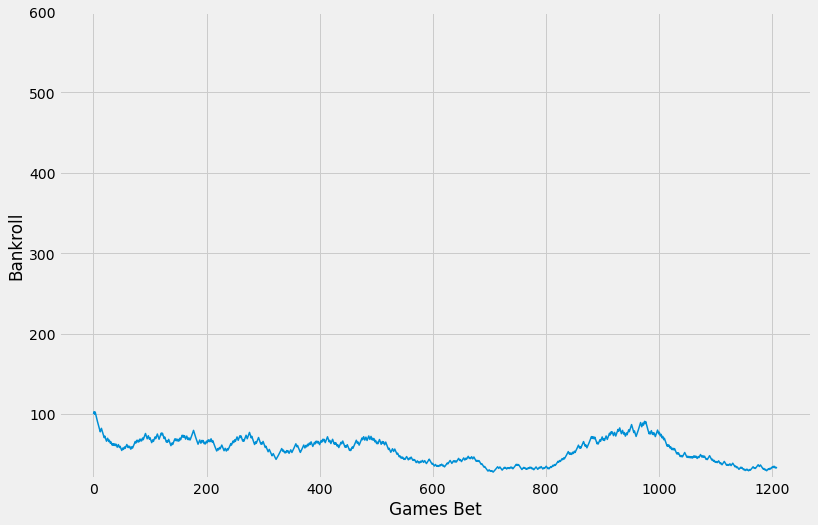

min balance: 27.68640828482608 
max balance: 102.72727272727273 
final balance: 34.6856210454938 
win percentage 51.57000000000001 
profit: -65.31437895450654 risk: 1994.0272303943377 
ROI: -3.2800000000000002


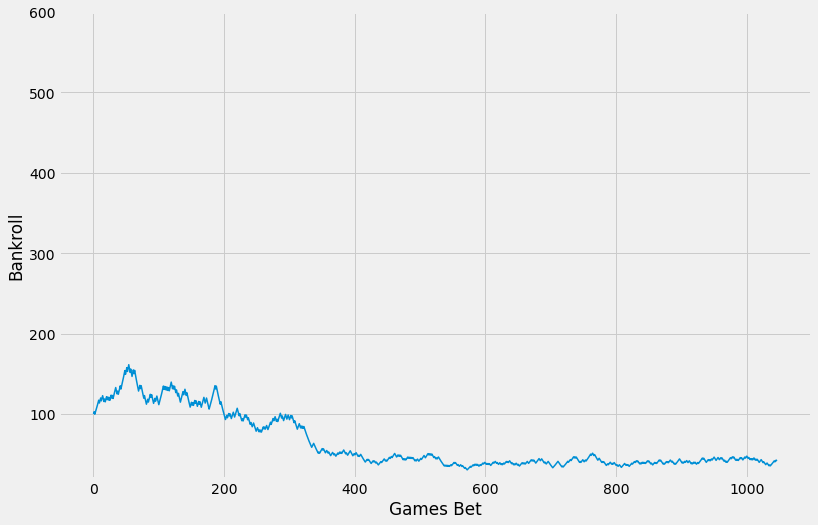

min balance: 30.486025529177983 
max balance: 161.24733312593878 
final balance: 40.140129436929584 
win percentage 51.580000000000005 
profit: -59.85987056307056 risk: 2004.566144424721 
ROI: -2.9899999999999998


In [142]:
bets_2_18, bets2_19, bets_2_20 = simulate_bets_2(stacked_bets_2018, 0.03), simulate_bets_2(stacked_bets_2019, 0.03), simulate_bets_2(stacked_bets_2020, 0.03)

### Bet Size Based on Confidence Thresholds

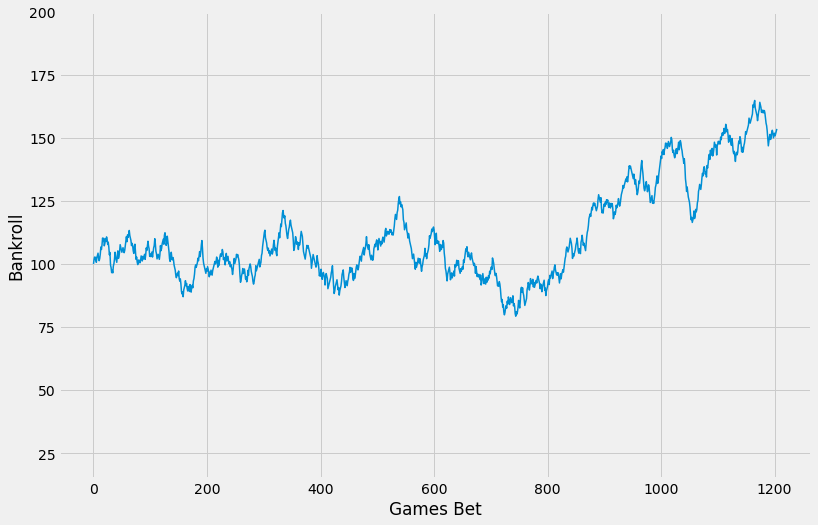

min balance: 79.27272727272651 
max balance: 164.81818181818022 
final balance: 152.54545454545288 
win percentage 53.03 
profit: 52.545454545454504 risk: 2036.0 
ROI: 2.58


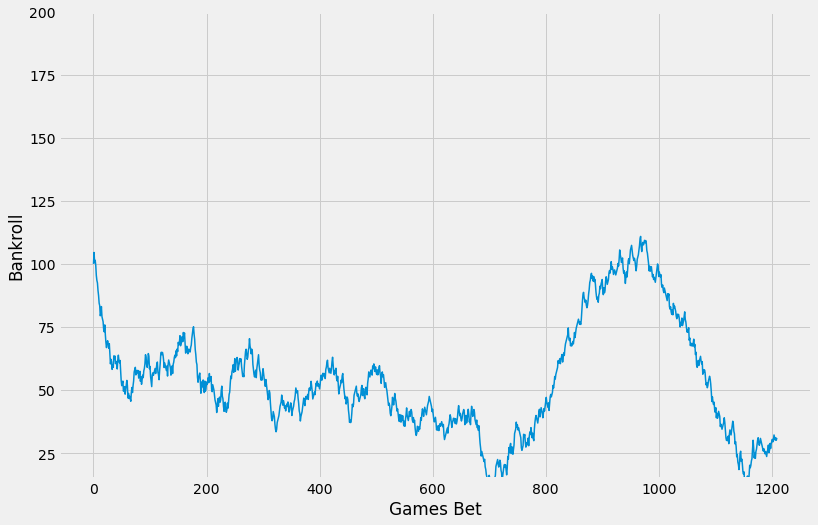

min balance: 8.818181818181571 
max balance: 110.90909090909058 
final balance: 31.909090909090455 
win percentage 51.57000000000001 
profit: -68.09090909090924 risk: 2317.0 
ROI: -2.94


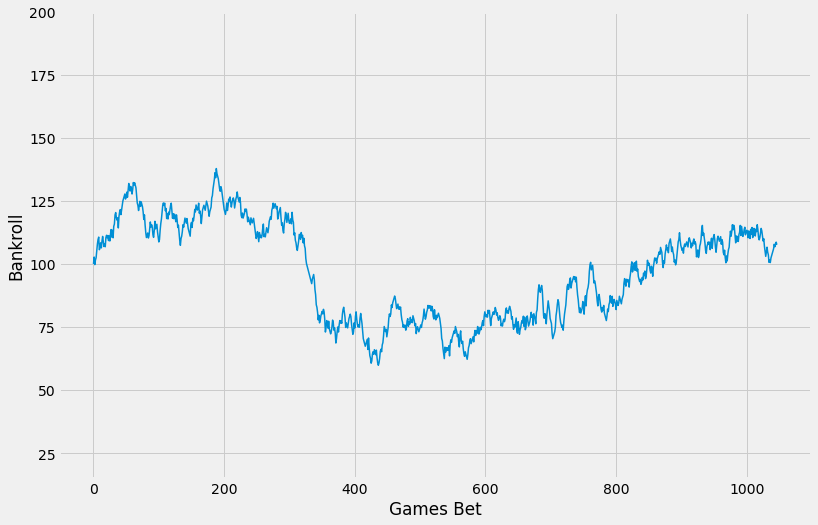

min balance: 59.81818181818146 
max balance: 137.81818181818167 
final balance: 106.63636363636294 
win percentage 51.580000000000005 
profit: 6.636363636363512 risk: 2059.0 
ROI: 0.32


In [143]:
bets3_18, bets3_19, bets3_20 = simulate_bets_3(stacked_bets_2018), simulate_bets_3(stacked_bets_2019), simulate_bets_3(stacked_bets_2020)

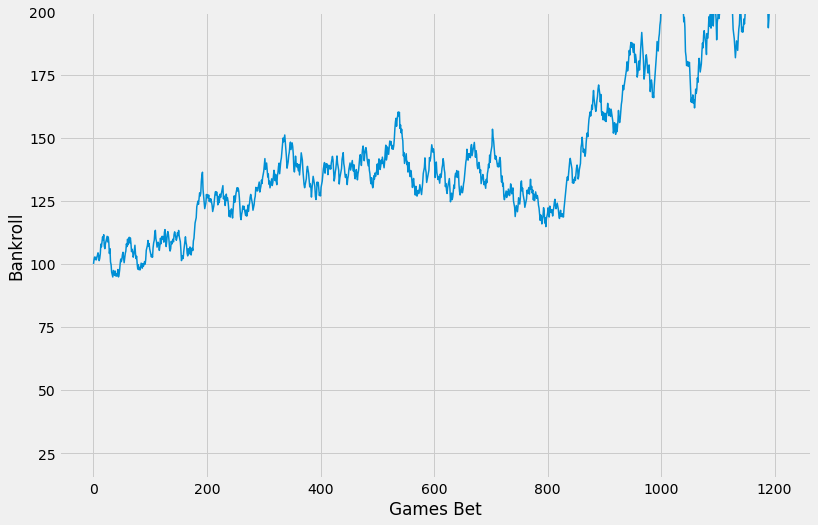

min balance: 94.82444140360094 
max balance: 223.6393935793457 
final balance: 202.69444196196258 
win percentage 55.1 
profit: 102.69444196196196 risk: 2935.2132827214677 
ROI: 3.5000000000000004


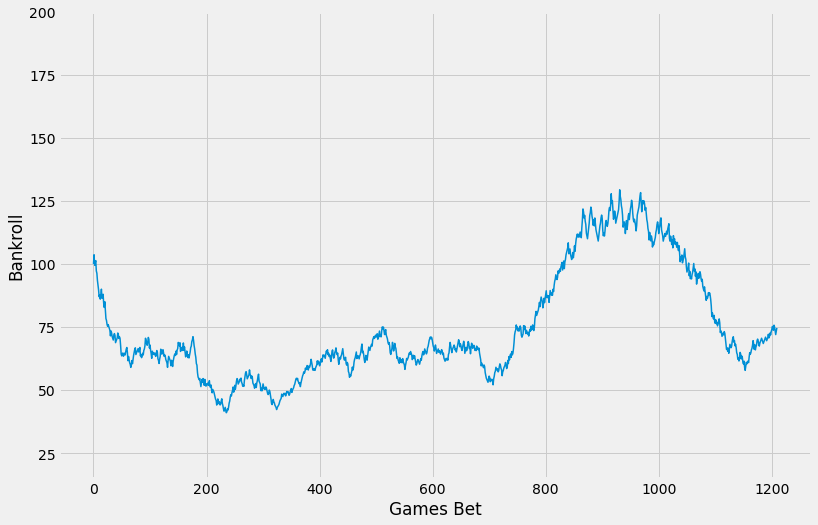

min balance: 41.00270893131908 
max balance: 129.39167068143553 
final balance: 73.88156950169045 
win percentage 52.480000000000004 
profit: -26.11843049830952 risk: 1704.595516493269 
ROI: -1.53


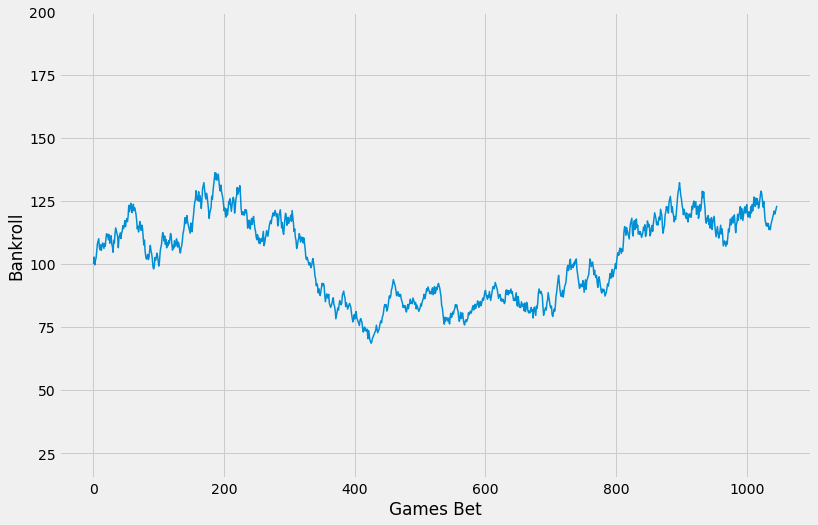

min balance: 68.55640194393014 
max balance: 136.19004965654736 
final balance: 121.83859492388021 
win percentage 52.82 
profit: 21.838594923879896 risk: 1968.875210016487 
ROI: 1.11


In [484]:
bets4_18, bets4_19, bets4_20 = simulate_bets_4(stacked_bets_2018), simulate_bets_4(stacked_bets_2019), simulate_bets_4(stacked_bets_2020)

## Making Current Predictions


In [328]:
from src.data.update_data import update_all_data_1H

update_all_data_1H(season='2020-21')

updating basic team boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/13 [00:00<?, ?it/s]

num_games_updated: 13


progress: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:40<00:00,  3.12s/it]


updating scoring boxscores
num_scoring_boxscores_updated: 13


progress: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:49<00:00,  3.78s/it]


In [329]:
def load_current_team_1H_data(season):
    """Loads basic, advanced, and scoring boxscores from
    season and merges them into one dataframe
    """

    basic_gls_all, adv_gls_all, scoring_gls_all = [], [], []
    
    basic_gls = pd.read_csv('../data/basic_team_boxscores_1H/team_boxscores_1H_{}.csv'.format(season))
    basic_gls_all.append(basic_gls)

    adv_gls = pd.read_csv('../data/advanced_team_boxscores_1H/team_advanced_1H_{}.csv'.format(season))
    adv_gls_all.append(adv_gls)

    scoring_gls = pd.read_csv('../data/scoring_team_boxscores_1H/team_scoring_1H_{}.csv'.format(season))
    scoring_gls_all.append(scoring_gls)

    basic_gls_all_df = pd.concat(basic_gls_all)
    adv_gls_all_df = pd.concat(adv_gls_all)
    scoring_gls_all_df = pd.concat(scoring_gls_all)

    temp = pd.merge(basic_gls_all_df, adv_gls_all_df, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls_all_df, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
       'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK',
       'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK',
       'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK',
       'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'TEAM_ID_y', 'TEAM_NAME_y',
                                       'TEAM_CITY_y', 'MIN_y', 'PIE_y', 'TEAM_CITY',
                                     'OREB_PCT', 'DREB_PCT', 'REB_PCT'])
    return full_df



In [330]:
df_2020 = load_current_team_1H_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME  \
0        2020-21  1610612742               DAL       Dallas Mavericks   
1        2020-21  1610612752               NYK        New York Knicks   
2        2020-21  1610612759               SAS      San Antonio Spurs   
3        2020-21  1610612747               LAL     Los Angeles Lakers   
4        2020-21  1610612745               HOU        Houston Rockets   
...          ...         ...               ...                    ...   
2003     2020-21  1610612761               TOR        Toronto Raptors   
2004     2020-21  1610612746               LAC            LA Clippers   
2005     2020-21  1610612747               LAL     Los Angeles Lakers   
2006     2020-21  1610612751               BKN          Brooklyn Nets   
2007     2020-21  1610612744               GSW  Golden State Warriors   

       GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  point_diff  WL  \
0     22001007 2021-05-07  DAL vs. CLE          1          62        25.0   1   
1     22001009 2021-05-07    NYK @ PHX          0          63         7.0   0   
2     22001011 2021-05-07    SAS @ SAC          0          52         3.0   1   
3     22001010 2021-05-07    LAL @ POR          0          55        -4.0   0   
4     22001006 2021-05-07    HOU @ MIL          0          63        -1.0   0   
...        ...        ...          ...        ...         ...         ...  ..   
2003  22000014 2020-12-23  TOR vs. NOP          1          57         7.0   0   
2004  22000002 2020-12-22    LAC @ LAL          0          56         2.0   1   
2005  22000002 2020-12-22  LAL vs. LAC          1          54        -2.0   0   
2006  22000001 2020-12-22  BKN vs. GSW          1          63        18.0   1   
2007  22000001 2020-12-22    GSW @ BKN          0          45       -18.0   0   

       MIN  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0     24.0       1    15    26     6    20   14   15     7    20   27   11   
1     24.0       0    19    27     5    14   10   13     1    21   22   13   
2     24.0       1    19    34     2    14    8    8     2    19   21   11   
3     24.0       0    14    31     7    14    6    9     4    21   25   11   
4     24.0       0    14    25    11    26    2    6     5    13   18   19   
...    ...     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
2003  24.0       0    10    21    11    24    4    6     3    17   20   15   
2004  24.0       1    14    24     7    21    7    9     3    18   21   12   
2005  24.0       0    12    23     5    17   15   20     3    21   24   10   
2006  24.0       1    14    27     9    20    8    9     4    24   28   11   
2007  24.0       0    13    36     4    17    7   10     6    17   23   10   

      STL  BLK  BLKA   TOV  PF  PFD  PTS  PLUS_MINUS  E_OFF_RATING  \
0       4    4     0   3.0  10   10   62        25.0         127.6   
1       2    3     1   5.0  14    9   63         7.0         124.2   
2       5    6     0   5.0   4   10   52         3.0          95.4   
3       1    3     1   8.0   8    8   55        -4.0         103.9   
4       7    4     1   8.0  11    6   63        -1.0         111.2   
...   ...  ...   ...   ...  ..  ...  ...         ...           ...   
2003    5    3     3  12.0  13   11   57         7.0         100.6   
2004    7    0     0  12.0  17   12   56         2.0          96.6   
2005    3    0     0  11.0  12   17   54        -2.0          95.1   
2006    5    6     2  13.0  10   10   63        18.0         105.1   
2007    4    2     6   9.0  10   10   45       -18.0          74.5   

      OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  POSS  \
0          129.2          74.1        75.5          53.5        53.7  48.0   
1          123.5         109.7       109.8          14.5        13.7  51.0   
2           98.1          95.1        94.2           0.3         3.9  53.0   
3          107.8         111.4       113.5          -7.6        -

In [331]:
from src.data.update_data import update_spread_data_1H
update_spread_data_1H(season='2020-21')

progress:   0%|                                                                                  | 0/2 [00:00<?, ?it/s]

Updating lines for 2 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.65s/it]


In [332]:
spreads_1H = pd.read_csv("../data/spreads_1H.csv", parse_dates=['game_date'])

spreads_1H_clean = clean_spread_data(spreads_1H)





In [333]:
spreads_1H_clean

away_team home_team  game_date  away_spread_1H_1  away_spread_1H_2  \
0           CHI       MIA 2006-10-31               NaN               NaN   
1           PHX       LAL 2006-10-31               NaN               NaN   
2           MIL       DET 2006-11-01               NaN               NaN   
3           IND       CHA 2006-11-01               NaN               NaN   
4           CHI       ORL 2006-11-01               NaN               NaN   
...         ...       ...        ...               ...               ...   
18713       SAS       POR 2021-05-08               3.0               3.0   
18714       OKC       GSW 2021-05-08               8.5               8.5   
18715       BKN       DEN 2021-05-08              -1.5              -1.5   
18716       MEM       TOR 2021-05-08              -3.0              -3.0   
18717       WAS       IND 2021-05-08              -2.0              -2.0   

       away_spread_1H_3  away_spread_1H_4  home_spread_1H_1  home_spread_1H_2  \
0                   2.5               NaN               NaN               NaN   
1                  -4.5               NaN               NaN               NaN   
2                   3.5               NaN               NaN               NaN   
3                   0.0               NaN               NaN               NaN   
4                   0.0               NaN               NaN               NaN   
...                 ...               ...               ...               ...   
18713               3.0               3.0              -3.0              -3.0   
18714               8.5               8.5              -8.5              -8.5   
18715              -1.5              -1.5               1.5               1.5   
18716              -3.0              -3.0               3.0               3.0   
18717              -2.0              -2.0               2.0               2.0   

       home_spread_1H_3  home_spread_1H_4  away_spread_1H  home_spread_1H  
0                  -2.5               NaN             2.5            -2.5  
1                   4.5               NaN            -4.5             4.5  
2                  -3.5               NaN             3.5            -3.5  
3                   0.0               NaN             0.0             0.0  
4                   0.0               NaN             0.0             0.0  
...                 ...               ...             ...             ...  
18713              -3.0              -3.0             3.0            -3.0  
18714              -8.5              -8.5             8.5            -8.5  
18715               1.5               1.5            -1.5             1.5  
18716               3.0               3.0            -3.0             3.0  
18717               2.0               2.0            -2.0             2.0  

[18718 rows x 13 columns]

In [334]:
df_2020 = add_spread_data(df_2020, spreads_1H_clean)


In [335]:
df_2020

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME  \
0        2020-21  1610612742               DAL       Dallas Mavericks   
1        2020-21  1610612752               NYK        New York Knicks   
2        2020-21  1610612759               SAS      San Antonio Spurs   
3        2020-21  1610612747               LAL     Los Angeles Lakers   
4        2020-21  1610612745               HOU        Houston Rockets   
...          ...         ...               ...                    ...   
2003     2020-21  1610612761               TOR        Toronto Raptors   
2004     2020-21  1610612746               LAC            LA Clippers   
2005     2020-21  1610612747               LAL     Los Angeles Lakers   
2006     2020-21  1610612751               BKN          Brooklyn Nets   
2007     2020-21  1610612744               GSW  Golden State Warriors   

       GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  point_diff  WL  \
0     22001007 2021-05-07  DAL vs. CLE          1          62        25.0   1   
1     22001009 2021-05-07    NYK @ PHX          0          63         7.0   0   
2     22001011 2021-05-07    SAS @ SAC          0          52         3.0   1   
3     22001010 2021-05-07    LAL @ POR          0          55        -4.0   0   
4     22001006 2021-05-07    HOU @ MIL          0          63        -1.0   0   
...        ...        ...          ...        ...         ...         ...  ..   
2003  22000014 2020-12-23  TOR vs. NOP          1          57         7.0   0   
2004  22000002 2020-12-22    LAC @ LAL          0          56         2.0   1   
2005  22000002 2020-12-22  LAL vs. LAC          1          54        -2.0   0   
2006  22000001 2020-12-22  BKN vs. GSW          1          63        18.0   1   
2007  22000001 2020-12-22    GSW @ BKN          0          45       -18.0   0   

       MIN  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0     24.0       1    15    26     6    20   14   15     7    20   27   11   
1     24.0       0    19    27     5    14   10   13     1    21   22   13   
2     24.0       1    19    34     2    14    8    8     2    19   21   11   
3     24.0       0    14    31     7    14    6    9     4    21   25   11   
4     24.0       0    14    25    11    26    2    6     5    13   18   19   
...    ...     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
2003  24.0       0    10    21    11    24    4    6     3    17   20   15   
2004  24.0       1    14    24     7    21    7    9     3    18   21   12   
2005  24.0       0    12    23     5    17   15   20     3    21   24   10   
2006  24.0       1    14    27     9    20    8    9     4    24   28   11   
2007  24.0       0    13    36     4    17    7   10     6    17   23   10   

      STL  BLK  BLKA   TOV  PF  PFD  PTS  PLUS_MINUS  E_OFF_RATING  \
0       4    4     0   3.0  10   10   62        25.0         127.6   
1       2    3     1   5.0  14    9   63         7.0         124.2   
2       5    6     0   5.0   4   10   52         3.0          95.4   
3       1    3     1   8.0   8    8   55        -4.0         103.9   
4       7    4     1   8.0  11    6   63        -1.0         111.2   
...   ...  ...   ...   ...  ..  ...  ...         ...           ...   
2003    5    3     3  12.0  13   11   57         7.0         100.6   
2004    7    0     0  12.0  17   12   56         2.0          96.6   
2005    3    0     0  11.0  12   17   54        -2.0          95.1   
2006    5    6     2  13.0  10   10   63        18.0         105.1   
2007    4    2     6   9.0  10   10   45       -18.0          74.5   

      OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  POSS  \
0          129.2          74.1        75.5          53.5        53.7  48.0   
1          123.5         109.7       109.8          14.5        13.7  51.0   
2           98.1          95.1        94.2           0.3         3.9  53.0   
3          107.8         111.4       113.5          -7.6        -

In [336]:
matchups_2020 = create_matchups(df_2020)


In [337]:
df_2020_ewm_19 = get_team_and_opp_ewm(matchups_2020, min_periods=5, span=19, adjust=True)
df_2020_avg_5 = get_team_and_opp_avg(matchups_2020, min_periods=5, window=5)

df_2020_ewm_19 = add_percentage_features(df_2020_ewm_19)
df_2020_avg_5 = add_percentage_features(df_2020_avg_5)

df_2020_ewm_19 = add_rest_days(df_2020_ewm_19)
df_2020_avg_5 = add_rest_days(df_2020_avg_5)


df_2020_ewm_19.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                              'GAME_DATE_team':'GAME_DATE',
                              'HOME_GAME_team':'HOME_GAME',
                              'MATCHUP_team':'MATCHUP',
                              'TEAM_SCORE_team':'SCORE_team'}, inplace=True)

df_2020_avg_5.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                              'GAME_DATE_team':'GAME_DATE',
                              'HOME_GAME_team':'HOME_GAME',
                              'MATCHUP_team':'MATCHUP',
                              'TEAM_SCORE_team':'SCORE_team'}, inplace=True)

df_2020_ewm_19 = add_elo_ratings(df_2020_ewm_19)
df_2020_avg_5 = add_elo_ratings(df_2020_avg_5)






Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]
progress:: 2008it [00:02, 700.65it/s]
progress:: 2008it [00:03, 524.16it/s]


In [338]:
#  clean_spread_data
from src.models.model_preparation import get_days_spreads_1H
todays_spreads = get_days_spreads_1H('2021-05-08')

todays_spreads

todays_spreads_clean = clean_spread_data(todays_spreads)
todays_spreads_clean

away_team home_team   game_date  away_spread_1H_1  away_spread_1H_2  \
0       WAS       IND  2021-05-08              -2.0              -2.0   
1       MEM       TOR  2021-05-08              -3.0              -3.0   
2       BKN       DEN  2021-05-08              -1.5              -1.5   
3       OKC       GSW  2021-05-08               8.5               8.5   
4       SAS       POR  2021-05-08               3.0               3.0   
5       HOU       UTA  2021-05-08               9.5               9.5   
6       DET       PHI  2021-05-08               5.0               5.0   

   away_spread_1H_3  away_spread_1H_4  home_spread_1H_1  home_spread_1H_2  \
0              -2.0              -2.0               2.0               2.0   
1              -3.0              -3.0               3.0               3.0   
2              -1.5              -1.5               1.5               1.5   
3               8.5               8.5              -8.5              -8.5   
4               3.0               3.0              -3.0              -3.0   
5               9.5               9.5              -9.5              -9.5   
6               4.5               5.0              -5.0              -5.0   

   home_spread_1H_3  home_spread_1H_4  away_spread_1H  home_spread_1H  
0               2.0               2.0            -2.0             2.0  
1               3.0               3.0            -3.0             3.0  
2               1.5               1.5            -1.5             1.5  
3              -8.5              -8.5             8.5            -8.5  
4              -3.0              -3.0             3.0            -3.0  
5              -9.5              -9.5             9.5            -9.5  
6              -4.5              -5.0             5.0            -5.0

In [339]:
pd.options.display.max_columns=400
X_train1

FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
150        17.059730      29.683866       1.865937       5.853899   
151        16.796757      35.902615       2.518229       7.054724   
156        12.530610      30.049742       2.331225       6.385485   
157        11.927499      28.255452       4.040023       9.304779   
158        18.488218      37.570975       2.318893       6.383092   
...              ...            ...            ...            ...   
28407      14.621380      26.240134       6.913866      16.587010   
28408      16.312537      29.249894       6.766958      16.272068   
28409      14.759247      25.916110       6.722473      16.728314   
28410      14.783323      25.724494       7.350244      17.255498   
28411      16.481289      29.124900       6.690260      16.244860   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
150        8.240605     13.531367       5.635149      14.545237     20.180386   
151        5.409611      8.130033       7.012527      17.679886     24.692413   
156       11.590950     16.485654       4.353838      16.568973     20.922810   
157       10.890894     14.867793       7.073454      15.231692     22.305145   
158        8.105028     11.381505       8.776684      15.510952     24.287636   
...             ...           ...            ...            ...           ...   
28407      9.555997     11.839105       4.193624      18.419891     22.613515   
28408      7.893058      9.937359       4.749156      18.056017     22.805172   
28409     10.000412     12.355211       3.974254      17.877884     21.852139   
28410     10.700391     13.719730       4.276838      17.390081     21.666919   
28411      8.503772     10.743649       4.974248      17.250388     22.224636   

       AST_team_ewm  TOV_team_ewm  STL_team_ewm  BLK_team_ewm  BLKA_team_ewm  \
150       11.058948     11.259798      3.731460      2.309174       1.125736   
151       11.863276     10.496740      4.282630      2.384337       3.060633   
156        9.400527     10.212376      3.345755      1.596786       1.975825   
157        9.750849      8.558912      4.863471      1.604405       2.066177   
158       11.378526      8.582672      3.980000      1.630070       3.048131   
...             ...           ...           ...           ...            ...   
28407     12.561225      7.423562      3.964638      2.474170       2.260991   
28408     16.626294      8.093800      4.947909      2.993926       2.387599   
28409     11.905081      7.581211      4.068178      2.426752       2.134888   
28410     12.514591      7.223079      4.161363      2.184070       2.321405   
28411     16.663666      8.184423      4.553105      3.094537       2.148831   

       PF_team_ewm  PFD_team_ewm  PTS_team_ewm  PLUS_MINUS_team_ewm  \
150      11.674074     11.483260     47.957876            -0.690874   
151      11.745330      9.906522     46.557813            -0.961661   
156      12.085810     13.353838     43.645845            -6.778711   
157      12.967058     11.745403     46.865962             2.899270   
158      11.757515     11.480648     52.038143             6.427511   
...            ...           ...           ...                  ...   
28407     8.229057     10.356659     59.540355             5.862437   
28408    10.619272      9.425595     60.819005             6.748616   
28409     8.506160     10.721005     59.686324             4.676154   
28410     8.855555     11.448926     62.317770             6.008578   
28411    11.357369      9.683044     61.537128             4.273673   

       E_OFF_RATING_team_ewm  E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  \
150               101.700105             101.432297               0.267808   
151                93.218803              93.525518              -0.284738   
156                87.986347              99.275468             -11.249342   
157               103.620388              96.894193               6.710173   
1

In [341]:
todays_spreads_clean

away_team home_team   game_date  away_spread_1H_1  away_spread_1H_2  \
0       WAS       IND  2021-05-08              -2.0              -2.0   
1       MEM       TOR  2021-05-08              -3.0              -3.0   
2       BKN       DEN  2021-05-08              -1.5              -1.5   
3       OKC       GSW  2021-05-08               8.5               8.5   
4       SAS       POR  2021-05-08               3.0               3.0   
5       HOU       UTA  2021-05-08               9.5               9.5   
6       DET       PHI  2021-05-08               5.0               5.0   

   away_spread_1H_3  away_spread_1H_4  home_spread_1H_1  home_spread_1H_2  \
0              -2.0              -2.0               2.0               2.0   
1              -3.0              -3.0               3.0               3.0   
2              -1.5              -1.5               1.5               1.5   
3               8.5               8.5              -8.5              -8.5   
4               3.0               3.0              -3.0              -3.0   
5               9.5               9.5              -9.5              -9.5   
6               4.5               5.0              -5.0              -5.0   

   home_spread_1H_3  home_spread_1H_4  away_spread_1H  home_spread_1H  
0               2.0               2.0            -2.0             2.0  
1               3.0               3.0            -3.0             3.0  
2               1.5               1.5            -1.5             1.5  
3              -8.5              -8.5             8.5            -8.5  
4              -3.0              -3.0             3.0            -3.0  
5              -9.5              -9.5             9.5            -9.5  
6              -4.5              -5.0             5.0            -5.0

In [342]:
## Find Matchup Diffs

away_teams = []
home_teams = []
away_spreads = []
home_spreads = []
stacked_preds_away = []
stacked_preds_home = []
stacked_probs_away = []
stacked_probs_home = []


for idx, row in todays_spreads_clean.iterrows():
    away_team = row['away_team']
    home_team = row['home_team']
    home_df_ewm = df_2020_ewm_19.loc[df_2020_ewm_19['TEAM_ABBREVIATION_team'] == home_team].sort_values('GAME_DATE')
    away_df_ewm = df_2020_ewm_19.loc[df_2020_ewm_19['TEAM_ABBREVIATION_team'] == away_team].sort_values('GAME_DATE')
    
    home_latest_ewm = home_df_ewm.iloc[-1:, 12:].reset_index(drop=True)
    away_latest_ewm = away_df_ewm.iloc[-1:, 12:].reset_index(drop=True)
    
    cols_ewm = []
    for col in home_latest_ewm.columns:
        cols_ewm.append(col + '_ewm')
    home_latest_ewm.columns=cols_ewm
    away_latest_ewm.columns=cols_ewm
    
    ewm_home_diffs = home_latest_ewm.values[:, :-6] - away_latest_ewm.values[:, :-6]
    ewm_away_diffs = away_latest_ewm.values[:, :-6] - home_latest_ewm.values[:, :-6]

    
    home_df_avg = df_2020_avg_5.loc[df_2020_avg_5['TEAM_ABBREVIATION_team'] == home_team].sort_values('GAME_DATE')
    away_df_avg = df_2020_avg_5.loc[df_2020_avg_5['TEAM_ABBREVIATION_team'] == away_team].sort_values('GAME_DATE')

    home_latest_avg = home_df_avg.iloc[-1:, 12:].reset_index(drop=True)
    away_latest_avg = away_df_avg.iloc[-1:, 12:].reset_index(drop=True)
    
    home_cols_sma = []
    for col in home_latest_avg.columns:
        home_cols_sma.append(col + '_sma')

    home_latest_avg.columns = home_cols_sma   
    away_latest_avg.columns = home_cols_sma
    
    diff_cols_ewm = []
    for col in home_latest_ewm.columns[:-6]:
        diff_cols_ewm.append(col[:-4] + '_diff_ewm')

    diff_cols_sma = []
    for col in home_latest_avg.columns[:-6]:
        diff_cols_sma.append(col[:-4] + '_diff_sma')

    avg_home_diffs = home_latest_avg.values[:, :-6] - away_latest_avg.values[:, :-6]
    avg_away_diffs = away_latest_avg.values[:, :-6] - home_latest_avg.values[:, :-6]
    
    avg_home_diffs_df = pd.DataFrame(avg_home_diffs, columns=diff_cols_sma)
    avg_away_diffs_df = pd.DataFrame(avg_away_diffs, columns=diff_cols_sma)

    ewm_home_diffs_df = pd.DataFrame(ewm_home_diffs, columns=diff_cols_ewm)   
    ewm_away_diffs_df = pd.DataFrame(ewm_away_diffs, columns=diff_cols_ewm)   


    home_elo_ratings = home_latest_ewm.iloc[:, -6:]
    away_elo_ratings = home_latest_ewm.iloc[:, -6:]    
    
    
    full_ewm_2020_home = pd.concat([home_latest_ewm.iloc[:, :-6], ewm_home_diffs_df, home_elo_ratings], axis=1)
    full_avg_2020_home = pd.concat([home_latest_avg.iloc[:, :-6], avg_home_diffs_df], axis=1)
    
    full_ewm_2020_away = pd.concat([away_latest_ewm.iloc[:, :-6], ewm_away_diffs_df, away_elo_ratings], axis=1)
    full_avg_2020_away = pd.concat([away_latest_avg.iloc[:, :-6], avg_away_diffs_df], axis=1)    
    
    home_full_2020 = pd.concat([full_ewm_2020_home, full_avg_2020_home], axis=1)
    away_full_2020 = pd.concat([full_ewm_2020_away, full_avg_2020_away], axis=1)
    
    home_spread = row['home_spread_1H']
    away_spread = row['away_spread_1H']
    
    home_full_2020['spread'] = home_spread
    away_full_2020['spread'] = away_spread
    
    full_2020 = pd.concat([home_full_2020, away_full_2020])
    
    
    full_2020.rename(columns={'team_elo_pred_ewm':'team_elo_pred',
                             'team_rating_i_ewm':'team_rating_i',
                             'team_rating_n_ewm':'team_rating_n',
                             'opp_rating_i_ewm':'opp_rating_i',
                             'opp_rating_n_ewm':'opp_rating_n',
                             'elo_MOV_pred_ewm':'elo_MOV_pred',
                             'rest_diff_ewm':'rest_diff'}, inplace=True)

    
    features = full_2020[X_train1.columns]
    
    stacked_pred = stacked_clf.predict(features)
#     svm_pred = best_sgd_svm.predict(features)
#     xgbc_pred = best_xgbc.predict(features)
#     rf_pred = best_rf.predict(features)
    
    stacked_prob = stacked_clf.predict_proba(features)
#     xgbc_prob = best_xgbc.predict_proba(features)
#     rf_prob = best_rf.predict_proba(features)
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    away_spreads.append(away_spread)
    home_spreads.append(home_spread)
    stacked_preds_away.append(stacked_pred[1])
    stacked_preds_home.append(stacked_pred[0])
    stacked_probs_away.append(stacked_prob[1][1])
    stacked_probs_home.append(stacked_prob[0][1])
    
    results = pd.DataFrame({'away_team':away_teams,
                           'home_team':home_teams,
                           'away_spread':away_spreads,
                           'home_spread':home_spreads,
                           'away_pred':stacked_preds_away,
                           'home_pred':stacked_preds_home,
                           'away_prob':stacked_probs_away,
                           'home_prob':stacked_probs_home})

    
    results['avg_prob'] = (results['home_prob'] + (1-results['away_prob']))/2


In [343]:
results

away_team home_team  away_spread  home_spread  away_pred  home_pred  \
0       WAS       IND         -2.0          2.0          1          0   
1       MEM       TOR         -3.0          3.0          1          1   
2       BKN       DEN         -1.5          1.5          1          0   
3       OKC       GSW          8.5         -8.5          1          1   
4       SAS       POR          3.0         -3.0          1          0   
5       HOU       UTA          9.5         -9.5          1          0   
6       DET       PHI          5.0         -5.0          1          0   

   away_prob  home_prob  avg_prob  
0   0.511442   0.498207  0.493382  
1   0.506579   0.503266  0.498343  
2   0.520224   0.470868  0.475322  
3   0.501716   0.507367  0.502826  
4   0.521074   0.475960  0.477443  
5   0.510037   0.483033  0.486498  
6   0.506442   0.487735  0.490646

In [723]:
full_df_2020_ewm_19
full_df_2020_avg_5
full_df_2020_combined = pd.merge(full_df_2020_ewm_19, full_df_2020_avg_5.iloc[:, 14:-6], left_index=True, right_index=True,
                                 suffixes=['_ewm', '_sma'])

away_team home_team   game_date  away_spread_1H_1  away_spread_1H_2  \
0       ORL       DET  2021-05-03               0.5               0.5   
1       IND       WAS  2021-05-03               2.0               1.5   
2       GSW       NOP  2021-05-03               1.5               1.5   
3       POR       ATL  2021-05-03               1.0               1.0   
4       PHI       CHI  2021-05-03              -3.0              -2.5   
5       NYK       MEM  2021-05-03               1.5               1.5   
6       SAS       UTA  2021-05-03               4.0               4.0   
7       DEN       LAL  2021-05-03              -2.0              -2.0   

   away_spread_1H_3  away_spread_1H_4  home_spread_1H_1  home_spread_1H_2  \
0               0.5               0.5              -0.5              -0.5   
1               2.0               2.0              -2.0              -1.5   
2               1.0               1.5              -1.5              -1.5   
3               1.0               1.0              -1.0              -1.0   
4              -3.0              -3.0               3.0               2.5   
5               1.5               1.5              -1.5              -1.5   
6               4.0               4.0              -4.0              -4.0   
7              -2.0              -2.0               2.0               2.0   

   home_spread_1H_3  home_spread_1H_4  away_spread_1H  home_spread_1H  
0              -0.5              -0.5             0.5            -0.5  
1              -2.0              -2.0             2.0            -2.0  
2              -1.0              -1.5             1.5            -1.5  
3              -1.0              -1.0             1.0            -1.0  
4               3.0               3.0            -3.0             3.0  
5              -1.5              -1.5             1.5            -1.5  
6              -4.0              -4.0             4.0            -4.0  
7               2.0               2.0            -2.0             2.0

In [693]:
X_train1

FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
150        17.059730      29.683866       1.865937       5.853899   
151        16.796757      35.902615       2.518229       7.054724   
156        12.530610      30.049742       2.331225       6.385485   
157        11.927499      28.255452       4.040023       9.304779   
158        18.488218      37.570975       2.318893       6.383092   
...              ...            ...            ...            ...   
31031      15.889423      28.629499       4.772929      15.453302   
31032      16.200488      28.066536       4.895639      15.807981   
31033      14.952154      28.540849       4.687291      13.728266   
31034      15.980434      27.959880       4.806073      15.627179   
31035      15.456948      29.486782       4.818564      13.755440   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
150        8.240605     13.531367       5.635149      14.545237     20.180386   
151        5.409611      8.130033       7.012527      17.679886     24.692413   
156       11.590950     16.485654       4.353838      16.568973     20.922810   
157       10.890894     14.867793       7.073454      15.231692     22.305145   
158        8.105028     11.381505       8.776684      15.510952     24.287636   
...             ...           ...            ...            ...           ...   
31031      6.240462      7.788174       4.126712      17.156532     21.283244   
31032      5.916408      7.609353       4.114041      17.440886     21.554927   
31033      8.409835     11.085918       4.942098      16.490920     21.433019   
31034      6.524780      8.148429       4.102636      16.896785     20.999422   
31035      7.568835      9.977305       5.347896      16.641831     21.989727   

       AST_team_ewm  STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  \
150       11.058948      3.731460      2.309174     11.259798    11.674074   
151       11.863276      4.282630      2.384337     10.496740    11.745330   
156        9.400527      3.345755      1.596786     10.212376    12.085810   
157        9.750849      4.863471      1.604405      8.558912    12.967058   
158       11.378526      3.980000      1.630070      8.582672    11.757515   
...             ...           ...           ...           ...          ...   
31031     13.332092      4.455507      2.469419      6.906717     8.730180   
31032     13.798894      4.209951      2.722483      7.016048     9.157172   
31033     10.417832      3.401190      2.047737      6.039900     7.933450   
31034     13.318994      3.988951      2.750235      7.014443     9.041452   
31035     10.776056      3.461072      2.042963      6.335915     8.340113   

       PTS_team_ewm  PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  \
150       47.957876            -0.690874             101.700105   
151       46.557813            -0.961661              93.218803   
156       43.645845            -6.778711              87.986347   
157       46.865962             2.899270             103.620388   
158       52.038143             6.427511             106.959579   
...             ...                  ...                    ...   
31031     52.338095            -1.583544             103.897772   
31032     53.004301            -0.125155             105.638037   
31033     52.376016             0.699362             108.626811   
31034     52.903869            -0.712652             105.534231   
31035     52.938425             1.229436             108.914136   

       E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  POSS_team_ewm  \
150               101.432297               0.267808      46.685453   
151                93.525518              -0.284738      49.423067   
156                99.275468             -11.249342      49.006276   
157                96.894193               6.710173      45.348075   
158                92.396926              14.584630      47.869698   
...                      ...               

In [739]:
df_2020_ewm_19

SEASON_YEAR  TEAM_ID_team TEAM_ABBREVIATION_team         TEAM_NAME_team  \
0        2020-21    1610612744                    GSW  Golden State Warriors   
1        2020-21    1610612751                    BKN          Brooklyn Nets   
2        2020-21    1610612746                    LAC            LA Clippers   
3        2020-21    1610612747                    LAL     Los Angeles Lakers   
4        2020-21    1610612749                    MIL        Milwaukee Bucks   
...          ...           ...                    ...                    ...   
1921     2020-21    1610612760                    OKC  Oklahoma City Thunder   
1922     2020-21    1610612755                    PHI     Philadelphia 76ers   
1923     2020-21    1610612759                    SAS      San Antonio Spurs   
1924     2020-21    1610612761                    TOR        Toronto Raptors   
1925     2020-21    1610612747                    LAL     Los Angeles Lakers   

       GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0     22000001 2020-12-22    GSW @ BKN          0          45   
1     22000001 2020-12-22  BKN vs. GSW          1          63   
2     22000002 2020-12-22    LAC @ LAL          0          56   
3     22000002 2020-12-22  LAL vs. LAC          1          54   
4     22000003 2020-12-23    MIL @ BOS          0          59   
...        ...        ...          ...        ...         ...   
1921  22000972 2021-05-02  OKC vs. PHX          1          57   
1922  22000973 2021-05-02    PHI @ SAS          0          61   
1923  22000973 2021-05-02  SAS vs. PHI          1          52   
1924  22000974 2021-05-02    TOR @ LAL          0          72   
1925  22000974 2021-05-02  LAL vs. TOR          1          59   

      point_diff_team  WL_team  spread_team  team_covered_team  RECORD_team  \
0               -18.0        0          4.5                  0            0   
1                18.0        1         -4.5                  1            1   
2                 2.0        1          1.5                  1            1   
3                -2.0        0         -1.5                  0            0   
4                -5.0        0         -2.0                  0            0   
...               ...      ...          ...                ...          ...   
1921             -7.0        0          9.0                  1            0   
1922              9.0        1         -5.5                  1            1   
1923             -9.0        0          5.5                  0            0   
1924             13.0        1          5.5                  1            1   
1925            -13.0        0         -5.5                  0            0   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN       NaN        NaN   
1           NaN        NaN        NaN        NaN       NaN        NaN   
2           NaN        NaN        NaN        NaN       NaN        NaN   
3           NaN        NaN        NaN        NaN       NaN        NaN   
4           NaN        NaN        NaN        NaN       NaN        NaN   
...         ...        ...        ...        ...       ...        ...   
1921  14.870391  30.754888   5.141550  15.546836  7.994665  10.713031   
1922  15.672977  29.954030   6.038511  15.430790  8.473418  11.187388   
1923  17.143119  30.603434   5.314756  13.899368  8.510520  11.113653   
1924  13.488054  25.625694   6.987267  19.387533  8.129734   9.848070   
1925  14.592885  27.510561   5.664774  15.409435  7.599007  10.080821   

      OREB_team  DREB_team   REB_team   AST_team  STL_team  BLK_team  \
0           NaN        NaN        NaN        NaN       NaN       NaN   
1           NaN        NaN        NaN        NaN       NaN       NaN   
2           NaN        NaN        NaN        NaN       NaN       NaN   
3           NaN        NaN        NaN        NaN       NaN       NaN   
4           NaN        NaN        NaN        NaN       NaN       NaN   
...  

DET ORL


In [824]:
home_latest_ewm
# away_latest_ewm
avg_diffs_df
# home_latest_ewm
# ewm_diffs_df
home_latest_ewm
away_latest_ewm
matchup_row

FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  FTM_team_ewm  \
0      15.407217       29.16635       5.507319      14.913073      7.603456   

   FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  AST_team_ewm  \
0     10.455231        5.02082      17.076813     22.097633     13.724816   

   STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  PTS_team_ewm  \
0      3.715755      2.800761      7.385686     9.551741     54.939848   

   PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  E_DEF_RATING_team_ewm  \
0            -1.321265             107.812173             110.831731   

   E_NET_RATING_team_ewm  POSS_team_ewm  PIE_team_ewm  PTS_2PT_MR_team_ewm  \
0               -3.00076      50.202022      0.490547               3.9397   

   PTS_FB_team_ewm  PTS_OFF_TOV_team_ewm  PTS_PAINT_team_ewm  \
0         5.337322              6.764225           26.003177   

   AST_2PM_team_ewm  UAST_2PM_team_ewm  AST_3PM_team_ewm  UAST_3PM_team_ewm  \
0          8.003249            6.50069          5.303413           0.190812   

   team_covered_opp_ewm  RECORD_opp_ewm  FG2M_opp_ewm  FG2A_opp_ewm  \
0              0.551746        0.672547     16.831811     31.344576   

   FG3M_opp_ewm  FG3A_opp_ewm  FTM_opp_ewm  FTA_opp_ewm  OREB_opp_ewm  \
0      5.072459     14.003419     7.380115     9.596866      5.103213   

   DREB_opp_ewm  REB_opp_ewm  AST_opp_ewm  STL_opp_ewm  BLK_opp_ewm  \
0     16.993068    22.096282    12.925599     4.016907      2.96694   

   TOV_opp_ewm  PF_opp_ewm  PTS_opp_ewm  PLUS_MINUS_opp_ewm  \
0     6.527052    9.248365    56.261114            1.321265   

   E_OFF_RATING_opp_ewm  E_DEF_RATING_opp_ewm  E_NET_RATING_opp_ewm  \
0            110.831731            107.812173               3.00076   

   POSS_opp_ewm  PIE_opp_ewm  PTS_2PT_MR_opp_ewm  PTS_FB_opp_ewm  \
0     49.884182     0.509453            4.143477         6.00632   

   PTS_OFF_TOV_opp_ewm  PTS_PAINT_opp_ewm  AST_2PM_opp_ewm  UAST_2PM_opp_ewm  \
0             8.010545          28.557056         7.978267          7.992453   

   AST_3PM_opp_ewm  UAST_3PM_opp_ewm  WL_record_ewm  ATS_record_ewm  \
0         4.145859          0.567189       0.301587        0.492063   

   OREB_PCT_team_ewm  OREB_PCT_opp_ewm  DREB_PCT_team_ewm  DREB_PCT_opp_ewm  \
0           0.228075          0.230081           0.769919          0.771925   

   REB_PCT_team_ewm  REB_PCT_opp_ewm  TS_PCT_team_ewm  TS_PCT_opp_ewm  \
0          0.500015         0.499985         0.592285         0.59273   

   EFG_PCT_team_ewm  EFG_PCT_opp_ewm  AST_RATIO_team_ewm  AST_RATIO_opp_ewm  \
0          0.536944         0.538954            27.33917          25.911218   

   TOV_PCT_team_ewm  TOV_PCT_opp_ewm  rest_ewm  team_elo_pred_ewm  \
0         13.173338        11.635157       2.0            0.42165   

   team_rating_i_ewm  team_rating_n_ewm  opp_rating_i_ewm  opp_rating_n_ewm  \
0        1247.606055        1235.205868       1253.501162       1265.901348   

   elo_MOV_pred_ewm  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
0             -0.21  13.275402  29.523636    5.49371  15.201675  7.374611   

   FTA_team  OREB_team  DREB_team   REB_team   AST_team  STL_team  BLK_team  \
0  9.980663    4.29474  17.661888  21.956628  11.052404  4.105679   2.66434   

   TOV_team   PF_team   PTS_team  PLUS_MINUS_team  E_OFF_RATING_team  \
0  6.284661  7.794229  50.406545         -4.46387          98.900586   

   E_DEF_RATING_team  E_NET_RATING_team  POSS_team  PIE_team  PTS_2PT_MR_team  \
0         106.796266           -7.89507  50.413952  0.454142         5.679979   

   PTS_FB_team  PTS_OFF_TOV_team  PTS_PAINT_team  AST_2PM_team  UAST_2PM_team  \
0     3.944979          7.123202       20.024037      6.308362       6.223067   

   AST_3PM_team  UAST_3PM_team  team_covered_opp  RECORD_opp   FG2M_opp  \
0      4.263788       1.018036          0.459694     0.78839  14.234732   

    FG2A_opp  FG3M_opp   FG3A_opp   FTM_opp   FTA_opp  OREB_opp   DREB_opp  \
0  27.534008  6.563005  17.51

In [853]:
print(X_train1.columns[:29])

print(X_train1.columns[29:58])

print(X_train1.columns[58:75])

print(X_train1.columns[76:104])

print(X_train1.columns[104:150])

print(X_train1.columns[150:154])

Index(['FG2M_team_ewm', 'FG2A_team_ewm', 'FG3M_team_ewm', 'FG3A_team_ewm',
       'FTM_team_ewm', 'FTA_team_ewm', 'OREB_team_ewm', 'DREB_team_ewm',
       'REB_team_ewm', 'AST_team_ewm', 'STL_team_ewm', 'BLK_team_ewm',
       'TOV_team_ewm', 'PF_team_ewm', 'PTS_team_ewm', 'PLUS_MINUS_team_ewm',
       'E_OFF_RATING_team_ewm', 'E_DEF_RATING_team_ewm',
       'E_NET_RATING_team_ewm', 'POSS_team_ewm', 'PIE_team_ewm',
       'PTS_2PT_MR_team_ewm', 'PTS_FB_team_ewm', 'PTS_OFF_TOV_team_ewm',
       'PTS_PAINT_team_ewm', 'AST_2PM_team_ewm', 'UAST_2PM_team_ewm',
       'AST_3PM_team_ewm', 'UAST_3PM_team_ewm'],
      dtype='object')
Index(['team_covered_opp_ewm', 'RECORD_opp_ewm', 'FG2M_opp_ewm',
       'FG2A_opp_ewm', 'FG3M_opp_ewm', 'FG3A_opp_ewm', 'FTM_opp_ewm',
       'FTA_opp_ewm', 'OREB_opp_ewm', 'DREB_opp_ewm', 'REB_opp_ewm',
       'AST_opp_ewm', 'STL_opp_ewm', 'BLK_opp_ewm', 'TOV_opp_ewm',
       'PF_opp_ewm', 'PTS_opp_ewm', 'PLUS_MINUS_opp_ewm',
       'E_NET_RATING_opp_ewm', 'POSS_op

In [870]:
print(X_train1.columns[154:183])

print(X_train1.columns[183:226])

print(X_train1.columns[226:255])

print(X_train1.columns[255:284])

print(X_train1.columns[284:300])

# print(X_train1.columns[150:154])

Index(['FG2M_team_sma', 'FG2A_team_sma', 'FG3M_team_sma', 'FG3A_team_sma',
       'FTM_team_sma', 'FTA_team_sma', 'OREB_team_sma', 'DREB_team_sma',
       'REB_team_sma', 'AST_team_sma', 'STL_team_sma', 'BLK_team_sma',
       'TOV_team_sma', 'PF_team_sma', 'PTS_team_sma', 'PLUS_MINUS_team_sma',
       'E_OFF_RATING_team_sma', 'E_DEF_RATING_team_sma',
       'E_NET_RATING_team_sma', 'POSS_team_sma', 'PIE_team_sma',
       'PTS_2PT_MR_team_sma', 'PTS_FB_team_sma', 'PTS_OFF_TOV_team_sma',
       'PTS_PAINT_team_sma', 'AST_2PM_team_sma', 'UAST_2PM_team_sma',
       'AST_3PM_team_sma', 'UAST_3PM_team_sma'],
      dtype='object')
Index(['team_covered_opp_sma', 'RECORD_opp_sma', 'FG2M_opp_sma',
       'FG2A_opp_sma', 'FG3M_opp_sma', 'FG3A_opp_sma', 'FTM_opp_sma',
       'FTA_opp_sma', 'OREB_opp_sma', 'DREB_opp_sma', 'REB_opp_sma',
       'AST_opp_sma', 'STL_opp_sma', 'BLK_opp_sma', 'TOV_opp_sma',
       'PF_opp_sma', 'PTS_opp_sma', 'PLUS_MINUS_opp_sma',
       'E_NET_RATING_opp_sma', 'POSS_op

In [397]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

df_2020 = add_elo_ratings(df_2020, final_elo_2020)

features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]
progress:: 603it [00:00, 830.59it/s]


In [400]:
spread_point_diff_2020 = df_2020['point_diff_team'] + df_2020['home_spread_mode']
spread_point_diff_2020

0      15.5
1     -13.5
2       5.0
3     -10.5
4      -6.5
       ... 
598    26.5
599     1.0
600    -5.0
601     3.5
602   -18.5
Length: 603, dtype: float64

In [401]:
features_ewm_19.shape, spread_point_diff_ewm_19.shape, features_2020.shape
full_data = pd.concat([features_ewm_19, features_2020])
spread_point_diff_full = pd.concat([spread_point_diff_ewm_19, spread_point_diff_2020])

full_data.shape, spread_point_diff_full.shape

((17083, 90), (17083,))

In [410]:
x = pd.concat([full_data, spread_point_diff_full], axis=1)
x.rename(columns={0:'target'}, inplace=True)
x.to_csv("../data/clean_data_ewm_19.csv", index=False)

In [498]:
nn_scaler = StandardScaler()

full_dataset = MatchupDataset(nn_scaler.fit_transform(full_data), spread_point_diff_full.values)

full_data_loader = DataLoader(full_dataset, batch_size = batch_size, shuffle=False) 

net_full = Net()

learning_rate = 0.00001
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net_full.parameters(), lr=learning_rate, weight_decay=0)

epochs = 131

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in tqdm(range(epochs), desc='progress'):
    train_loss = 0
    train_correct_preds = 0
    train_total_preds = 0

    net_full.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = torch.clamp(net_full(data.float()), -10, 10)
        loss = my_loss(outputs, target.float())
        loss.backward()

        optimizer.step()

progress: 100%|██████████████████████████████████████████████████████████████████████| 131/131 [01:36<00:00,  1.35it/s]


### Test Model on current Season

In [279]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


In [280]:
df_2020

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0       2020-21      22020  1610612749               MIL   
1       2020-21      22020  1610612754               IND   
2       2020-21      22020  1610612755               PHI   
3       2020-21      22020  1610612737               ATL   
4       2020-21      22020  1610612750               MIN   
..          ...        ...         ...               ...   
598     2020-21      22020  1610612746               LAC   
599     2020-21      22020  1610612756               PHX   
600     2020-21      22020  1610612764               WAS   
601     2020-21      22020  1610612743               DEN   
602     2020-21      22020  1610612746               LAC   

                  TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  \
0           Milwaukee Bucks  22000073 2021-01-01  MIL vs. CHI          1   
1            Indiana Pacers  22000080 2021-01-02  IND vs. NYK          1   
2        Philadelphia 76ers  22000082 2021-01-02  PHI vs. CHA          1   
3             Atlanta Hawks  22000083 2021-01-02  ATL vs. CLE          1   
4    Minnesota Timberwolves  22000088 2021-01-03  MIN vs. DEN          1   
..                      ...       ...        ...          ...        ...   
598             LA Clippers  22000717 2021-03-29  LAC vs. MIL          1   
599            Phoenix Suns  22000171 2021-03-30  PHX vs. ATL          1   
600      Washington Wizards  22000718 2021-03-30  WAS vs. CHA          1   
601          Denver Nuggets  22000719 2021-03-30  DEN vs. PHI          1   
602             LA Clippers  22000720 2021-03-30  LAC vs. ORL          1   

     SCORE_team  point_diff_team  WL_team  MIN_team  home_spread_mode  \
0           126               30        1       240             -14.5   
1           102               -4        0       240              -9.5   
2           127               15        1       240             -10.0   
3            91               -5        0       240              -5.5   
4           109              -15        0       240               8.5   
..          ...              ...      ...       ...               ...   
598         129               24        1       240               2.5   
599         117                7        1       240              -6.0   
600         104              -10        0       240               5.0   
601         104                9        1       240              -5.5   
602          96               -7        0       240             -11.5   

     WL_record_diff  ATS_record_diff  RECORD_team_diff  team_covered_diff  \
0          0.000000         0.000000         -0.066177          -0.044199   
1          0.400000         0.400000          0.362653           0.362653   
2          0.400000         0.200000          0.384630           0.224415   
3          0.200000         0.200000          0.244194           0.266172   
4          0.200000         0.200000          0.140436           0.140436   
..              ...              ...               ...                ...   
598        0.000484         0.119923         -0.058671           0.290187   
599        0.181818         0.181818          0.163215           0.222086   
600       -0.159091        -0.045455         -0.266612          -0.074674   
601       -0.086957        -0.086957         -0.027472          -0.061143   
602        0.340580         0.105072          0.481486           0.087948   

     FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0          1.011550        2.233474        3.260629        3.390149   
1          8.412029        2.926742        0.491954        1.743449   
2         -0.811116       -1.193304       -1.315426       -2.319015   
3         -4.651486      -12.189495        5.570072       12.611292   
4         -2.344070        1.994774       -0.061952        5.374765   
..              ...             ...             ...             ...   
598       -1.596767       -1.511494       -1.080255       -3.813030   


In [281]:
with open('../data/elo_data/final_elo_2020.pkl', 'rb') as file:
    final_elo_2020 = pickle.load(file)

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


In [283]:
df_2020.isnull().sum()

SEASON_YEAR          0
SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_NAME            0
                    ..
home_rating_i        0
home_rating_n        0
away_rating_i        0
away_rating_n        0
elo_MOV_pred         0
Length: 105, dtype: int64

In [284]:
features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()
indices_2020 = features_2020.index

In [97]:
with open('../models/best_sgd_hd.pkl', 'rb') as f:
    sgd_pipe_hd = pickle.load(f)
    
with open('../models/best_sgd_hf.pkl', 'rb') as f:
    sgd_pipe_hf = pickle.load(f)
    
# with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
#     best_lgbr = pickle.load(f)
    
# with open('../models/xgb_ewm_19.pkl', 'rb') as f:
#     best_xgbr = pickle.load(f)
    
# with open('../models/rf_ewm_19.pkl', 'rb') as f:
#     best_rf = pickle.load(f)
    
# with open('../models/en_ewm_19.pkl', 'rb') as f:
#     en_pipe = pickle.load(f)
    


    

    


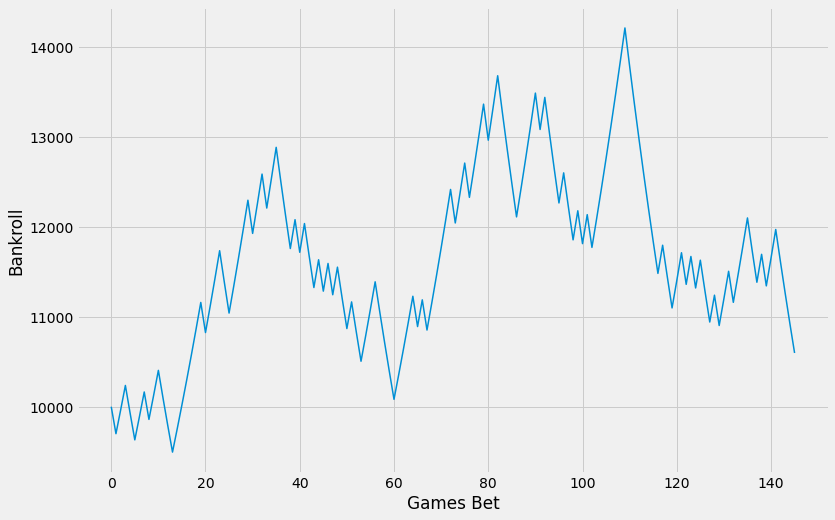

min balance: 9495.474893441879 
max balance: 14210.736110540929 
final balance: 10886.320185706538 
win percentage 54.11


index TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
0        1               IND               -4  IND vs. NYK              -9.5   
1        5               DET               -2  DET vs. BOS               8.0   
2        6               BKN               -1  BKN vs. WAS              -7.5   
3        7               MEM              -14  MEM vs. LAL              10.0   
4       10               PHX               -5  PHX vs. LAC               3.5   
..     ...               ...              ...          ...               ...   
141    573               TOR               -4  TOR vs. PHX               3.5   
142    577               NOP               -5  NOP vs. DEN               2.5   
143    587               TOR               -5  TOR vs. POR               2.5   
144    593               HOU              -10  HOU vs. MEM               8.0   
145    598               LAC               24  LAC vs. MIL               2.5   

     en_preds  home_cover  bet_home  bet_won    bankroll_i    bet_size  \
0    3.723771           0         1        0  10000.000000  300.000000   
1    2.559869           1         1        1   9700.000000  291.000000   
2   -4.080041           0         0        1   9964.545455  298.936364   
3    3.573525           0         1        0  10236.305785  307.089174   
4    2.042165           0         1        0   9929.216612  297.876498   
..        ...         ...       ...      ...           ...         ...   
141  5.471833           0         1        0  11970.392977  359.111789   
142  2.881363           0         1        0  11611.281188  348.338436   
143  3.269273           0         1        0  11262.942752  337.888283   
144  3.477994           0         1        0  10925.054470  327.751634   
145  4.485047           1         1        1  10597.302836  317.919085   

       bankroll_n  
0     9700.000000  
1     9964.545455  
2    10236.305785  
3     9929.216612  
4     9631.340113  
..            ...  
141  11611.281188  
142  11262.942752  
143  10925.054470  
144  10597.302836  
145  10886.320186  

[146 rows x 12 columns]

In [224]:
sgd_preds_2020_hd = best_sgd_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
sgd_preds_2020_hf = best_sgd_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])

en_preds_2020_hd = best_en_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
en_preds_2020_hf = best_en_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])


betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['en_preds'] = 0
betting_df_2020.loc[betting_df_2020['home_spread_mode'] >= 0, 'en_preds'] = en_preds_2020_hd
betting_df_2020.loc[betting_df_2020['home_spread_mode'] < 0, 'en_preds'] = en_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['en_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[((betting_df_2020['home_spread_mode'] >= 0) & (abs(betting_df_2020['en_preds']) > 2.))
                                       | ((betting_df_2020['home_spread_mode'] < 0) & (abs(betting_df_2020['en_preds']) > 2))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [384]:
# sgd_preds_2020_hd = sgd_pipe_hd.predict(features_2020.loc[features_2020['home_spread_mode'] > 0])
# sgd_preds_2020_hf = sgd_pipe_hf.predict(features_2020.loc[features_2020['home_spread_mode'] <= 0])

# lgbr_preds_2020 = best_lgbr.predict(features_2020)

# xgb_preds_2020 = xgbr.predict(features_2020)

# rf_preds_2020 = best_rf.predict(features_2020)

# en_preds_2020 = en_pipe.predict(features_2020)

net_preds = net(torch.Tensor(torch_scaler.transform(features_2020))).detach().numpy()

# net_preds

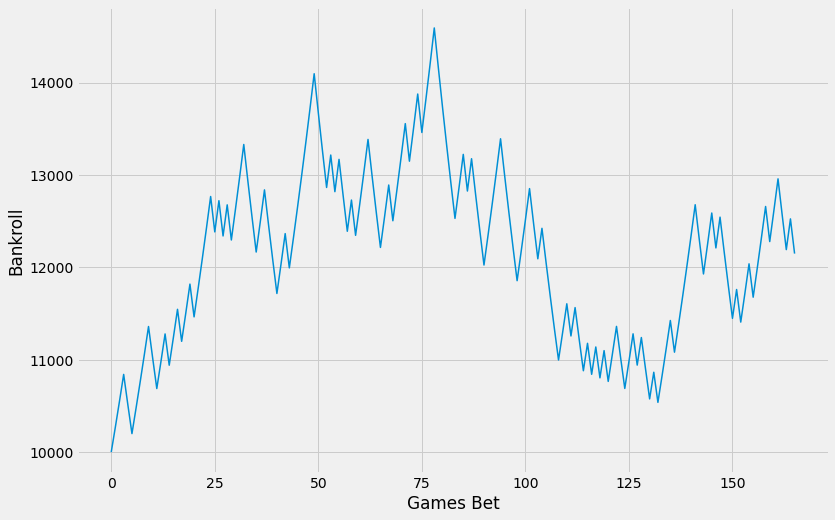

min balance: 10200.013428249435 
max balance: 14590.44129690014 
final balance: 11783.765125935191 
win percentage 54.82


index TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
0        3               ATL               -5  ATL vs. CLE              -5.5   
1        4               MIN              -15  MIN vs. DEN               8.5   
2        6               BKN               -1  BKN vs. WAS              -7.5   
3        7               MEM              -14  MEM vs. LAL              10.0   
4        8               SAS              -21  SAS vs. UTA               5.5   
..     ...               ...              ...          ...               ...   
161    548               MIL               27  MIL vs. IND              -7.0   
162    552               MIA              -10  MIA vs. PHX               2.0   
163    589               BOS               -6  BOS vs. NOP              -3.0   
164    593               HOU              -10  HOU vs. MEM               8.0   
165    596               UTA               39  UTA vs. CLE             -16.5   

     spread+diff  net_preds  home_cover  bet_home  bet_won    bankroll_i  \
0          -10.5  -7.630116           0         0        1  10000.000000   
1           -6.5 -17.511482           0         0        1  10272.727273   
2           -8.5 -24.358429           0         0        1  10552.892562   
3           -4.0  10.259763           0         1        0  10840.698723   
4          -15.5   8.119968           0         1        0  10515.477761   
..           ...        ...         ...       ...      ...           ...   
161         20.0  -7.958269           1         0        0  12957.206559   
162         -8.0   7.853865           0         1        0  12568.490362   
163         -9.0  -7.221478           0         0        1  12191.435651   
164         -2.0   8.024974           0         1        0  12523.929351   
165         22.5  -7.486481           1         0        0  12148.211470   

       bet_size    bankroll_n  
0    300.000000  10272.727273  
1    308.181818  10552.892562  
2    316.586777  10840.698723  
3    325.220962  10515.477761  
4    315.464333  10200.013428  
..          ...           ...  
161  388.716197  12568.490362  
162  377.054711  12191.435651  
163  365.743070  12523.929351  
164  375.717881  12148.211470  
165  364.446344  11783.765126  

[166 rows x 13 columns]

In [385]:
betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['spread+diff'] = betting_df_2020['home_spread_mode'] + betting_df_2020['point_diff_team']
betting_df_2020['net_preds'] = net_preds
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] > 0, 'sgd_preds'] = sgd_preds_2020_hd
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] <= 0, 'sgd_preds'] = sgd_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['net_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[abs(betting_df_2020['net_preds']) > 7]
    
                                       # ((betting_df_2020['home_spread_mode'] > 0) & (abs(betting_df_2020['sgd_preds']) > 1.69))
                                      # | ((betting_df_2020['home_spread_mode'] <= 0) & (abs(betting_df_2020['sgd_preds']) > 3.75))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [371]:
# select_bets_2020.loc[select_bets_2020['net_preds'] > 0]
betting_df_2020.loc[betting_df_2020['net_preds']>0]

TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
14                MIL               10  MIL vs. DET             -16.0   
25                NOP               -1  NOP vs. OKC              -8.0   
28                MIL               15  MIL vs. DET             -12.0   
31                MIA               -2  MIA vs. BOS              -2.5   
40                POR               18  POR vs. MIN             -10.0   
49                BOS                9  BOS vs. WAS              -3.5   
56                MIN               -3  MIN vs. SAS               3.5   
61                HOU              -18  HOU vs. LAL               3.5   
62                NYK              -25  NYK vs. DEN               5.5   
63                LAC                3  LAC vs. CHI             -12.5   
103               POR                6  POR vs. ATL              -5.0   
104               DAL              -16  DAL vs. CHI              -6.5   
116               POR              -21  POR vs. SAS               1.5   
118               UTA               16  UTA vs. NOP              -6.5   
121               LAC               19  LAC vs. SAC             -11.0   
130               GSW              -15  GSW vs. NYK              -5.0   
157               CLE               -7  CLE vs. LAL              12.0   
165               UTA               14  UTA vs. NYK             -11.0   
229               CHA               -7  CHA vs. PHI               7.0   
246               PHI               16  PHI vs. BKN              -7.5   
269               UTA               14  UTA vs. BOS              -5.5   
272               NOP               29  NOP vs. HOU              -6.5   
306               DET               11  DET vs. NOP               5.5   
307               LAC               17  LAC vs. CLE              -9.0   
309               TOR               -4  TOR vs. MIN              -7.5   
316               GSW               31  GSW vs. CLE             -11.0   
348               MIL               13  MIL vs. OKC             -11.0   
352               POR               -7  POR vs. WAS              -4.5   
359               TOR                7  TOR vs. PHI               3.0   
365               UTA               22  UTA vs. CHA             -12.5   
370               LAC               19  LAC vs. WAS             -12.0   
379               UTA               25  UTA vs. LAL              -8.5   
380               PHX               -3  PHX vs. CHA              -9.5   
383               NOP               10  NOP vs. DET             -11.5   
410               HOU              -49  HOU vs. MEM               4.0   
420               HOU              -11  HOU vs. CLE              -3.0   
435               HOU              -18  HOU vs. BKN              10.5   
479               ATL               18  ATL vs. CLE              -5.5   
487               CHA                6  CHA vs. SAC              -3.5   
497               POR                1  POR vs. NOP              -2.0   
537               CLE               11  CLE vs. TOR               7.0   
548               MIL               27  MIL vs. IND              -7.0   
559               ORL                1  ORL vs. PHX               9.5   
572               DET               -2  DET vs. BKN               6.5   

     net_preds  home_cover  bet_home  bet_won  
14    0.176570           0         1        0  
25    0.033497           0         1        0  
28    0.113456           1         1        1  
31    0.000057           0         1        0  
40    0.032014           1         1        1  
49    0.029540           1         1        1  
56    0.087571           1         1        1  
61    0.029953           0         1        0  
62    0.009299           0         1        0  
63    0.000713           0         1        0  
103   0.007039           1         1        1  
104   0.024863           0         1        0  
116   0.015959           0         1        0  
118   0.011476           1         1        1 

In [ ]:
simulate_bets(sgd_preds_2020)

## Make Predictions

ETL Pipeline

### Update Date

In [441]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


updating scoring boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.50s/it]


updating tracking boxscores
Updating 10 Games


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.00s/it]


### Get Todays Betting Data

In [442]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       DAL       WAS  2021-04-03     -4.5-110     -4.5-112          -4.5   
1       CLE       MIA  2021-04-03       12-110       12-108          12.5   
2       MIN       PHI  2021-04-03       13-110       12-110          13.5   
3       NYK       DET  2021-04-03     -1.5-110     -1.5-113          -1.5   
4       IND       SAS  2021-04-03        6-110      4.5-113           5.5   
5       ORL       UTA  2021-04-03       15-110       15-110          15.0   
6       MIL       SAC  2021-04-03       -6-105     -6.5-110          -5.5   
7       OKC       POR  2021-04-03     11.5-110     11.5-105          11.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           4.5           4.5   
1          12.0         -12.0         -12.0         -12.5         -12.0   
2          13.0         -13.0         -12.0         -13.5         -13.0   
3          -1.5           1.5           1.5           1.5           1.5   
4           6.0          -6.0          -4.5          -5.5          -6.0   
5          14.5         -15.0         -15.0         -15.0         -14.5   
6          -5.5           6.0           6.5           5.5           5.5   
7          11.5         -11.5         -11.5         -11.5         -11.5   

  away_spread_mode  home_spread_mode  
0             -4.5               4.5  
1             12.5             -12.0  
2           13-110             -13.0  
3             -1.5               1.5  
4            6-110              -6.0  
5           15-110             -15.0  
6             -5.5               5.5  
7             11.5             -11.5

In [443]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data('2020-21')

In [444]:
def get_team_and_opp_ewm_for_model(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'MIN_team', 'home_spread_mode', 'RECORD_team', 'team_covered', 'FG2M_team', 'FG2A_team',
       'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
       'DREB_team', 'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team',
       'PF_team', 'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team',
       'OFF_RATING_team', 'E_DEF_RATING_team', 'DEF_RATING_team',
       'E_NET_RATING_team', 'NET_RATING_team', 'POSS_team', 'PIE_team',
       'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team',
       'AST_2PM_team', 'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team',
       'SEASON_YEAR_opp', 'SEASON_ID_opp', 'TEAM_ID_opp',
       'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
       'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 'point_diff_opp',
       'WL_opp', 'MIN_opp', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
       'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
       'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp',
       'PLUS_MINUS_opp', 'E_OFF_RATING_opp', 'OFF_RATING_opp',
       'E_DEF_RATING_opp', 'DEF_RATING_opp', 'E_NET_RATING_opp',
       'NET_RATING_opp', 'POSS_opp', 'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp',
       'PTS_OFF_TOV_opp', 'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp',
       'AST_3PM_opp', 'UAST_3PM_opp', 'home_team', 'away_team', 'game_date',
       'away_spread_mode']]
    
    df = df.drop(columns = ['SEASON_YEAR_opp', 'SEASON_ID_opp', 
                            'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                            'TEAM_NAME_opp', 'GAME_DATE_opp', 
                            'MATCHUP_opp', 'WL_opp', 'HOME_GAME_opp',
                           'point_diff_opp', 'home_team', 'away_team', 'game_date',
                           'away_spread_mode'])
    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        team_record = team_df['RECORD_team'].shift(1).expanding().mean()
        ATS_rec = team_df['team_covered'].shift(1).expanding().mean()
        records_df = pd.DataFrame({'WL_record':team_record, 
                                  'ATS_record':ATS_rec})

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records_df], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df


In [445]:
def add_rest_days_for_model(df):
    df['rest'] = np.nan
    for season in df['SEASON_YEAR_team'].unique():
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['rest'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'rest'] = team_df['rest']
            
    return df

In [446]:
df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)
df1

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612746                    LAC   
1             2020-21           22020    1610612746                    LAC   
2             2020-21           22020    1610612746                    LAC   
3             2020-21           22020    1610612746                    LAC   
4             2020-21           22020    1610612746                    LAC   
...               ...             ...           ...                    ...   
1421          2020-21           22020    1610612760                    OKC   
1422          2020-21           22020    1610612760                    OKC   
1423          2020-21           22020    1610612760                    OKC   
1424          2020-21           22020    1610612760                    OKC   
1425          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0               LA Clippers  22000002     2020-12-22    LAC @ LAL   
1               LA Clippers  22000009     2020-12-25    LAC @ DEN   
2               LA Clippers  22000031     2020-12-27  LAC vs. DAL   
3               LA Clippers  22000054     2020-12-29  LAC vs. MIN   
4               LA Clippers  22000061     2020-12-30  LAC vs. POR   
...                     ...       ...            ...          ...   
1421  Oklahoma City Thunder  22000654     2021-03-22    OKC @ MIN   
1422  Oklahoma City Thunder  22000674     2021-03-24  OKC vs. MEM   
1423  Oklahoma City Thunder  22000713     2021-03-29  OKC vs. DAL   
1424  Oklahoma City Thunder  22000727     2021-03-31  OKC vs. TOR   
1425  Oklahoma City Thunder  22000744     2021-04-02    OKC @ PHX   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                  0              116                7        1       240   
1                  0              121               13        1       240   
2                  1               73              -51        0       240   
3                  1              124               23        1       240   
4                  1              128               23        1       240   
...              ...              ...              ...      ...       ...   
1421               0              112                9        1       240   
1422               1              107               -9        0       240   
1423               1              106              -21        0       240   
1424               1              113               10        1       240   
1425               0              103              -37        0       240   

      home_spread_mode  WL_record  ATS_record  RECORD_team  team_covered  \
0                 -2.0        NaN         NaN          NaN           NaN   
1                  4.0   1.000000    1.000000          NaN           NaN   
2                 -3.0   1.000000    1.000000          NaN           NaN   
3                -11.0   0.666667    0.666667          NaN           NaN   
4                 -6.0   0.750000    0.750000          NaN           NaN   
...                ...        ...         ...          ...           ...   
1421              -5.0   0.428571    0.523810     0.462632      0.503451   
1422               7.0   0.441860    0.534884     0.516954      0.553647   
1423              11.5   0.431818    0.522727     0.464753      0.497740   
1424               NaN   0.422222    0.511111     0.417868      0.447528   
1425               NaN   0.434783    0.500000     0.476542      0.402421   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN     

In [447]:
df1

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612746                    LAC   
1             2020-21           22020    1610612746                    LAC   
2             2020-21           22020    1610612746                    LAC   
3             2020-21           22020    1610612746                    LAC   
4             2020-21           22020    1610612746                    LAC   
...               ...             ...           ...                    ...   
1421          2020-21           22020    1610612760                    OKC   
1422          2020-21           22020    1610612760                    OKC   
1423          2020-21           22020    1610612760                    OKC   
1424          2020-21           22020    1610612760                    OKC   
1425          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0               LA Clippers  22000002     2020-12-22    LAC @ LAL   
1               LA Clippers  22000009     2020-12-25    LAC @ DEN   
2               LA Clippers  22000031     2020-12-27  LAC vs. DAL   
3               LA Clippers  22000054     2020-12-29  LAC vs. MIN   
4               LA Clippers  22000061     2020-12-30  LAC vs. POR   
...                     ...       ...            ...          ...   
1421  Oklahoma City Thunder  22000654     2021-03-22    OKC @ MIN   
1422  Oklahoma City Thunder  22000674     2021-03-24  OKC vs. MEM   
1423  Oklahoma City Thunder  22000713     2021-03-29  OKC vs. DAL   
1424  Oklahoma City Thunder  22000727     2021-03-31  OKC vs. TOR   
1425  Oklahoma City Thunder  22000744     2021-04-02    OKC @ PHX   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                  0              116                7        1       240   
1                  0              121               13        1       240   
2                  1               73              -51        0       240   
3                  1              124               23        1       240   
4                  1              128               23        1       240   
...              ...              ...              ...      ...       ...   
1421               0              112                9        1       240   
1422               1              107               -9        0       240   
1423               1              106              -21        0       240   
1424               1              113               10        1       240   
1425               0              103              -37        0       240   

      home_spread_mode  WL_record  ATS_record  RECORD_team  team_covered  \
0                 -2.0        NaN         NaN          NaN           NaN   
1                  4.0   1.000000    1.000000          NaN           NaN   
2                 -3.0   1.000000    1.000000          NaN           NaN   
3                -11.0   0.666667    0.666667          NaN           NaN   
4                 -6.0   0.750000    0.750000          NaN           NaN   
...                ...        ...         ...          ...           ...   
1421              -5.0   0.428571    0.523810     0.462632      0.503451   
1422               7.0   0.441860    0.534884     0.516954      0.553647   
1423              11.5   0.431818    0.522727     0.464753      0.497740   
1424               NaN   0.422222    0.511111     0.417868      0.447528   
1425               NaN   0.434783    0.500000     0.476542      0.402421   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN     

In [448]:
prev_season_final_elo = {}
for team in full_df_ewm_19['TEAM_ABBREVIATION'].unique():
    team_df = full_df_ewm_19.loc[full_df_ewm_19['MATCHUP'].str.contains(team)].sort_values('GAME_DATE').reset_index(drop=True)
    if team_df.loc[team_df.shape[0]-1, 'MATCHUP'][:3] == team:
        final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    else:
        final_elo = team_df.loc[team_df.shape[0]-1, 'away_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'IND': 1529.4483384275268,
 'HOU': 1540.8964001636646,
 'POR': 1500.1407073118096,
 'LAL': 1684.3757506350337,
 'CLE': 1298.0343645791245,
 'SAS': 1522.744349117492,
 'MIN': 1340.3072979400008,
 'CHI': 1332.027526532048,
 'MIL': 1629.7867944120128,
 'GSW': 1360.7007973857746,
 'SAC': 1516.141852484055,
 'LAC': 1626.6462653315195,
 'MIA': 1618.0421597762124,
 'BOS': 1703.07997468606,
 'NYK': 1326.2237584707232,
 'ATL': 1337.167197222995,
 'NOP': 1499.3615728404923,
 'DAL': 1544.6886733768054,
 'UTA': 1549.7536707979227,
 'DET': 1342.6198199001185,
 'ORL': 1490.8373868097253,
 'BKN': 1467.7010014887078,
 'PHX': 1536.6695679529985,
 'MEM': 1553.2535462864591,
 'DEN': 1584.84073526912,
 'WAS': 1380.5107315006996,
 'CHA': 1394.9240309027477,
 'PHI': 1552.491927190443,
 'TOR': 1676.213996740524,
 'OKC': 1560.4746669932429}

In [449]:
with open("../data/final_elo_2020.pkl", 'wb') as file:
    pickle.dump(prev_season_final_elo, file)
    

In [450]:
# Add ELO ratings
with open("../data/final_elo_2020.pkl", "rb") as file:
    final_elo_2020 = pickle.load(file)


def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME_team'] == 1]
    # Initialize the following columns
    df = df.sort_values('GAME_DATE_team')

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP_team'][:3]
        away_team_abbr = row['MATCHUP_team'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[home_team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)


progress:: 713it [00:01, 594.18it/s]


In [451]:
sorted(list(elo_ratings_dic.items()), key=lambda x: x[1], reverse=True)

[('UTA', 1695.1116127688701),
 ('DEN', 1643.9932061267505),
 ('PHX', 1643.2505280213047),
 ('PHI', 1641.91906223637),
 ('MIL', 1636.6251277234726),
 ('LAC', 1617.9483674908743),
 ('BKN', 1609.0970800387167),
 ('DAL', 1600.6323347879759),
 ('LAL', 1594.685823621672),
 ('ATL', 1549.0858878760444),
 ('CHA', 1529.246188892717),
 ('MEM', 1529.1740586616115),
 ('MIA', 1522.2233032905194),
 ('POR', 1509.5329643682226),
 ('BOS', 1508.5640846888216),
 ('IND', 1506.1032699853033),
 ('TOR', 1484.370998943311),
 ('NOP', 1460.0619221119289),
 ('NYK', 1459.8277688751557),
 ('SAC', 1454.8135939558026),
 ('SAS', 1445.5081664753009),
 ('GSW', 1443.6002087162024),
 ('CHI', 1422.7871491263463),
 ('OKC', 1406.9973753498114),
 ('DET', 1402.306882583506),
 ('ORL', 1388.455298586604),
 ('WAS', 1371.5658080238677),
 ('CLE', 1342.7394090393968),
 ('MIN', 1326.6109047226719),
 ('HOU', 1290.7402598053923)]

In [452]:
def create_matchup_rows_for_model(df, away_team, home_team, spread, current_elo_dic):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                      'SEASON_ID_team':'SEASON_ID',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df.sort_values(['GAME_DATE'], inplace=True)
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    home_stats.at[home_stats.shape[0]-1, 'rest'] = (datetime.today() - home_stats.at[home_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)
    away_stats.at[away_stats.shape[0]-1, 'rest'] = (datetime.today() - away_stats.at[away_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')

    diffs = home_stats.iloc[-1, 14:] - away_stats.iloc[-1, 14:]
    diffs = diffs.values.reshape(1, -1)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:]]
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
        
    diffs['home_rating_i'] = current_elo_dic[home_team]
    diffs['away_rating_i'] = current_elo_dic[away_team]
    diffs['home_elo_pred'] = 1.0/(1 + 10 ** (( diffs['away_rating_i'] - diffs['home_rating_i']) / (400.0)))

    diffs['elo_MOV_pred'] = round((diffs['home_rating_i']+100 - diffs['away_rating_i'])/28, 2)
    diffs['home_spread_mode'] = spread 
    
    diffs = diffs[X_train_ewm_19.columns]
    
    return diffs

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)

home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.179463      -0.0744681        -0.130346   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0         0.0100565       0.771314        1.38298   -0.000764037   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0        3.60108       1.18658      0.615254        -0.3409       -3.48034   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -3.82125       3.28415       2.38366      0.670353      -2.05369   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      3.52316       2.72691            -0.580535              -0.945318   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              1.11265              -0.177191               1.1315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              -0.786312           -0.0324955        1.48803   -0.00496232   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.20019          3.19163               4.46767   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             2.72338           2.67205           -1.99951          0.718132   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.695025             3.30745        0.130346     -0.135756   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0       1.99365      0.416147       -3.4697      2.33052      2.30673   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00117765       2.07533      2.07415      2.90665     -2.29005   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.671452      3.54816    0.931445      3.30745            0.580535   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0             -0.177191              1.1315             -0.945318   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             1.11265              0.786312           0.0324955       1.81846   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00496232             1.39736         3.59304             -4.42725   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -1.72532          2.22005          -2.37193         0.657797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.346865         -0.0158015          0.017094          -0.017094   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0         0.0158015        -0.0326693        0.0326693       -0.0169042   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0238796        -0.0201873        0.0145145             2.89928   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.42549          -2.17765          2.81216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.386336    1326.610905    1406.997375           0.7

### Make Predictions

In [453]:
todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       DAL       WAS  2021-04-03     -4.5-110     -4.5-112          -4.5   
1       CLE       MIA  2021-04-03       12-110       12-108          12.5   
2       MIN       PHI  2021-04-03       13-110       12-110          13.5   
3       NYK       DET  2021-04-03     -1.5-110     -1.5-113          -1.5   
4       IND       SAS  2021-04-03        6-110      4.5-113           5.5   
5       ORL       UTA  2021-04-03       15-110       15-110          15.0   
6       MIL       SAC  2021-04-03       -6-105     -6.5-110          -5.5   
7       OKC       POR  2021-04-03     11.5-110     11.5-105          11.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           4.5           4.5   
1          12.0         -12.0         -12.0         -12.5         -12.0   
2          13.0         -13.0         -12.0         -13.5         -13.0   
3          -1.5           1.5           1.5           1.5           1.5   
4           6.0          -6.0          -4.5          -5.5          -6.0   
5          14.5         -15.0         -15.0         -15.0         -14.5   
6          -5.5           6.0           6.5           5.5           5.5   
7          11.5         -11.5         -11.5         -11.5         -11.5   

  away_spread_mode  home_spread_mode  
0             -4.5               4.5  
1             12.5             -12.0  
2           13-110             -13.0  
3             -1.5               1.5  
4            6-110              -6.0  
5           15-110             -15.0  
6             -5.5               5.5  
7             11.5             -11.5

In [39]:
# Load Models

with open('../models/sgd_ewm_19.pkl', 'rb') as f:
    sgd_pipe = pickle.load(f)
    
with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
    best_lgbr = pickle.load(f)
    
with open('../models/xgb_ewm_19.pkl', 'rb') as f:
    best_xgbr = pickle.load(f)
    
with open('../models/rf_ewm_19.pkl', 'rb') as f:
    best_rf = pickle.load(f)
    
with open('../models/en_ewm_19.pkl', 'rb') as f:
    en_pipe = pickle.load(f)
    
with open("../models/lasso_ewm_19.pkl", 'rb') as f:
    lasso_pipe = pickle.load(f)

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.183092      -0.0763285        -0.144892   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0          0.011143        1.19352        2.20987   -0.000726966   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0         3.2203       1.87994       1.69273       0.741648       -2.30137   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -1.55972       2.97972       1.86619      0.521539      -1.49935   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      4.14165        4.2648             0.363874               0.192724   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              2.11145               0.115911              1.12315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              0.0677887             0.984322        1.99059   -0.00237432   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.44673          3.10111               3.84759   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             3.58807           2.97124           -1.88749         0.0143575   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.100572             3.90093        0.144892       -1.1599   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0      0.536119       1.02301      -1.28157      3.15171      2.90113   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00155193       1.63512      1.63357      3.34388     -1.87421   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.858817      2.82509     1.82035      3.90093           -0.363874   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0              0.115911             1.12315              0.192724   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             2.11145            -0.0677887           -0.984322       2.35787   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00237432            0.095416         3.99595              -3.6913   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -2.36804          2.24413          -3.42199           1.1797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.161641         0.00481673         0.0116754         -0.0116754   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0       -0.00481673         -0.017652         0.017652       -0.0128075   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0213821         -0.017978       0.00875831              2.4739   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.70151          -1.85381           2.1216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.383526    1329.036655    1411.484854          0.63

In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


away_team home_team  spread   game_date        net_pred
0       DAL       WAS     4.5  2021-04-03    [-2.0314543]
1       CLE       MIA   -12.0  2021-04-03    [-0.7431023]
2       MIN       PHI   -13.0  2021-04-03     [-2.774469]
3       NYK       DET     1.5  2021-04-03    [0.21155608]
4       IND       SAS    -6.0  2021-04-03    [-1.0953536]
5       ORL       UTA   -15.0  2021-04-03  [-0.026118085]
6       MIL       SAC     5.5  2021-04-03    [0.10418765]
7       OKC       POR   -11.5  2021-04-03     [-2.474314]

In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df